In [2]:
import pandas as pd
import networkx as nx
import numpy as np
import pickle as pk
import matplotlib.pyplot as plt 
from collections import Counter
from scipy import stats
import gseapy as gp
from community import community_louvain
import random as rd
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.manifold import TSNE



In [3]:
from collections import defaultdict

def bin_nodes_by_degree(graph):
    bins = defaultdict(list)
    for node, degree in graph.degree():
        bins[degree].append(node)
    return bins

def sample_nodes_from_bins(bins, sample_fraction=0.5):
    sampled_nodes = []
    for degree_bin in bins.values():
        sample_size = int(len(degree_bin) * sample_fraction)
        # Ensure at least one node is sampled from non-empty bins
        sample_size = max(1, sample_size)
        sampled_nodes.extend(rd.sample(degree_bin, sample_size))
    return sampled_nodes

def sample_clustering_coefficient_degree_binned(graph, sample_fraction=0.5):
    # Bin nodes by degree
    bins = bin_nodes_by_degree(graph)
    # Sample nodes from each bin
    sampled_nodes = sample_nodes_from_bins(bins, sample_fraction)
    # Calculate the clustering coefficient for each sampled node
    clustering_coefficients = [nx.clustering(graph, node) for node in sampled_nodes]
    return clustering_coefficients



def read_gene_annotation(file_path):
    """
    Reads a gene annotation file and stores it as a dictionary.
    
    Parameters:
        file_path (str): Path to the input text file.
        
    Returns:
        dict: Dictionary where keys are annotations and values are lists of genes.
    """
    gene_dict = {}
    
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split('\t')  # Split by tab
            if len(parts) > 1:
                annotation = parts[0].strip()
                genes = [gene.strip() for gene in parts[1:] if gene.strip()]
                gene_dict[annotation] = genes
    
    return gene_dict

def overlap_jaccard(list1,list2):
    intersction_term= len(set(list1) & set(list2))
    denominator = len(set(list1).union(set(list2)))
    overlap_jaccard_coeff = intersction_term/denominator
    return overlap_jaccard_coeff

def overlap_genelists(lstA, lstB, background):
    import scipy.stats as stats
    """
    Accepts to lists
    M is the population size (previously N)
    n is the number of successes in the population
    N is the sample size (previously n)
    x is still the number of drawn “successes”
    """
    setA= set(lstA)
    setB= set(lstB)
    M= background #total number of genes
    n= len(setA)
    N= len(setB)
    x= len(setA.intersection(setB))


    return str(stats.hypergeom.sf(x-1, M, n, N))



#Here we define the adjustment
from statsmodels.sandbox.stats.multicomp import multipletests
def fdr_adjustment(list_of_pvals,alpha):    
    return multipletests(list_of_pvals,alpha=alpha,method='fdr_bh')[1] #the benjamin hochberg method is used


def enrichment_fishers(foreground_list,background_lenght):
    ann_list = []
    pval_list = []
    ji_list = []
    for ann,annotation_list in tot_gene_annotation_dict.items():
        pval_ov = float(overlap_genelists(foreground_list,annotation_list,background_lenght)) 
        ji_overlap = overlap_jaccard(foreground_list,annotation_list)
        ann_list.append(ann)
        pval_list.append(pval_ov)
        ji_list.append(ji_overlap)
    adj_pval = fdr_adjustment(pval_list,0.05)
    results_df = pd.DataFrame()
    results_df['Term'] = ann_list
    results_df['Overlap'] = ji_list
    results_df['P-value'] = pval_list
    results_df['FDR'] = adj_pval
    # Sort results by adjusted p-value
    results_df = results_df.sort_values(by='FDR')
    # Compute combined score (-log10 Adjusted P-value * Overlap)
    results_df['Combined Score'] = -np.log10(results_df['FDR']) * results_df['Overlap']
    results_df_sig = results_df[results_df['FDR']<0.05]
    return results_df_sig
    
library_list = ["GO_Molecular_Function_2025","GO_Biological_Process_2025","GO_Cellular_Component_2025","Reactome_Pathways_2024"]
def enr_ranking_leading_genes(pre_rank_df,library_list):   #This function returns the leading genes
    leading_genes_tot=[]
    for lib in library_list:
        c=0
        while c<10:
            try:
                lib_pre_res = gp.prerank(rnk=pre_rank_df, gene_sets=lib,
                                 processes=4,min_size=3,max_size=5000,outdir=None,   #we impose at least 5 enriched common genes
                                 permutation_num=500) # reduce number to speed up testing
                leading_gene_lib_list=[]
                for gene_str in lib_pre_res.res2d['Lead_genes'].tolist():    #lib_pre_res.res2d['Lead_genes'] if in the cluster
                    leading_gene_lib_list.extend(gene_str.split(";"))
                leading_genes_tot.extend(leading_gene_lib_list)
                if 'Lead_genes' in lib_pre_res.res2d:
                    break
            except (NameError, AttributeError):
                c += 1
    return set(leading_genes_tot)


In [4]:
def read_json_to_dict(file):
    import json
    import pandas as pd
    
    # Load the JSON file (replace with your path)
    with open(file, "r") as f:
        possible_dict = json.load(f)
    
    # Initialize an empty dictionary to store DataFrames for each key
    dataframes_dict = {}
    
    # Loop through each key in the possible_dict
    for key, result in possible_dict.items():
        # Initialize an empty list to store the rows for this DataFrame
        data = []
        
        # Iterate through the list of results for each key
        for entry in result:
            # Split FgRatio and BgRatio
            fg_ratio_split = entry['FgRatio'].split('/')
            bg_ratio_split = entry['BgRatio'].split('/')
            
            # Convert the split ratios to numeric values
            fg_ratio = float(fg_ratio_split[0]) / float(fg_ratio_split[1])
            bg_ratio = float(bg_ratio_split[0]) / float(bg_ratio_split[1])
            
            # Prepare the row data with all required columns
            row = {
                'Description': entry['Description'],
                'FgRatio': fg_ratio,
                'BgRatio': bg_ratio,
                'ES': entry['ES'],
                'pvalue': entry['pvalue'],
                'FDR': entry['FDR'],
                '_row': entry['_row']
            }
            
            # Append the row to the data list
            data.append(row)
        
        # Convert the data list into a DataFrame
        df = pd.DataFrame(data)
        
        # Store the DataFrame in the dictionary with the key as its name
        dataframes_dict[key] = df
    return dataframes_dict


In [3]:
from community import community_louvain

#Here, we find the resolution parameter that optimizes Newman's modularity
def optimal_resolution_with_diagnostics_simple_network(G, resolution_list,weight,rd_state):
    max_modularity = -1
    modularity_scores = []
    for resolution in resolution_list:
        partition = community_louvain.best_partition(G, resolution=resolution,weight=weight,random_state=rd_state)
        modularity = community_louvain.modularity(partition,G)
        if modularity > max_modularity:   # save the partition and resolution giving the maximum modularity
            max_modularity = modularity
            best_partition = partition
            best_resolution = resolution
        modularity_scores.append((resolution, modularity))
    return best_partition, best_resolution, max_modularity, modularity_scores

#Here, we define a function that allows us to select the resolution parameter that corresponds to the 
#maximum value of modularity

def optimal_resolution(G, resolution_list,weight,random_state):
    """
    Param:
    G: A networkx graph
    resolution_list: List of resolution values to check
    """
    res_mod_dict = {}
    max_modularity = -1 # initialize maximum modularity as negative value
    for resolution in resolution_list:
        partition = community_louvain.best_partition(G, resolution=resolution,weight=weight,random_state=random_state)
        modularity = community_louvain.modularity(partition,G)
        res_mod_dict[resolution] = modularity

        if modularity > max_modularity:   # save the partition and resolution giving the maximum modularity
            max_modularity = modularity
            best_partition = partition
            best_resolution = resolution
            
    return best_partition, best_resolution, max_modularity,res_mod_dict

In [8]:
#Let's import the chemical-gene interactions from CTD (downloaded on 5th April 2021)
chem_gene_df = pd.read_csv("input/CTD/CTD_chem_gene_ixns.tsv",delimiter= '\t', skipinitialspace=True)
#Here, we filter for only the interactions that regards the H. Sapiens
chem_homo = chem_gene_df[(chem_gene_df['Organism'] == 'Homo sapiens')]

#Here, we create a dictionary out of the dataframe that has as a key the exposures and as 
#values the set of the genes that they perturb
chem_gene = {}
for i,v in chem_homo.iterrows():
    try:
        chem_gene[v["ChemicalID"]] |= {v["GeneSymbol"]}
    except KeyError as e:
        chem_gene[v["ChemicalID"]] = set([v["GeneSymbol"]])

#Here, we remove the elements that do not perturb any genes:       
chem_gene_cleaned = {}
tot_gene_list=[]
for k,v in chem_gene.items():
    if len(v)>0:
        chem_gene_cleaned[k]=v
        for gene in v:
            tot_gene_list.append(gene)           
    else:
        pass
 
print("The number of exposures is %s" %len(chem_gene_cleaned))
print("The total number of perturbed genes is %s" %len(set(tot_gene_list)))

The number of exposures is 9887
The total number of perturbed genes is 25580


In [4]:
#Here, we import the unfiltered and the backbone EEN
unfiltered_weighted_exp_graph_significant = nx.read_weighted_edgelist("output/unfiltered_weighted_exp_graph_significant.edgelist")
filtered_weighted_exp_graph_significant = nx.read_weighted_edgelist("output/backbone_exp_graph_significant_weighted.edgelist")


In [5]:
unfiltered_unweighted_exp_graph_significant=nx.Graph()
for e in unfiltered_weighted_exp_graph_significant.edges():
    unfiltered_unweighted_exp_graph_significant.add_edge(*e)

filtered_unweighted_exp_graph_significant=nx.Graph()
for e in filtered_weighted_exp_graph_significant.edges():
    filtered_unweighted_exp_graph_significant.add_edge(*e)


In [156]:

nx.write_edgelist(unfiltered_unweighted_exp_graph_significant, "output/unfiltered_unweighted_exp_graph_significant.edgelist")
nx.write_edgelist(filtered_unweighted_exp_graph_significant,"output/filtered_unweighted_exp_graph_significant.edgelist")

In [ ]:
resolution_list = np.linspace(0.1, 2, 20) 


unweight_unfiltered_een_best_partition, unweight_unfiltered_een_best_resolution, unweight_unfiltered_een_max_modularity, unweight_unfiltered_een_modularity_scores = optimal_resolution_with_diagnostics_simple_network(unfiltered_unweighted_exp_graph_significant, resolution_list,'weight',5495)
unweight_filtered_een_best_partition, unweight_filtered_een_best_resolution, unweight_filtered_een_max_modularity, unweight_filtered_een_modularity_scores = optimal_resolution_with_diagnostics_simple_network(filtered_unweighted_exp_graph_significant, resolution_list,'weight',5495)
weight_unfiltered_een_best_partition, weight_unfiltered_een_best_resolution, weight_unfiltered_een_max_modularity, weight_unfiltered_een_modularity_scores = optimal_resolution_with_diagnostics_simple_network(unfiltered_weighted_exp_graph_significant, resolution_list,'weight',5495)
weight_filtered_een_best_partition, weight_filtered_een_best_resolution, weight_filtered_een_max_modularity, weight_filtered_een_modularity_scores = optimal_resolution_with_diagnostics_simple_network(filtered_weighted_exp_graph_significant, resolution_list,'weight',5495)



In [ ]:

with open('intermediate/unweight_unfiltered_een_modularity_scores.txt', 'wb') as fp:
    pk.dump(unweight_unfiltered_een_modularity_scores, fp)

with open('intermediate/unweight_filtered_een_modularity_scores.txt', 'wb') as fp:
    pk.dump(unweight_filtered_een_modularity_scores, fp)

with open('intermediate/weight_unfiltered_een_modularity_scores.txt', 'wb') as fp:
    pk.dump(weight_unfiltered_een_modularity_scores, fp)

with open('intermediate/weight_filtered_een_modularity_scores.txt', 'wb') as fp:
    pk.dump(weight_filtered_een_modularity_scores, fp)

In [2]:
with open ('intermediate/unweight_unfiltered_een_modularity_scores.txt', 'rb') as fp:
    unweight_unfiltered_een_modularity_scores = pk.load(fp)

with open ('intermediate/unweight_filtered_een_modularity_scores.txt', 'rb') as fp:
    unweight_filtered_een_modularity_scores = pk.load(fp)

with open ('intermediate/weight_unfiltered_een_modularity_scores.txt', 'rb') as fp:
    weight_unfiltered_een_modularity_scores = pk.load(fp)

with open ('intermediate/weight_filtered_een_modularity_scores.txt', 'rb') as fp:
    weight_filtered_een_modularity_scores = pk.load(fp)



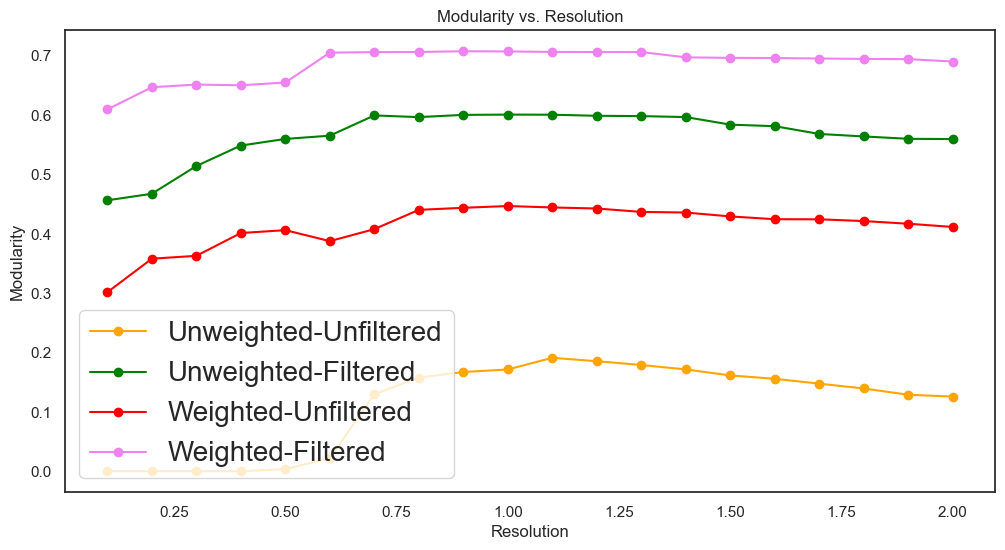

In [74]:
#This plot shows the relationship between resolution and modularity
plt.figure(figsize=(12, 6))
# Plot the modularity versus resolution

unweight_unfiltered_resolutions, unweight_unfiltered_modularities = zip(*unweight_unfiltered_een_modularity_scores)
unweight_filtered_een_resolutions, unweight_filtered_een_modularities = zip(*unweight_filtered_een_modularity_scores)
weight_unfiltered_een_resolutions, weight_unfiltered_eenn_modularities = zip(*weight_unfiltered_een_modularity_scores)
weight_filtered_een_resolutions, weight_filtered_een_modularities = zip(*weight_filtered_een_modularity_scores)


plt.plot(unweight_unfiltered_resolutions, unweight_unfiltered_modularities, marker='o',color="orange",label='Unweighted-Unfiltered')
plt.plot(unweight_filtered_een_resolutions, unweight_filtered_een_modularities, marker='o',color="green",label='Unweighted-Filtered')
plt.plot(weight_unfiltered_een_resolutions, weight_unfiltered_eenn_modularities, marker='o',color="red",label='Weighted-Unfiltered')
plt.plot(weight_filtered_een_resolutions, weight_filtered_een_modularities, marker='o',color="violet",label='Weighted-Filtered')

plt.xlabel('Resolution')
plt.ylabel('Modularity')
plt.title('Modularity vs. Resolution')
plt.legend(fontsize=20)
#plt.savefig('output/Figures/SF2B_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()




In [75]:
# unpack tuples
unweight_unfiltered_resolutions, unweight_unfiltered_modularities = zip(*unweight_unfiltered_een_modularity_scores)
unweight_filtered_een_resolutions, unweight_filtered_een_modularities = zip(*unweight_filtered_een_modularity_scores)
weight_unfiltered_een_resolutions, weight_unfiltered_eenn_modularities = zip(*weight_unfiltered_een_modularity_scores)
weight_filtered_een_resolutions, weight_filtered_een_modularities = zip(*weight_filtered_een_modularity_scores)

rows = []

def add_curve(condition, resolutions, modularities, color):
    for r, m in zip(resolutions, modularities):
        rows.append({
            "Condition": condition,
            "Resolution": r,
            "Modularity": m,
            "Color": color,
            "Marker": "o"
        })

add_curve("Unweighted-Unfiltered",
          unweight_unfiltered_resolutions,
          unweight_unfiltered_modularities,
          "orange")

add_curve("Unweighted-Filtered",
          unweight_filtered_een_resolutions,
          unweight_filtered_een_modularities,
          "green")

add_curve("Weighted-Unfiltered",
          weight_unfiltered_een_resolutions,
          weight_unfiltered_eenn_modularities,
          "red")

add_curve("Weighted-Filtered",
          weight_filtered_een_resolutions,
          weight_filtered_een_modularities,
          "violet")

modularity_source_df = pd.DataFrame(rows)

In [76]:
excel_path = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(
        excel_path,
        engine="openpyxl",
        mode="a",
        if_sheet_exists="new"
    ) as writer:

    modularity_source_df.to_excel(
        writer,
        sheet_name="SF6B",
        index=False
    )

print("Source data saved for modularity vs resolution plot.")

Source data saved for modularity vs resolution plot.


In [151]:
#The highest modularity is observed for the Weighted-Filtered EEN with a resolution of 0.9
weight_filtered_een_resolutions[weight_filtered_een_modularities.index(max(weight_filtered_een_modularities))]




0.8999999999999999

In [ ]:
#We calculate the clustering coefficient
unfiltered_unweighted_exp_graph_significant_clustering_coefficient = nx.clustering(unfiltered_unweighted_exp_graph_significant)
filtered_unweighted_exp_graph_significant_clustering_coefficient = nx.clustering(filtered_unweighted_exp_graph_significant)
unfiltered_weighted_exp_graph_significant_clustering_coefficient = nx.clustering(unfiltered_weighted_exp_graph_significant,weight='weight')
filtered_weighted_exp_graph_significant_coefficient = nx.clustering(filtered_weighted_exp_graph_significant,weight='weight')



In [ ]:
with open('output/Communities/unfiltered_unweighted_exp_graph_significant_clustering_coefficient.pickle', 'wb') as handle:
    pk.dump(unfiltered_unweighted_exp_graph_significant_clustering_coefficient, handle, protocol=pk.HIGHEST_PROTOCOL)

with open('output/Communities/filtered_unweighted_exp_graph_significant_clustering_coefficient.pickle', 'wb') as handle:
    pk.dump(filtered_unweighted_exp_graph_significant_clustering_coefficient, handle, protocol=pk.HIGHEST_PROTOCOL)

with open('output/Communities/unfiltered_weighted_exp_graph_significant_clustering_coefficient.pickle', 'wb') as handle:
    pk.dump(unfiltered_weighted_exp_graph_significant_clustering_coefficient, handle, protocol=pk.HIGHEST_PROTOCOL)

with open('output/Communities/filtered_weighted_exp_graph_significant_coefficient.pickle', 'wb') as handle:
    pk.dump(filtered_weighted_exp_graph_significant_coefficient, handle, protocol=pk.HIGHEST_PROTOCOL)

In [9]:
with open('output/Communities/bipartite_clustering_coefficient.pickle', 'rb') as handle:
    bipartite_clustering_coefficient = pk.load(handle)

with open('output/Communities/unfiltered_unweighted_exp_graph_significant_clustering_coefficient.pickle', 'rb') as handle:
    unfiltered_unweighted_exp_graph_significant_clustering_coefficient = pk.load(handle)

with open('output/Communities/filtered_unweighted_exp_graph_significant_clustering_coefficient.pickle', 'rb') as handle:
    filtered_unweighted_exp_graph_significant_clustering_coefficient = pk.load(handle)

with open('output/Communities/unfiltered_weighted_exp_graph_significant_clustering_coefficient.pickle', 'rb') as handle:
    unfiltered_weighted_exp_graph_significant_clustering_coefficient = pk.load(handle)

with open('output/Communities/filtered_weighted_exp_graph_significant_coefficient.pickle', 'rb') as handle:
    filtered_weighted_exp_graph_significant_coefficient = pk.load(handle)

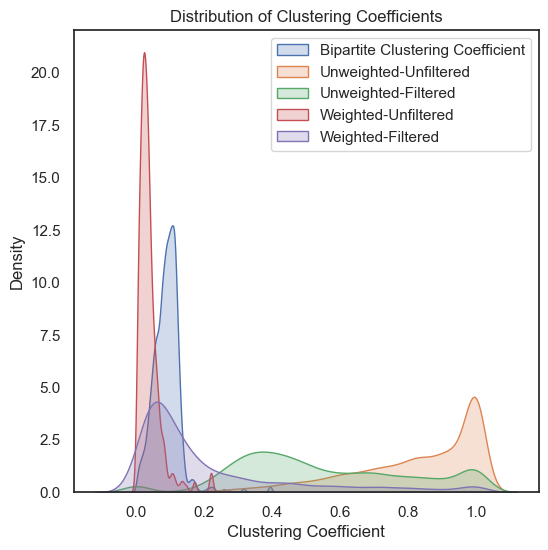

In [97]:
import seaborn as sns
# Extract the values from the dictionaries
bipartite_values = list(bipartite_clustering_coefficient.values())
unfiltered_unweighted_EEN = list(unfiltered_unweighted_exp_graph_significant_clustering_coefficient.values())
filtered_unweighted_EEN = list(filtered_unweighted_exp_graph_significant_clustering_coefficient.values())
unfiltered_weighted_EEN = list(unfiltered_weighted_exp_graph_significant_clustering_coefficient.values())
filtered_weighted_EEN = list(filtered_weighted_exp_graph_significant_coefficient.values())

# Set up the plot
plt.figure(figsize=(6, 6))

# Plot the distributions using seaborn
sns.kdeplot(bipartite_values, label='Bipartite Clustering Coefficient', fill=True)
sns.kdeplot(unfiltered_unweighted_EEN, label='Unweighted-Unfiltered', fill=True)
sns.kdeplot(filtered_unweighted_EEN, label='Unweighted-Filtered', fill=True)
sns.kdeplot(unfiltered_weighted_EEN, label='Weighted-Unfiltered', fill=True)
sns.kdeplot(filtered_weighted_EEN, label='Weighted-Filtered', fill=True)

# Customize the plot
plt.xlabel('Clustering Coefficient')
plt.ylabel('Density')
plt.title('Distribution of Clustering Coefficients')
plt.legend()
plt.grid(False)
plt.savefig('output/Figures/SF2D_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")
# Show the plot
plt.show()

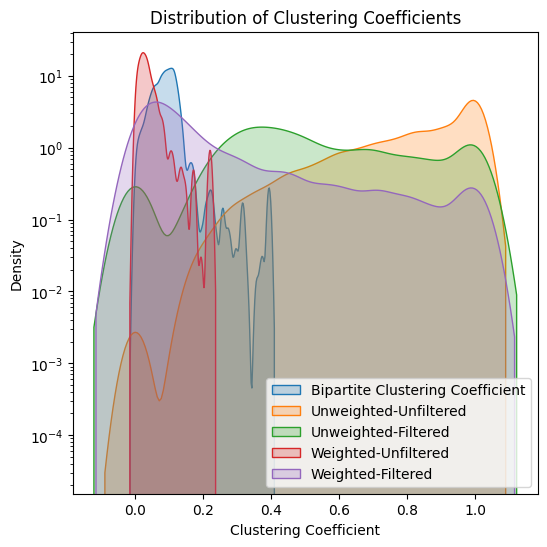

In [10]:
import seaborn as sns
# Extract the values from the dictionaries
bipartite_values = list(bipartite_clustering_coefficient.values())
unfiltered_unweighted_EEN = list(unfiltered_unweighted_exp_graph_significant_clustering_coefficient.values())
filtered_unweighted_EEN = list(filtered_unweighted_exp_graph_significant_clustering_coefficient.values())
unfiltered_weighted_EEN = list(unfiltered_weighted_exp_graph_significant_clustering_coefficient.values())
filtered_weighted_EEN = list(filtered_weighted_exp_graph_significant_coefficient.values())

# Set up the plot
plt.figure(figsize=(6, 6))

# Plot the distributions using seaborn
sns.kdeplot(bipartite_values, label='Bipartite Clustering Coefficient', fill=True)
sns.kdeplot(unfiltered_unweighted_EEN, label='Unweighted-Unfiltered', fill=True)
sns.kdeplot(filtered_unweighted_EEN, label='Unweighted-Filtered', fill=True)
sns.kdeplot(unfiltered_weighted_EEN, label='Weighted-Unfiltered', fill=True)
sns.kdeplot(filtered_weighted_EEN, label='Weighted-Filtered', fill=True)

# Customize the plot
plt.xlabel('Clustering Coefficient')
plt.ylabel('Density')
plt.title('Distribution of Clustering Coefficients')
plt.yscale("log")
plt.legend()
plt.grid(False)
plt.savefig('output/Figures/SF2D_v02_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")
# Show the plot
plt.show()

In [79]:

# Extract values
bipartite_values = list(bipartite_clustering_coefficient.values())
unfiltered_unweighted_EEN = list(unfiltered_unweighted_exp_graph_significant_clustering_coefficient.values())
filtered_unweighted_EEN = list(filtered_unweighted_exp_graph_significant_clustering_coefficient.values())
unfiltered_weighted_EEN = list(unfiltered_weighted_exp_graph_significant_clustering_coefficient.values())
filtered_weighted_EEN = list(filtered_weighted_exp_graph_significant_coefficient.values())

rows = []

def add_values(condition, values):
    for v in values:
        rows.append({
            "Condition": condition,
            "ClusteringCoefficient": v
        })

add_values("Bipartite", bipartite_values)
add_values("Unweighted-Unfiltered", unfiltered_unweighted_EEN)
add_values("Unweighted-Filtered", filtered_unweighted_EEN)
add_values("Weighted-Unfiltered", unfiltered_weighted_EEN)
add_values("Weighted-Filtered", filtered_weighted_EEN)

kde_source_df = pd.DataFrame(rows)

excel_path = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(
        excel_path,
        engine="openpyxl",
        mode="a",
        if_sheet_exists="new"
    ) as writer:

    kde_source_df.to_excel(
        writer,
        sheet_name="SF6D",
        index=False
    )

print("Source data saved for KDE clustering coefficient plot.")

Source data saved for KDE clustering coefficient plot.


In [153]:

best_partition, best_resolution, max_modularity, res_mod_dict = optimal_resolution(filtered_weighted_exp_graph_significant, resolution_list,'weight',5495)
print('Optimal resolution value: ', best_resolution)




Optimal resolution value:  0.8999999999999999


In [155]:
#Here, we calculate the communities in hierarchical fashion with Louvain
#We take into account the weights of the weighted network and the best resolution parameter
dendo = community_louvain.generate_dendrogram(filtered_weighted_exp_graph_significant,resolution=0.9 ,weight='weight',random_state=5495)

In [156]:
#There are three hierarchical levels
len(dendo)

3

In [157]:
#This is the number of nodes
len(dendo[0])

9764

In [158]:
#This is the finest grained communities
len(dendo[1])

456

In [159]:
len(dendo[2])

152

In [161]:
#Let's define the three hierarchical communities as dictionaries
ee_first_louvain_iteration_exposures={}   

for com in set(list(dendo[0].values())):
    exp_list=[]
    for exp, comcom in dendo[0].items():
        if com==comcom:
            exp_list.append(exp)
    ee_first_louvain_iteration_exposures[com]=exp_list
    
ee_first_louvain_iteration={}  #this dictionary contains the middle-hierarchical level as keys and the respective (dividing)
                               #finest (first) hierarchical communities as values
for com in set(list(dendo[1].values())):
    exp_list=[]
    for exp, comcom in dendo[1].items():
        if com==comcom:
            exp_list.append(exp)
    ee_first_louvain_iteration[com]=exp_list
    
ee_second_louvain_iteration={} #this dictionary has the broad-hierarchical (third) level as keys and the respective (dividing)
                               #middle (second) hierarchical communities as values
for com in set(list(dendo[2].values())):
    exp_list=[]
    for exp, comcom in dendo[2].items():
        if com==comcom:
            exp_list.append(exp)
    ee_second_louvain_iteration[com]=exp_list


In [162]:
len(ee_first_louvain_iteration_exposures)

456

In [163]:
#These communities are the middle and the broad level related to each community

ee_second_louvain_iteration_exposures={}  
for com, com_list in ee_first_louvain_iteration.items():
    exp_list=[]
    for comcom in com_list:
        exp_list.extend(ee_first_louvain_iteration_exposures[comcom])
    ee_second_louvain_iteration_exposures[com]=exp_list

ee_third_louvain_iteration_exposures={}
for com, com_list in ee_second_louvain_iteration.items():
    exp_list=[]
    for comcom in com_list:
        exp_list.extend(ee_second_louvain_iteration_exposures[comcom])
    ee_third_louvain_iteration_exposures[com]=exp_list

In [165]:
with open('output/Communities/Louvain/weighted_ee_ji_first_louvain_iteration_exposures.pickle', 'wb') as handle:
    pk.dump(ee_first_louvain_iteration_exposures, handle, protocol=pk.HIGHEST_PROTOCOL)

with open('output/Communities/Louvain/weighted_ee_ji_second_louvain_iteration_exposures.pickle', 'wb') as handle:
    pk.dump(ee_second_louvain_iteration_exposures, handle, protocol=pk.HIGHEST_PROTOCOL)

with open('output/Communities/Louvain/weighted_ee_ji_third_louvain_iteration_exposures.pickle', 'wb') as handle:
    pk.dump(ee_third_louvain_iteration_exposures, handle, protocol=pk.HIGHEST_PROTOCOL)

In [166]:
with open('output/Communities/Louvain/weighted_ee_ji_first_louvain_iteration.pickle', 'wb') as handle:
    pk.dump(ee_first_louvain_iteration, handle, protocol=pk.HIGHEST_PROTOCOL)

with open('output/Communities/Louvain/weighted_ee_ji_second_louvain_iteration.pickle', 'wb') as handle:
    pk.dump(ee_second_louvain_iteration, handle, protocol=pk.HIGHEST_PROTOCOL)

In [5]:
with open ('Communities/Louvain/weighted_ee_ji_first_louvain_iteration_exposures.pickle', 'rb') as fp:
    ee_first_louvain_iteration_exposures = pk.load(fp)

with open ('Communities/Louvain/weighted_ee_ji_second_louvain_iteration_exposures.pickle', 'rb') as fp:
    ee_second_louvain_iteration_exposures = pk.load(fp)

with open ('Communities/Louvain/weighted_ee_ji_third_louvain_iteration_exposures.pickle', 'rb') as fp:
    ee_third_louvain_iteration_exposures = pk.load(fp)


with open ('Communities/Louvain/weighted_ee_ji_first_louvain_iteration.pickle', 'rb') as fp:
    ee_first_louvain_iteration = pk.load(fp)

with open ('Communities/Louvain/weighted_ee_ji_second_louvain_iteration.pickle', 'rb') as fp:
    ee_second_louvain_iteration = pk.load(fp)

In [6]:
#Let's change the nomenclature of these communities

#BROADEST==third
third_level_louvain_sort=dict(sorted(ee_third_louvain_iteration_exposures.items(), key=lambda item: len(item[1]), reverse = True))
third_renamed_third_conversion_dict={}
renamed_third_level_louvain_sort={}
c=1
for com,explist in third_level_louvain_sort.items():
    renamed_third_level_louvain_sort[str(c)]=explist
    third_renamed_third_conversion_dict[com]=str(c)
    c=c+1
    
#MIDDLE==second

second_renamed_second_conversion_dict={}
renamed_second_level_louvain_sort={}

for br_com,mid_com in ee_second_louvain_iteration.items():
    if len(mid_com)==1:
        newcom=third_renamed_third_conversion_dict[br_com]
        renamed_second_level_louvain_sort[newcom]=ee_second_louvain_iteration_exposures[mid_com[0]]
        second_renamed_second_conversion_dict[mid_com[0]]=newcom
    else:
        sorted_list=list(sorted(mid_com, key=lambda item: len(ee_second_louvain_iteration_exposures[item]), reverse = True))
        for i in range(len(sorted_list)):
            q=i+1
            newcom=third_renamed_third_conversion_dict[br_com]+"_"+str(q)
            renamed_second_level_louvain_sort[newcom]=ee_second_louvain_iteration_exposures[sorted_list[i]]
            second_renamed_second_conversion_dict[sorted_list[i]]=newcom
        
#FINEST==first  

first_renamed_first_conversion_dict={}
renamed_first_level_louvain_sort={}

for mid_com,fin_com in ee_first_louvain_iteration.items():
    if len(fin_com)==1:
        newcom=second_renamed_second_conversion_dict[mid_com]
        renamed_first_level_louvain_sort[newcom]=ee_first_louvain_iteration_exposures[fin_com[0]]
        first_renamed_first_conversion_dict[fin_com[0]]=newcom
    else:
        sorted_list=list(sorted(fin_com, key=lambda item: len(ee_first_louvain_iteration_exposures[item]), reverse = True))
        for i in range(len(sorted_list)):
            q=i+1
            newcom=second_renamed_second_conversion_dict[mid_com]+"_"+str(q)
            renamed_first_level_louvain_sort[newcom]=ee_first_louvain_iteration_exposures[sorted_list[i]]
            first_renamed_first_conversion_dict[sorted_list[i]]=newcom
        
third_renamed_third_conversion_dict_rev={}
for k,v in third_renamed_third_conversion_dict.items():
    third_renamed_third_conversion_dict_rev[v]=k

second_renamed_second_conversion_dict_rev={}
for k,v in second_renamed_second_conversion_dict.items():
    second_renamed_second_conversion_dict_rev[v]=k

first_renamed_first_conversion_dict_rev={}
for k,v in first_renamed_first_conversion_dict.items():
    first_renamed_first_conversion_dict_rev[v]=k
    

In [7]:
#We are using the new nomenclature
fine_grained_communities_list=[]
middle_communities_list=[]
broad_communities_list=[]

for com,explist in renamed_first_level_louvain_sort.items():
    comlist=com.split("_")
    if len(comlist)==1:
        fine_grained_communities_list.append(com)
    elif len(comlist)==2:
        fine_grained_communities_list.append(com)
        middle_communities_list.append(comlist[0])
    else:
        fine_grained_communities_list.append(com)
        middle_communities_list.append(comlist[0]+"_"+comlist[1])
        broad_communities_list.append(comlist[0])

fine_grained_communities_set=set(fine_grained_communities_list)
middle_communities_set=set(middle_communities_list)
broad_communities_set=set(broad_communities_list)
print(len(broad_communities_set))  
print(len(middle_communities_set))  
print(len(fine_grained_communities_set))  

13
50
456


In [169]:
len([x for x in fine_grained_communities_set if len(x.split("_"))>2])

234

In [170]:
len([x for x in middle_communities_set if len(x.split("_"))>1])

40

In [ ]:
fine_grained_communities_community_size=[]
middle_communities_community_size=[]
broad_communities_community_size=[]

for com in fine_grained_communities_set:
    fine_grained_communities_community_size.append(len(renamed_first_level_louvain_sort[com]))
    
for com in middle_communities_set:
    middle_communities_community_size.append(len(renamed_second_level_louvain_sort[com]))

for com in broad_communities_set:
    broad_communities_community_size.append(len(renamed_third_level_louvain_sort[com]))

In [172]:
fine_grained_communities_dict={}
middle_communities_dict={}
broad_communities_dict={}

for com in fine_grained_communities_set:
    fine_grained_communities_dict[com]=renamed_first_level_louvain_sort[com]
    
for com in middle_communities_set:
    middle_communities_dict[com]=renamed_second_level_louvain_sort[com]

for com in broad_communities_set:
    broad_communities_dict[com]=renamed_third_level_louvain_sort[com]
    
with open('output/Communities/Louvain/weighted_ji_fine_grained_communities_dict.pickle', 'wb') as handle:
    pk.dump(fine_grained_communities_dict, handle, protocol=pk.HIGHEST_PROTOCOL)

with open('output/Communities/Louvain/weighted_ji_middle_communities_dict.pickle', 'wb') as handle:
    pk.dump(middle_communities_dict, handle, protocol=pk.HIGHEST_PROTOCOL)

with open('output/Communities/Louvain/weighted_ji_broad_communities_dict.pickle', 'wb') as handle:
    pk.dump(broad_communities_dict, handle, protocol=pk.HIGHEST_PROTOCOL)

In [12]:
with open ('output/Communities/Louvain/weighted_ji_fine_grained_communities_dict.pickle', 'rb') as fp:
    fine_grained_communities_dict = pk.load(fp)

with open ('output/Communities/Louvain/weighted_ji_middle_communities_dict.pickle', 'rb') as fp:
    middle_communities_dict = pk.load(fp)

with open ('output/Communities/Louvain/weighted_ji_broad_communities_dict.pickle', 'rb') as fp:
    broad_communities_dict = pk.load(fp)



In [15]:
fine_grained_communities_community_size=[]
middle_communities_community_size=[]
broad_communities_community_size=[]

for com,expset in fine_grained_communities_dict.items():
    fine_grained_communities_community_size.append(len(expset))
    
for com,expset in middle_communities_dict.items():
    middle_communities_community_size.append(len(expset))

for com,expset in broad_communities_dict.items():
    broad_communities_community_size.append(len(expset))

In [38]:
tot_exp = []
for c,explist in fine_grained_communities_dict.items():
    tot_exp.extend(explist)
print(len(tot_exp))

9764


In [267]:
#Let's define a dictionary that will convert the chemical name in chemical ID
chem_name_id_conversion = {}
for i,v in chem_gene_df.iterrows():
        chem_name_id_conversion[v["ChemicalID"]] = v["# ChemicalName"]

/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_68905/1303065829.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="Louvain Iteration", y="Exposure size", data=EEN_louvain_com_df, estimator=np.mean,
/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_68905/1303065829.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), size = 36)
/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_68905/1303065829.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, size = 36)


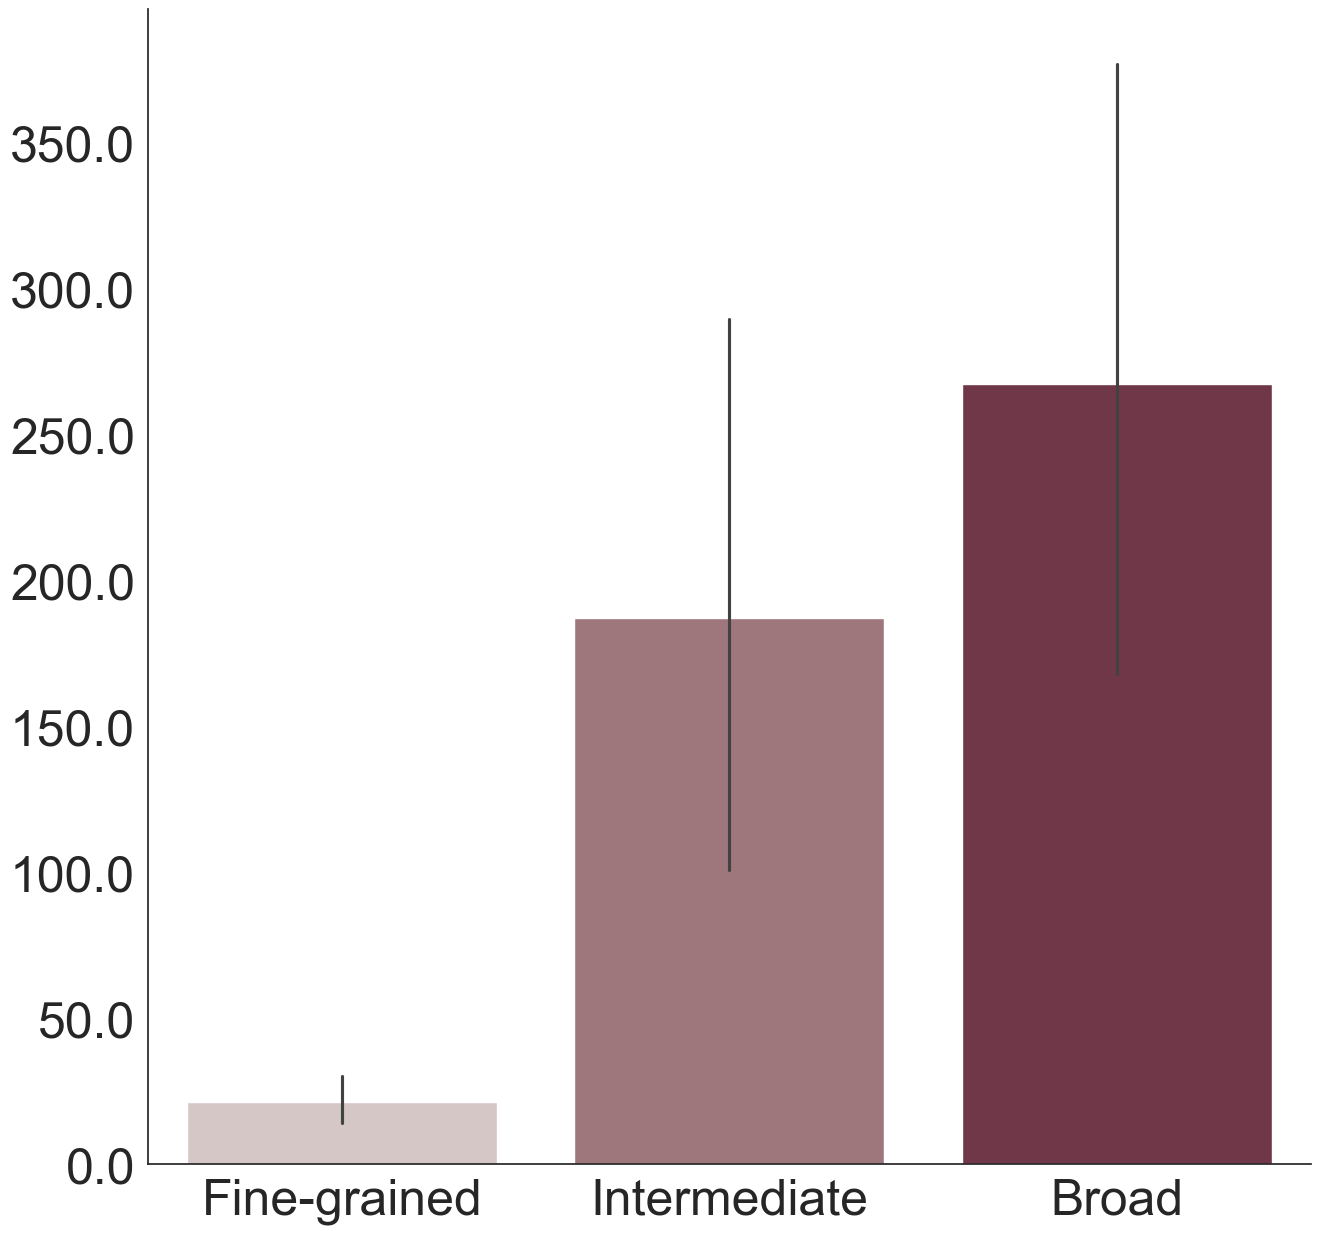

In [80]:
column_names = ["Exposure size", "louvain Iteration"]
labels=['Fine-grained','Intermediate','Broad']
exposuresize_list_tot=[]
group_list=[]
for i in fine_grained_communities_community_size:
    exposuresize_list_tot.append(i)
    group_list.append("Fine-grained")
    
for i in middle_communities_community_size:
    exposuresize_list_tot.append(i)
    group_list.append("Intermediate")

for i in broad_communities_community_size:
    exposuresize_list_tot.append(i)
    group_list.append("Broad")
    
EEN_louvain_com_df = pd.DataFrame(columns = column_names)
EEN_louvain_com_df["Exposure size"]=exposuresize_list_tot
EEN_louvain_com_df["Louvain Iteration"]=group_list

import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 15))
sns.set(style="white")


ax = sns.barplot(x="Louvain Iteration", y="Exposure size", data=EEN_louvain_com_df, estimator=np.mean,
                 palette=['#D8C4C5','#A47179','#7A2D45'])

ax.set_xlabel("",fontsize=32)
ax.set_ylabel("",fontsize=32)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_yticklabels(ax.get_yticks(), size = 36)
ax.set_xticklabels(labels, size = 36)
#plt.savefig('output/Figures/SF4A_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()

In [81]:
# Build dataframe exactly matching what is plotted
EEN_louvain_com_df = pd.DataFrame({
    "Exposure_size": exposuresize_list_tot,
    "Louvain_iteration": group_list
})

In [82]:
excel_path = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(
        excel_path,
        engine="openpyxl",
        mode="a",
        if_sheet_exists="new"
    ) as writer:

    EEN_louvain_com_df.to_excel(
        writer,
        sheet_name="SF7A",
        index=False
    )

print("Source data appended for Louvain community size barplot.")

Source data appended for Louvain community size barplot.


In [25]:
#Now, we will provide a biological characterization via enrichment analysis

#These analyses are performed in the cluster and described in the file CTD_Louvain_partial_rankedgsea.py

#I will describe the key steps also here

In [174]:
for com, explsit in fine_grained_communities_dict.items():
    if 'D000078306' in explsit:
        print(com,explsit)


11_2_1 ['D000077583', 'C031942', 'D000078306', 'C534342', 'C083544', 'C109573', 'C109079', 'C060980', 'C037178', 'C021129', 'C524038', 'C426686', 'D009652', 'D003277', 'D017985', 'D006629', 'D007485', 'C503991', 'C503992', 'C006871', 'C060974']


In [294]:
len(fine_grained_communities_dict['11_2_1'])

21

In [296]:
for chem in fine_grained_communities_dict['11_2_1']:
    print(chem_gene_cleaned[chem])

{'F5', 'CYP2J2', 'EDN1', 'SLC15A2', 'ACE', 'SLC15A1', 'F2'}
{'F2'}
{'F2', 'SERPINC1', 'SELE'}
{'F2'}
{'F2'}
{'F2'}
{'F2', 'F7', 'THBD', 'PROS1'}
{'F2'}
{'F2'}
{'F2'}
{'F2'}
{'F2'}
{'F5'}
{'SERPINC1', 'FSHB', 'LHB', 'F2', 'SHBG', 'PLG'}
{'F2', 'SERPINC1'}
{'CGB3', 'F2', 'MPO'}
{'F2', 'SERPINC1'}
{'F2', 'TBXA2R', 'SERPIND1'}
{'F2', 'TBXA2R', 'SERPIND1'}
{'SERPINC1'}
{'P2RY12', 'GP5', 'SYK', 'GP9', 'F2', 'VWF', 'GP1BA'}


In [295]:
for chem in fine_grained_communities_dict['11_2_1']:
    print(chem_name_id_conversion[chem])

Quinapril
argatroban
Clobazam
drospirenone and ethinyl estradiol combination
lepirudin
melagatran
norgestimate, ethinyl estradiol drug combination
phosphatidylinositol 3,4-diphosphate
phosphatidylinositol 4-phosphate
S 2238
variegin protein, Amblyomma variegatum
ximelagatran
Norpregnenes
Contraceptives, Oral, Combined
Dalteparin
Hirudins
Ioxaglic Acid
quercetin 3,7,3',4'-tetrasulfate
quercetin 3-acetyl-7,3',4'-trisulfate
calcium heparin
phosphatidylinositol 3,4,5-triphosphate


In [ ]:
#argatroban a direct thrombin inhibitor 
#melagatran a direct thrombin inhibitor 
#ximelagatran a direct thrombin inhibitor 
#lepirudin  a direct thrombin inhibitor 
#variegin protein, Amblyomma variegatum a direct thrombin inhibitor 

#drospirenone and ethinyl estradiol combination
#norgestimate, ethinyl estradiol drug combination
#Norpregnenes
#Contraceptives, Oral, Combined

#Dalteparin
#calcium heparin
#Ioxaglic Acid


#S 2238 is a chromogenic substrate used primarily in assays to measure thrombin activity

#Hirudins is an anticoagulant found in the salivary glands of the medicinal leech

In [175]:
for com, explsit in middle_communities_dict.items():
    if 'D000078306' in explsit:
        print(com,explsit)

11_2 ['C048336', 'C499730', 'C059356', 'C016391', 'C455846', 'C582521', 'C000628644', 'C521094', 'C015157', 'D009841', 'C020924', 'C522992', 'C070441', 'C021096', 'C033706', 'C045816', 'C489138', 'C031709', 'C011686', 'C000603178', 'C116108', 'C076159', 'C073225', 'C013813', 'C079693', 'C517733', 'D003372', 'D003553', 'C049331', 'D000077583', 'C031942', 'D000078306', 'C534342', 'C083544', 'C109573', 'C109079', 'C060980', 'C037178', 'C021129', 'C524038', 'C426686', 'D009652', 'D003277', 'D017985', 'D006629', 'D007485', 'C503991', 'C503992', 'C006871', 'C060974', 'D000077206', 'C438607', 'C061388', 'C085075', 'C104980', 'D005275']


In [176]:
for com, explsit in broad_communities_dict.items():
    if 'D000078306' in explsit:
        print(com,explsit)

11 ['C048336', 'C499730', 'C059356', 'C016391', 'C455846', 'C582521', 'C000628644', 'C521094', 'C015157', 'D009841', 'C020924', 'C522992', 'C070441', 'C021096', 'C033706', 'C045816', 'C489138', 'C031709', 'C011686', 'C000603178', 'C116108', 'C076159', 'C073225', 'C013813', 'C079693', 'C517733', 'D003372', 'D003553', 'C049331', 'D000077583', 'C031942', 'D000078306', 'C534342', 'C083544', 'C109573', 'C109079', 'C060980', 'C037178', 'C021129', 'C524038', 'C426686', 'D009652', 'D003277', 'D017985', 'D006629', 'D007485', 'C503991', 'C503992', 'C006871', 'C060974', 'D000077206', 'C438607', 'C061388', 'C085075', 'C104980', 'D005275', 'D009579', 'C023891', 'C473625', 'C026942', 'C527068', 'C025225', 'C034047', 'C022894', 'C009502', 'C022895', 'C009503', 'C084991', 'C022893', 'C009504', 'C017245', 'C073050', 'C010030', 'C049587', 'D000092', 'C508261', 'C004468', 'C076950', 'D062365', 'C055871', 'C043466', 'D001970', 'C084817', 'D002723', 'C070620', 'C089548', 'C052629', 'C025390', 'C012891', 'C

In [268]:
for chem in broad_communities_dict['11']:
    print(chem_name_id_conversion[chem])

3-adenin-9-yl-2-hydroxypropanoic acid isobutyl ester
5,10,15,20-(etra(N-methyl-3-pyridyl))-26,28-diselenasapphyrin chloride
5-fluoropyrimidin-2-one beta-ribofuranoside
9-(2,3-dihydroxypropyl)adenine
aluminum citrate
(arginine)9-cysteinyl-glutaminyl-cysteinyl-arginyl-arginyl-lysyl-asparagine
(E)-2-((2-(benzo(d)thiazol-2-yl)hydrazono)methyl)-4-nitrophenol
N'-(10H-indolo(3,2-b)quinolin-11-yl)-N,N-dimethylpropane-1,3-diamine
N,N-dimethylaniline
Oligonucleotides
phenylalanyl-prolyl-arginine methyl chloride
pisosterol
pivalyloxymethyl butyrate
tetra(4-N-methylpyridyl)porphine
tiazofurin
arsenic trisulfide
1,3-benzothiazol-2-yl(2-((2-(3-pyridinyl)ethyl)amino)-4-pyrimidinyl)acetonitrile
2',3'-dideoxyguanosine 5'-triphosphate
boldine
G36 compound
N,N'-bis(2-1(piperidino)-ethyl)-3,4,9,10-perylene-tetracarboxylic diimide
2,3-dichloro-1-propanol
2-amino-4-methylphenol
4-anisidine
4-carboxyphenylglycine
chlorantranilipole
Coumaphos
Cystine
racecadotril
Quinapril
argatroban
Clobazam
drospirenone and

In [292]:
for k in middle_communities_dict.keys():
    if '11_' in k:
        print(k)

11_2
11_5
11_3
11_4
11_1


In [149]:

Louvain_fine_grained_df = pd.DataFrame.from_dict(fine_grained_communities_dict, orient='index').T
Louvain_middle_df = pd.DataFrame.from_dict(middle_communities_dict, orient='index').T
Louvain_broad_df = pd.DataFrame.from_dict(broad_communities_dict, orient='index').T

Louvain_fine_grained_df.to_csv("output/Louvain_fine_grained_df.tsv",sep="\t")
Louvain_middle_df.to_csv("output/Louvain_middle_df.tsv",sep="\t")
Louvain_broad_df.to_csv("output/Louvain_broad_df.tsv",sep="\t")

In [ ]:
#Let's read the annotations files
MF2023_gene_dict = read_gene_annotation("input/Libraries/GO_Molecular_Function_2023.txt")
CC2023_gene_dict = read_gene_annotation("input/Libraries/GO_Cellular_Component_2023.txt")
BP2023_gene_dict = read_gene_annotation("input/Libraries/GO_Biological_Process_2023.txt")
Reactome2024_gene_dict = read_gene_annotation("input/Libraries/Reactome_Pathways_2024.txt")

In [ ]:
tot_gene_annotation_dict = {**MF2023_gene_dict, **CC2023_gene_dict, **BP2023_gene_dict, **Reactome2024_gene_dict}

In [ ]:
genetic_background = set([x for xs in list(tot_gene_annotation_dict.values()) for x in xs]).union(set([x for xs in list(chem_gene_cleaned.values()) for x in xs]))


In [ ]:
# Open a file in write mode ('w')
with open('input/Libraries/genetic_background.txt', 'w') as file:
    # Write each element of the list to the file, one per line
    for item in list(genetic_background):
        file.write(f"{item}\n")  # Each element followed by a newline

In [ ]:
with open('output/Communities/Louvain/weighted_ji_fine_grained_communities_dict.pickle', 'rb') as handle:
    ee_first_louvain_iteration_exposures = pk.load(handle)

with open('output/Communities/Louvain/weighted_ji_middle_communities_dict.pickle', 'rb') as handle:
    ee_second_louvain_iteration_exposures = pk.load(handle)

with open('output/Communities/Louvain/weighted_ji_broad_communities_dict.pickle', 'rb') as handle:
    ee_third_louvain_iteration_exposures = pk.load(handle)


In [ ]:

#I consider a pre-rank for making a choice on the gene cutoff
#defining for each comunity a set of genes that is well-representative of each cluster
from collections import Counter
pre_rank_first_louvain_cluster_genelist={}
for com,explist in ee_first_louvain_iteration_exposures.items():
    gene_list=[]
    rank_genelist=[]
    if len(explist)>1:
        G_sub = nx.subgraph(backbone_ss_exposure_network,explist)   #let's create the subgraph corresponding to the cluster
        for edge in G_sub.edges():
            overlap_geneset=chem_gene_cleaned[edge[0]] & chem_gene_cleaned[edge[1]]
            for gene in overlap_geneset:
                gene_list.append(gene)
        count_dict=Counter(gene_list)
        for gene in set(gene_list):
            rank_genelist.append([gene,count_dict[gene]])
    else:
        for gene in chem_gene_cleaned[explist[0]]:
            rank_genelist.append([gene,1])
    pre_rank_first_louvain_cluster_genelist[com]=rank_genelist

pre_rank_first_louvain_cluster_genelist_df={}
for com,genelist in pre_rank_first_louvain_cluster_genelist.items():
    rank_df=pd.DataFrame(columns=('gene', 'rank'))
    for n in range(len(genelist)):
        rank_df.loc[n] = [genelist[n][0], float(genelist[n][1])]
    rank_df=rank_df.sort_values(by=['rank'],ascending=False)
    pre_rank_first_louvain_cluster_genelist_df[com]=rank_df

pre_rank_second_louvain_cluster_genelist={}
for com,explist in ee_second_louvain_iteration_exposures.items():
    gene_list=[]
    rank_genelist=[]
    if len(explist)>1:
        G_sub = nx.subgraph(backbone_ss_exposure_network,explist)   #let's create the subgraph corresponding to the cluster
        for edge in G_sub.edges():
            overlap_geneset=chem_gene_cleaned[edge[0]] & chem_gene_cleaned[edge[1]]
            for gene in overlap_geneset:
                gene_list.append(gene)
        count_dict=Counter(gene_list)
        for gene in set(gene_list):
            rank_genelist.append([gene,count_dict[gene]])
    else:
        for gene in chem_gene_cleaned[explist[0]]:
            rank_genelist.append([gene,1])
    pre_rank_second_louvain_cluster_genelist[com]=rank_genelist

pre_rank_second_louvain_cluster_genelist_df={}
for com,genelist in pre_rank_second_louvain_cluster_genelist.items():
    rank_df=pd.DataFrame(columns=('gene', 'rank'))
    for n in range(len(genelist)):
        rank_df.loc[n] = [genelist[n][0], float(genelist[n][1])]
    rank_df=rank_df.sort_values(by=['rank'],ascending=False)
    pre_rank_second_louvain_cluster_genelist_df[com]=rank_df

pre_rank_third_louvain_cluster_genelist={}
for com,explist in ee_third_louvain_iteration_exposures.items():
    gene_list=[]
    rank_genelist=[]
    if len(explist)>1:
        G_sub = nx.subgraph(backbone_ss_exposure_network,explist)   #let's create the subgraph corresponding to the cluster
        for edge in G_sub.edges():
            overlap_geneset=chem_gene_cleaned[edge[0]] & chem_gene_cleaned[edge[1]]
            for gene in overlap_geneset:
                gene_list.append(gene)
        count_dict=Counter(gene_list)
        for gene in set(gene_list):
            rank_genelist.append([gene,count_dict[gene]])
    else:
        for gene in chem_gene_cleaned[explist[0]]:
            rank_genelist.append([gene,1])
    pre_rank_third_louvain_cluster_genelist[com]=rank_genelist

pre_rank_third_louvain_cluster_genelist_df={}
for com,genelist in pre_rank_third_louvain_cluster_genelist.items():
    rank_df=pd.DataFrame(columns=('gene', 'rank'))
    for n in range(len(genelist)):
        rank_df.loc[n] = [genelist[n][0], float(genelist[n][1])]
    rank_df=rank_df.sort_values(by=['rank'],ascending=False)
    pre_rank_third_louvain_cluster_genelist_df[com]=rank_df


In [ ]:
#Let's associate for each community the most meaningful genes (those communities associated with more than 20 genes, we will use the leading genes of the ranked enrichment by frequency)
#First louvain interation
#Now we will run the traditional enrichment analysis for (Fisher's exact test + BH correction for those communties
#that perturb less than 20 genes, otherwise we will collect the leading genes from the GSEA with ranking
#and then performing again a traditional enrichment analysis

first_louvain_cluster_genes = {}
second_louvain_cluster_genes = {}
third_louvain_cluster_genes = {}

for com in list(pre_rank_first_louvain_cluster_genelist_df.keys()):
    num_of_genes=len(pre_rank_first_louvain_cluster_genelist_df[com])
    if num_of_genes>20:
        try:
            lead_genelist = list(enr_ranking_leading_genes(pre_rank_first_louvain_cluster_genelist_df[com],library_list))
            first_louvain_cluster_genes[com] = lead_genelist
        except:
            first_louvain_cluster_genes[com] = list(pre_rank_first_louvain_cluster_genelist_df[com]["gene"])
    else:
        first_louvain_cluster_genes[com] = list(pre_rank_first_louvain_cluster_genelist_df[com]["gene"])

#Second louvain interation
for com in list(pre_rank_second_louvain_cluster_genelist_df.keys()):
    num_of_genes=len(pre_rank_second_louvain_cluster_genelist_df[com])
    if num_of_genes>20:
        try:
            lead_genelist = list(enr_ranking_leading_genes(pre_rank_second_louvain_cluster_genelist_df[com],library_list))
            second_louvain_cluster_genes[com] = lead_genelist
        except:
            second_louvain_cluster_genes[com] = list(pre_rank_second_louvain_cluster_genelist_df[com]["gene"])
    else:
        second_louvain_cluster_genes[com] = list(pre_rank_second_louvain_cluster_genelist_df[com]["gene"])
        
#Third louvain interation
for com in list(pre_rank_third_louvain_cluster_genelist_df.keys()):
    num_of_genes=len(pre_rank_third_louvain_cluster_genelist_df[com])
    if num_of_genes>20:
        try:
            lead_genelist = list(enr_ranking_leading_genes(pre_rank_third_louvain_cluster_genelist_df[com],library_list))
            third_louvain_cluster_genes[com] = lead_genelist
        except:
            third_louvain_cluster_genes[com] = list(pre_rank_third_louvain_cluster_genelist_df[com]["gene"])
    else:
        third_louvain_cluster_genes[com] = list(pre_rank_third_louvain_cluster_genelist_df[com]["gene"])

        

In [ ]:
import json
# Save the JSON data to a file
with open("output/Communities/Louvain/first_louvain_cluster_genes.json", "w") as f:
    json.dump(first_louvain_cluster_genes, f)
with open("output/Communities/Louvain/second_louvain_cluster_genes.json", "w") as f:
    json.dump(second_louvain_cluster_genes, f)
with open("output/Communities/Louvain/third_louvain_cluster_genes.json", "w") as f:
    json.dump(third_louvain_cluster_genes, f)

In [ ]:
#Let's save the genelist extracted for the example shown in Fig. 2
# Open a file in write mode ('w')
with open('output/Communities/Louvain/11_2_1_genelist.txt', 'w') as file:
    # Write each element of the list to the file, one per line
    for item in list(pre_rank_first_louvain_cluster_genelist_df["11_2_1"]["gene"]):
        file.write(f"{item}\n")  # Each element followed by a newline

# Open a file in write mode ('w')
with open('output/Communities/Louvain/11_2_genelist.txt', 'w') as file:
    # Write each element of the list to the file, one per line
    for item in list(pre_rank_second_louvain_cluster_genelist_df["11_2"]["gene"]):
        file.write(f"{item}\n")  # Each element followed by a newline

# Open a file in write mode ('w')
with open('output/Communities/Louvain/11_2_genelist.txt', 'w') as file:
    # Write each element of the list to the file, one per line
    for item in list(pre_rank_second_louvain_cluster_genelist_df["11_2"]["gene"]):
        file.write(f"{item}\n")  # Each element followed by a newline

In [ ]:
#The Enrichment analysis is performed in the R notebooks Louvain_GO_ORA and Louvain_Reactome_ORA. Here, we import the results

In [5]:
first_louvain_ora_dict = read_json_to_dict("output/Communities/Louvain/first_louvain_ora_dict.json")
second_louvain_ora_dict = read_json_to_dict("output/Communities/Louvain/second_louvain_cluster_ora_dict.json")
third_louvain_ora_dict = read_json_to_dict("output/Communities/Louvain/third_louvain_cluster_ora_dict.json")

first_louvain_ora_reactome_dict = read_json_to_dict("output/Communities/Louvain/first_louvain_ora_reactome_dict.json")
second_louvain_ora_reactome_dict = read_json_to_dict("output/Communities/Louvain/second_louvain_cluster_ora_reactome_dict.json")
third_louvain_ora_reactome_dict = read_json_to_dict("output/Communities/Louvain/third_louvain_cluster_ora_reactome_dict.json")


In [6]:

sig_enr_GOBP_third_louvain_ora_dict = {}
sig_enr_GOMF_third_louvain_ora_dict = {}
sig_enr_GOCC_third_louvain_ora_dict = {}
for com,enr_df in third_louvain_ora_dict.items():
    gobp_list = []
    gomf_list = []
    gocc_list = []
    for i,v in enr_df.iterrows():
        if v["FDR"] < 0.05:
            term = v["Description"]
            if "GOBP" in term:
                gobp_list.append(term)
            elif "GOMF" in term:
                gomf_list.append(term)
            elif "GOCC" in term:
                gocc_list.append(term)
    sig_enr_GOBP_third_louvain_ora_dict[com] = gobp_list
    sig_enr_GOMF_third_louvain_ora_dict[com] = gomf_list
    sig_enr_GOCC_third_louvain_ora_dict[com] = gocc_list

sig_enr_GOBP_second_louvain_ora_dict = {}
sig_enr_GOMF_second_louvain_ora_dict = {}
sig_enr_GOCC_second_louvain_ora_dict = {}
for com,enr_df in second_louvain_ora_dict.items():
    gobp_list = []
    gomf_list = []
    gocc_list = []
    for i,v in enr_df.iterrows():
        if v["FDR"] < 0.05:
            term = v["Description"]
            if "GOBP" in term:
                gobp_list.append(term)
            elif "GOMF" in term:
                gomf_list.append(term)
            elif "GOCC" in term:
                gocc_list.append(term)
    sig_enr_GOBP_second_louvain_ora_dict[com] = gobp_list
    sig_enr_GOMF_second_louvain_ora_dict[com] = gomf_list
    sig_enr_GOCC_second_louvain_ora_dict[com] = gocc_list

sig_enr_GOBP_first_louvain_ora_dict = {}
sig_enr_GOMF_first_louvain_ora_dict = {}
sig_enr_GOCC_first_louvain_ora_dict = {}
for com,enr_df in first_louvain_ora_dict.items():
    gobp_list = []
    gomf_list = []
    gocc_list = []
    for i,v in enr_df.iterrows():
        if v["FDR"] < 0.05:
            term = v["Description"]
            if "GOBP" in term:
                gobp_list.append(term)
            elif "GOMF" in term:
                gomf_list.append(term)
            elif "GOCC" in term:
                gocc_list.append(term)
    sig_enr_GOBP_first_louvain_ora_dict[com] = gobp_list
    sig_enr_GOMF_first_louvain_ora_dict[com] = gomf_list
    sig_enr_GOCC_first_louvain_ora_dict[com] = gocc_list


sig_enr_reactome_third_louvain_ora_dict = {}
for com,enr_df in third_louvain_ora_reactome_dict.items():
    sig_term_list = enr_df[enr_df["FDR"]<0.05]["Description"].tolist()
    sig_enr_reactome_third_louvain_ora_dict[com] = sig_term_list

sig_enr_reactome_second_louvain_ora_dict = {}
for com,enr_df in second_louvain_ora_reactome_dict.items():
    sig_term_list = enr_df[enr_df["FDR"]<0.05]["Description"].tolist()
    sig_enr_reactome_second_louvain_ora_dict[com] = sig_term_list

sig_enr_reactome_first_louvain_ora_dict = {}
for com,enr_df in first_louvain_ora_reactome_dict.items():
    try:
        sig_term_list = enr_df[enr_df["FDR"]<0.05]["Description"].tolist()
        sig_enr_reactome_first_louvain_ora_dict[com] = sig_term_list
    except:
        sig_enr_reactome_first_louvain_ora_dict[com] = []


In [7]:
broad_sig_enr_df = pd.DataFrame()
lib_list = []
com_list = []
enr_list = []
fdr_list = []
for com,enr_df in third_louvain_ora_dict.items():
    for i,v in enr_df.iterrows():
        if v["FDR"] < 0.05:
            term = v["Description"]
            if "GOBP" in term:
                lib_list.append("GO BP")
                enr_list.append(term)
                com_list.append(com)
                fdr_list.append(v["FDR"])
            elif "GOMF" in term:
                lib_list.append("GO MF")
                enr_list.append(term)
                com_list.append(com)
                fdr_list.append(v["FDR"])
            elif "GOCC" in term:
                lib_list.append("GO CC")
                enr_list.append(term)
                com_list.append(com)
                fdr_list.append(v["FDR"])


for com,enr_df in third_louvain_ora_reactome_dict.items():
    for i,v in enr_df.iterrows():
        if v["FDR"] < 0.05:
            term = v["Description"]
            lib_list.append("Reactome")
            enr_list.append(term)
            com_list.append(com)
            fdr_list.append(v["FDR"])


broad_sig_enr_df["Library"] = lib_list
broad_sig_enr_df["Community"] = com_list
broad_sig_enr_df["Terms"] = enr_list
broad_sig_enr_df["FDR"] = fdr_list


In [8]:
middle_sig_enr_df = pd.DataFrame()
lib_list = []
com_list = []
enr_list = []
fdr_list = []
for com,enr_df in second_louvain_ora_dict.items():
    for i,v in enr_df.iterrows():
        if v["FDR"] < 0.05:
            term = v["Description"]
            if "GOBP" in term:
                lib_list.append("GO BP")
                enr_list.append(term)
                com_list.append(com)
                fdr_list.append(str(v["FDR"]))
            elif "GOMF" in term:
                lib_list.append("GO MF")
                enr_list.append(term)
                com_list.append(com)
                fdr_list.append(str(v["FDR"]))
            elif "GOCC" in term:
                lib_list.append("GO CC")
                enr_list.append(term)
                com_list.append(com)
                fdr_list.append(str(v["FDR"]))


for com,enr_df in second_louvain_ora_reactome_dict.items():
    for i,v in enr_df.iterrows():
        if v["FDR"] < 0.05:
            term = v["Description"]
            lib_list.append("Reactome")
            enr_list.append(term)
            com_list.append(com)
            fdr_list.append(str(v["FDR"]))


middle_sig_enr_df["Library"] = lib_list
middle_sig_enr_df["Community"] = com_list
middle_sig_enr_df["Terms"] = enr_list
middle_sig_enr_df["FDR"] = fdr_list


In [9]:
fine_sig_enr_df = pd.DataFrame()
lib_list = []
com_list = []
enr_list = []
fdr_list = []
for com,enr_df in first_louvain_ora_dict.items():
    for i,v in enr_df.iterrows():
        if v["FDR"] < 0.05:
            term = v["Description"]
            if "GOBP" in term:
                lib_list.append("GO BP")
                enr_list.append(term)
                com_list.append(com)
                fdr_list.append(str(v["FDR"]))
            elif "GOMF" in term:
                lib_list.append("GO MF")
                enr_list.append(term)
                com_list.append(com)
                fdr_list.append(str(v["FDR"]))
            elif "GOCC" in term:
                lib_list.append("GO CC")
                enr_list.append(term)
                com_list.append(com)
                fdr_list.append(str(v["FDR"]))


for com,enr_df in first_louvain_ora_reactome_dict.items():
    for i,v in enr_df.iterrows():
        if v["FDR"] < 0.05:
            term = v["Description"]
            lib_list.append("Reactome")
            enr_list.append(term)
            com_list.append(com)
            fdr_list.append(str(v["FDR"]))


fine_sig_enr_df["Library"] = lib_list
fine_sig_enr_df["Community"] = com_list
fine_sig_enr_df["Terms"] = enr_list
fine_sig_enr_df["FDR"] = fdr_list


/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_4312/4202802399.py:86: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size=36)


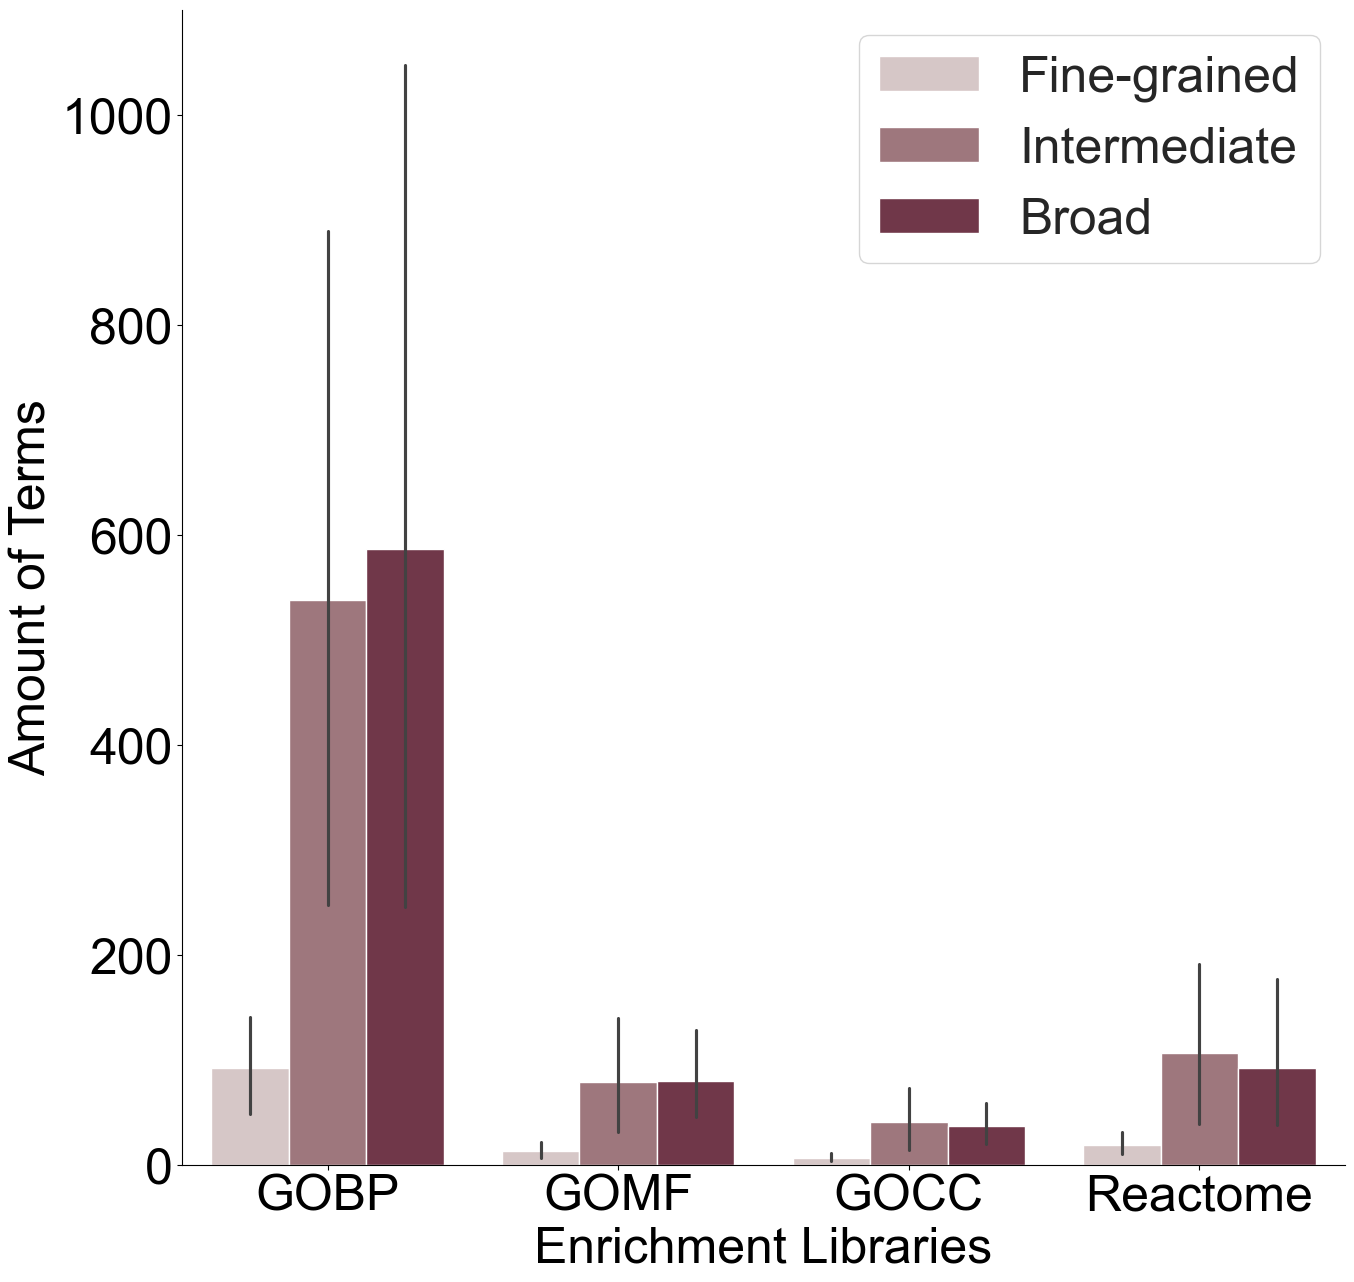

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

go_com_df=pd.DataFrame()

status_list=[]
num_terms_list=[]
level_list=[]

for com,enr_list in sig_enr_GOBP_first_louvain_ora_dict.items():
    status_list.append("GOBP")
    num_terms_list.append(len(enr_list))
    level_list.append("Fine-grained")
    
for com,enr_list in sig_enr_GOMF_first_louvain_ora_dict.items():
    status_list.append("GOMF")
    num_terms_list.append(len(enr_list))
    level_list.append("Fine-grained")
    
for com,enr_list in sig_enr_GOCC_first_louvain_ora_dict.items():
    status_list.append("GOCC")
    num_terms_list.append(len(enr_list))
    level_list.append("Fine-grained")
    
for com,enr_list in sig_enr_reactome_first_louvain_ora_dict.items():
    status_list.append("Reactome")
    num_terms_list.append(len(enr_list))
    level_list.append("Fine-grained")

for com,enr_list in sig_enr_GOBP_second_louvain_ora_dict.items():
    status_list.append("GOBP")
    num_terms_list.append(len(enr_list))
    level_list.append("Intermediate")
    
for com,enr_list in sig_enr_GOMF_second_louvain_ora_dict.items():
    status_list.append("GOMF")
    num_terms_list.append(len(enr_list))
    level_list.append("Intermediate")
    
for com,enr_list in sig_enr_GOCC_second_louvain_ora_dict.items():
    status_list.append("GOCC")
    num_terms_list.append(len(enr_list))
    level_list.append("Intermediate")
    
for com,enr_list in sig_enr_reactome_second_louvain_ora_dict.items():
    status_list.append("Reactome")
    num_terms_list.append(len(enr_list))
    level_list.append("Intermediate")

for com,enr_list in sig_enr_GOBP_third_louvain_ora_dict.items():
    status_list.append("GOBP")
    num_terms_list.append(len(enr_list))
    level_list.append("Broad")
    
for com,enr_list in sig_enr_GOMF_third_louvain_ora_dict.items():
    status_list.append("GOMF")
    num_terms_list.append(len(enr_list))
    level_list.append("Broad")
    
for com,enr_list in sig_enr_GOCC_third_louvain_ora_dict.items():
    status_list.append("GOCC")
    num_terms_list.append(len(enr_list))
    level_list.append("Broad")
    
for com,enr_list in sig_enr_reactome_third_louvain_ora_dict.items():
    status_list.append("Reactome")
    num_terms_list.append(len(enr_list))
    level_list.append("Broad")


go_com_df['Status']=status_list
go_com_df['Enriched Terms']=num_terms_list
go_com_df['Hierarchy']=level_list


# Create a boxplot using seaborn
fig, ax = plt.subplots(figsize=(15, 15))
sns.set(style="white")

g=sns.barplot(x='Status', y='Enriched Terms', hue='Hierarchy', estimator='mean',palette=['#D8C4C5','#A47179','#7A2D45'],data=go_com_df)
#g.set_yscale("log")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size=36)
plt.xticks(fontsize=36)

plt.xlabel('Enrichment Libraries', fontsize=36)
plt.ylabel('Amount of Terms', fontsize=36)
plt.legend(fontsize=36)
#plt.savefig('output/Figures/Fig2D_v01_post_rev.pdf', format='pdf', dpi=300, bbox_inches="tight")
plt.show()

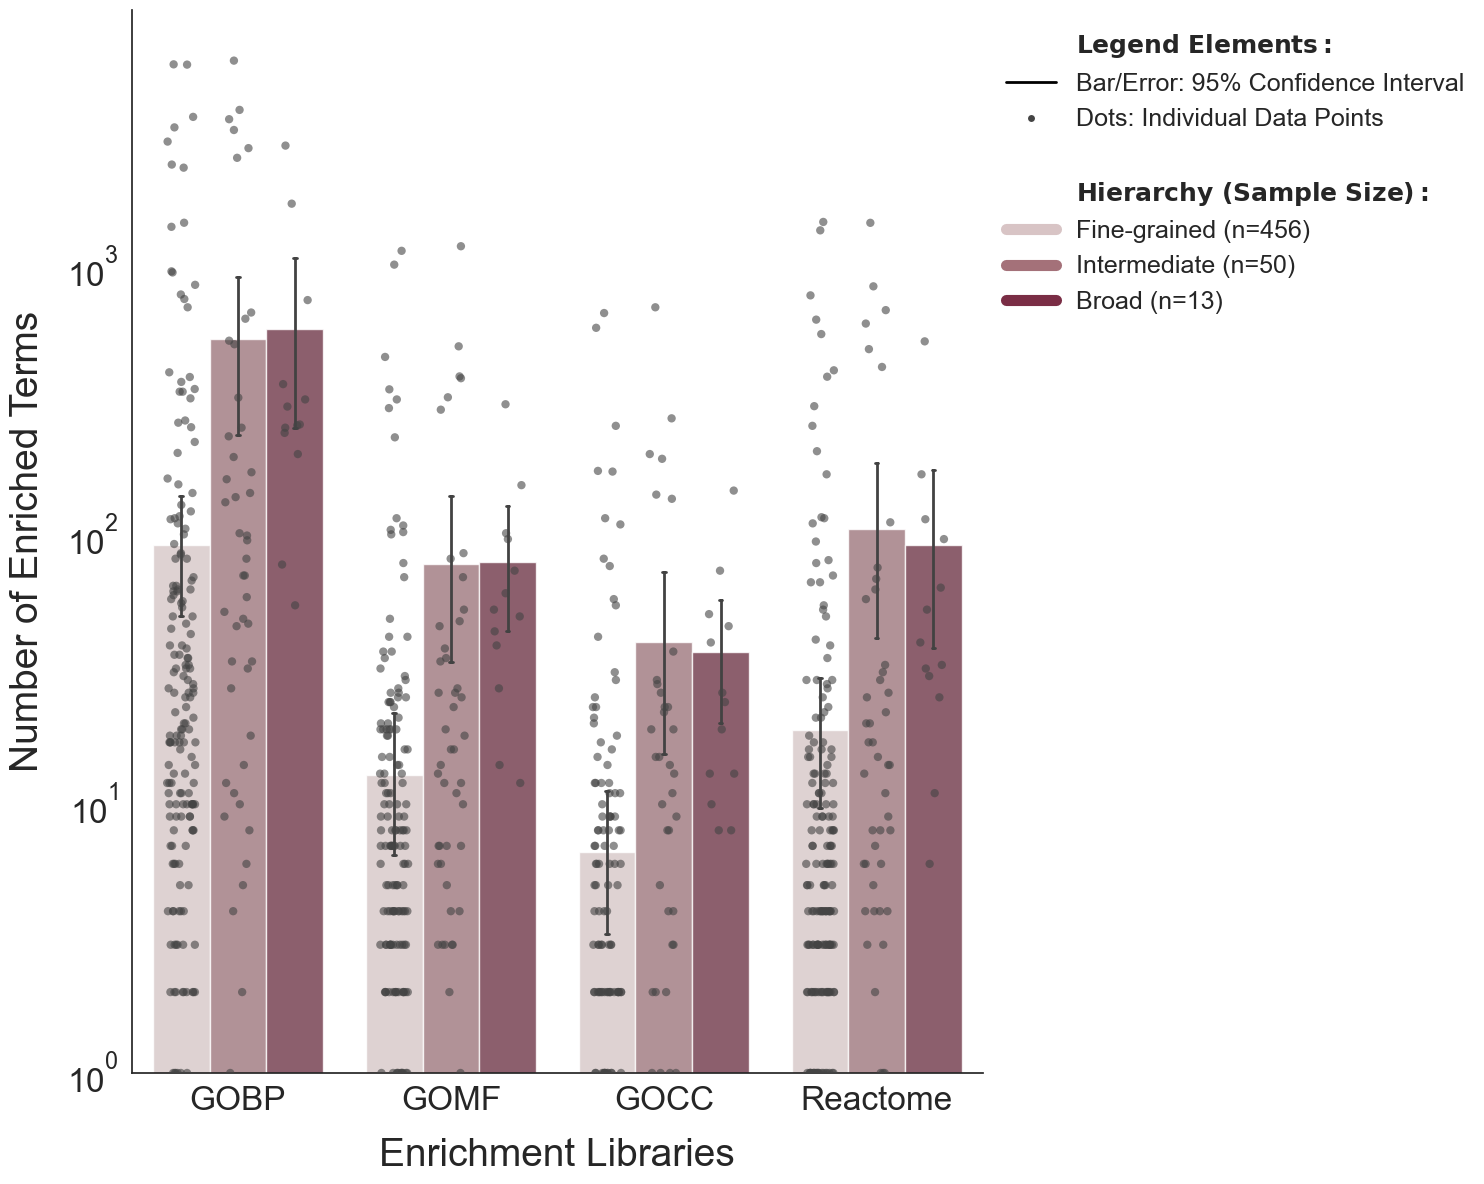

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 1. Prepare Data
go_com_df = pd.DataFrame({
    "Status": status_list,
    "Enriched Terms": num_terms_list,
    "Hierarchy": level_list
})

# 2. Pre-calculate N-counts for the Legend
n_counts = go_com_df.groupby(['Hierarchy', 'Status']).size().unstack()
# Create new labels for the Legend that include N (e.g., "Fine-grained (n=12-45)")
# Note: Since N might vary across Status for the same Hierarchy, we show the range
new_labels = []
for h in ["Fine-grained", "Intermediate", "Broad"]:
    counts = go_com_df[go_com_df['Hierarchy'] == h].groupby('Status').size()
    n_min, n_max = counts.min(), counts.max()
    n_str = f"n={n_min}" if n_min == n_max else f"n={n_min}-{n_max}"
    new_labels.append(f"{h} ({n_str})")

# 3. Setup Plot
fig, ax = plt.subplots(figsize=(15, 12))
sns.set_style("white")

palette_colors = ['#D8C4C5','#A47179','#7A2D45']

# ---- BARPLOT ----
# We use alpha=0.7 to make the bars slightly transparent so dots stand out
sns.barplot(
    data=go_com_df, x='Status', y='Enriched Terms', hue='Hierarchy',
    estimator=np.mean, errorbar=('ci', 95), palette=palette_colors,
    capsize=0.05, err_kws={'linewidth': 2}, alpha=0.8, ax=ax
)

# ---- OVERLAY DATA POINTS ----
# Using stripplot instead of swarmplot for better alignment on log scales
sns.stripplot(
    data=go_com_df, x='Status', y='Enriched Terms', hue='Hierarchy',
    dodge=True, palette=['#444444']*3, # Dark grey for contrast
    size=6, jitter=0.2, alpha=0.6, ax=ax, legend=False
)

# 4. Refine Log Scale
ax.set_yscale("log")
ax.set_ylim(bottom=1) # Log bars must start at 1 (10^0)

# 5. Legend & Journal Compliance Text
# Define the bars and error bars for the legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='none', label=r'$\mathbf{Legend\ Elements:}$'),
    Line2D([0], [0], color='black', lw=2, label="Bar/Error: 95% Confidence Interval"),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#444444', label='Dots: Individual Data Points'),
    Line2D([0], [0], color='none', label=''), # Spacer
    Line2D([0], [0], color='none', label=r'$\mathbf{Hierarchy\ (Sample\ Size):}$')
]

# Add the Hierarchy colors and N-counts
for color, label in zip(palette_colors, new_labels):
    legend_elements.append(Line2D([0], [0], color=color, lw=8, label=label))

ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1), 
          fontsize=18, frameon=False)

# 6. Final Styling
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.xlabel('Enrichment Libraries', fontsize=28, labelpad=15)
plt.ylabel('Number of Enriched Terms', fontsize=28, labelpad=15)

plt.tight_layout()
plt.savefig('output/Figures/Fig2D_v04.svg', format='svg', dpi=300, bbox_inches="tight")
plt.savefig('output/Figures/Fig2D_v04.pdf', format='pdf', dpi=300, bbox_inches="tight")
plt.show()

In [12]:


# Append to your existing SourceData Excel
excel_path = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(
        excel_path,
        engine="openpyxl",
        mode="a",
        if_sheet_exists="replace"
    ) as writer:
    go_com_df.to_excel(
        writer,
        sheet_name="Fig2D",
        index=False
    )

In [ ]:
#Here, we will define a funnction that calculates the lcc for each set of terms in the GO tree to check for the 
#cohesiveness of the enrichment terms in each community
def lcc_significance(term_list,network):
    import random as rd
    import numpy as np
    z='nan'
    if len(set(term_list))>1:
        try:
            G_sub = nx.subgraph(network,term_list)
            G_sub_lcc = G_sub.subgraph(max(nx.connected_components(G_sub), key=len))  # extract lcc graph
            f_lcc_size = G_sub_lcc.number_of_nodes()
        except:
            f_lcc_size = 1
            
        l_random_lccs = []

        S = 1000
        for s in range(S):
            term_sample = rd.sample(list(network.nodes()),len(set(term_list)))
            G_sub_rnd = nx.subgraph(network,term_sample)
            G_sub_rnd_lcc = G_sub_rnd.subgraph(max(nx.connected_components(G_sub_rnd), key=len))  # extract lcc graph
            lcc_size = G_sub_rnd_lcc.number_of_nodes()
            l_random_lccs.append(lcc_size)
        mu = np.mean(l_random_lccs)
        std = np.std(l_random_lccs)

        z = (f_lcc_size-mu)/std
    
    return z

In [ ]:
#https://www.gsea-msigdb.org/gsea/msigdb/human/collections.jsp#C5
#
#https://data.broadinstitute.org/gsea-msigdb/msigdb/release/2023.1.Hs/
import json

def read_json(json_file):
    with open(json_file, 'r') as f:
        data = json.load(f)
    return data

# Example usage:
json_file = 'input/Libraries/c5.go.v2023.1.Hs.json'
go_gsea_file = read_json(json_file)

go_match_id_dict = {}
for key,description_dict in go_gsea_file.items():
    up_key = key.replace("_"," ")
    go_match_id_dict[up_key]= description_dict["exactSource"]



In [ ]:
sig_enr_id_GOMF_third_louvain_ora_dict = {}
sig_enr_id_GOBP_third_louvain_ora_dict = {}
sig_enr_id_GOCC_third_louvain_ora_dict = {}

for com,enr_list in sig_enr_GOBP_third_louvain_ora_dict.items():
    n_term_list = []
    for t in enr_list:
        if t in go_match_id_dict:
            n_term_list.append(go_match_id_dict[t])
    sig_enr_id_GOBP_third_louvain_ora_dict[com] = n_term_list

for com,enr_list in sig_enr_GOMF_third_louvain_ora_dict.items():
    n_term_list = []
    for t in enr_list:
        if t in go_match_id_dict:
            n_term_list.append(go_match_id_dict[t])
    sig_enr_id_GOMF_third_louvain_ora_dict[com] = n_term_list

for com,enr_list in sig_enr_GOCC_third_louvain_ora_dict.items():
    n_term_list = []
    for t in enr_list:
        if t in go_match_id_dict:
            n_term_list.append(go_match_id_dict[t])
    sig_enr_id_GOCC_third_louvain_ora_dict[com] = n_term_list

sig_enr_id_GOMF_second_louvain_ora_dict = {}
sig_enr_id_GOBP_second_louvain_ora_dict = {}
sig_enr_id_GOCC_second_louvain_ora_dict = {}

for com,enr_list in sig_enr_GOBP_second_louvain_ora_dict.items():
    n_term_list = []
    for t in enr_list:
        if t in go_match_id_dict:
            n_term_list.append(go_match_id_dict[t])
    sig_enr_id_GOBP_second_louvain_ora_dict[com] = n_term_list

for com,enr_list in sig_enr_GOMF_second_louvain_ora_dict.items():
    n_term_list = []
    for t in enr_list:
        if t in go_match_id_dict:
            n_term_list.append(go_match_id_dict[t])
    sig_enr_id_GOMF_second_louvain_ora_dict[com] = n_term_list

for com,enr_list in sig_enr_GOCC_second_louvain_ora_dict.items():
    n_term_list = []
    for t in enr_list:
        if t in go_match_id_dict:
            n_term_list.append(go_match_id_dict[t])
    sig_enr_id_GOCC_second_louvain_ora_dict[com] = n_term_list


sig_enr_id_GOMF_first_louvain_ora_dict = {}
sig_enr_id_GOBP_first_louvain_ora_dict = {}
sig_enr_id_GOCC_first_louvain_ora_dict = {}

for com,enr_list in sig_enr_GOBP_first_louvain_ora_dict.items():
    n_term_list = []
    for t in enr_list:
        if t in go_match_id_dict:
            n_term_list.append(go_match_id_dict[t])
    sig_enr_id_GOBP_first_louvain_ora_dict[com] = n_term_list

for com,enr_list in sig_enr_GOMF_first_louvain_ora_dict.items():
    n_term_list = []
    for t in enr_list:
        if t in go_match_id_dict:
            n_term_list.append(go_match_id_dict[t])
    sig_enr_id_GOMF_first_louvain_ora_dict[com] = n_term_list

for com,enr_list in sig_enr_GOCC_first_louvain_ora_dict.items():
    n_term_list = []
    for t in enr_list:
        if t in go_match_id_dict:
            n_term_list.append(go_match_id_dict[t])
    sig_enr_id_GOCC_first_louvain_ora_dict[com] = n_term_list


In [ ]:

with open('output/Communities/Louvain/sig_enr_id_GOMF_third_louvain_ora_dict.pickle', 'wb') as handle:
    pk.dump(sig_enr_id_GOMF_third_louvain_ora_dict, handle, protocol=pk.HIGHEST_PROTOCOL)

with open('output/Communities/Louvain/sig_enr_id_GOBP_third_louvain_ora_dict.pickle', 'wb') as handle:
    pk.dump(sig_enr_id_GOBP_third_louvain_ora_dict, handle, protocol=pk.HIGHEST_PROTOCOL)
    
with open('output/Communities/Louvain/sig_enr_id_GOCC_third_louvain_ora_dict.pickle', 'wb') as handle:
    pk.dump(sig_enr_id_GOCC_third_louvain_ora_dict, handle, protocol=pk.HIGHEST_PROTOCOL)


with open('output/Communities/Louvain/sig_enr_id_GOMF_second_louvain_ora_dict.pickle', 'wb') as handle:
    pk.dump(sig_enr_id_GOMF_second_louvain_ora_dict, handle, protocol=pk.HIGHEST_PROTOCOL)

with open('output/Communities/Louvain/sig_enr_id_GOBP_second_louvain_ora_dict.pickle', 'wb') as handle:
    pk.dump(sig_enr_id_GOBP_second_louvain_ora_dict, handle, protocol=pk.HIGHEST_PROTOCOL)
    
with open('output/Communities/Louvain/sig_enr_id_GOCC_second_louvain_ora_dict.pickle', 'wb') as handle:
    pk.dump(sig_enr_id_GOCC_second_louvain_ora_dict, handle, protocol=pk.HIGHEST_PROTOCOL)


with open('output/Communities/Louvain/sig_enr_id_GOMF_first_louvain_ora_dict.pickle', 'wb') as handle:
    pk.dump(sig_enr_id_GOMF_first_louvain_ora_dict, handle, protocol=pk.HIGHEST_PROTOCOL)

with open('output/Communities/Louvain/sig_enr_id_GOBP_first_louvain_ora_dict.pickle', 'wb') as handle:
    pk.dump(sig_enr_id_GOBP_first_louvain_ora_dict, handle, protocol=pk.HIGHEST_PROTOCOL)
    
with open('output/Communities/Louvain/sig_enr_id_GOCC_first_louvain_ora_dict.pickle', 'wb') as handle:
    pk.dump(sig_enr_id_GOCC_first_louvain_ora_dict, handle, protocol=pk.HIGHEST_PROTOCOL)


In [ ]:
#Let's calculate the resnik in the Ontology tree 
#This step is performed in the Cluster


import pandas as pd
import networkx as nx
import numpy as np
import pickle as pk
import gseapy as gp
import re
import itertools as it
import math
from collections import (defaultdict,Counter)
import obonet




def precalc_lower_bounds(G):
    """Pre-calculate the number of lower bounds of the graph nodes
    """
    G.lower_bounds = Counter()
    for n in G:
        G.lower_bounds[n] += 1
        for ans in nx.ancestors(G, n):
            G.lower_bounds[ans] += 1
   # G.descriptors.add("Pre-calculated lower bounds")
#This function is the second step for the resnik score calculation
def information_content(G, term):
    """Information content
    Args:
        G(Ontology Graph): Ontology graph object
        term(str): ontolgy term
    Returns:
        str - Information content
    Raises:
        PGSSLookupError: The term was not found in Ontology Graph
        PGSSInvalidOperation: see `pygosemsim.similarity.precalc_lower_bounds`
    """
    if term not in G.lower_bounds:
        raise exception.PGSSLookupError(f"Missing term: {term}")
    freq = G.lower_bounds[term] / len(G)
    return round(-1 * math.log2(freq), 3)

#This function is the third step for the resnik score calculation
def lowest_common_ancestor(G, term1, term2):
    """Naive implementation of lowest common ancestor (LCA)
    Args:
        G(GoGraph): Graph object
        term1(str): Ontology term 1
        term2(str): Ontology term 2
    Returns:
        str - Lowest common ancestor term
        or None if the terms have no common ancestors
    Raises:
        PGSSLookupError: The term was not found in Ontology Graph
        PGSSInvalidOperation: see `pygosemsim.similarity.precalc_lower_bounds`
    """
    if term1 not in G:
        raise exception.PGSSLookupError(f"Missing term: {term1}")
    if term2 not in G:
        raise exception.PGSSLookupError(f"Missing term: {term2}")
    lb1 = nx.ancestors(G, term1) | {term1}
    lb2 = nx.ancestors(G, term2) | {term2}
    common_ans = lb1 & lb2
    if not common_ans:
        return
    return min(common_ans, key=lambda x: G.lower_bounds[x])

#This function would return the resnik score between two terms
def resnik(G, term1, term2):
    """Semantic similarity based on Resnik method
    Args:
        G(GoGraph): Ontology graph object
        term1(str): term 1
        term2(str): term 2
    Returns:
        float - Resnik similarity value (Information content of LCA)
        or None if the terms have no common ancestors
    Raises:
        PGSSLookupError: The term was not found in GoGraph
        PGSSInvalidOperation: see `pygosemsim.similarity.precalc_lower_bounds`
    """
    mica = lowest_common_ancestor(G, term1, term2)
    if mica is not None:
        return information_content(G, mica)



url = 'http://purl.obolibrary.org/obo/go.obo'
graph = obonet.read_obo(url)
graph_up = nx.DiGraph.reverse(graph)
precalc_lower_bounds(graph_up)
term_list=list(graph_up.nodes())
pairwise_list = list(it.combinations(term_list, 2))
GO_resnik={}
for pair in pairwise_list:
    try:
        try:
            GO_resnik[pair[0],pair[1]]=round(resnik(graph_up, pair[0], pair[1]),3)
        except:
            GO_resnik[pair[0],pair[1]]=round(resnik(graph_up, pair[1], pair[0]),3)
    except:
        pass

with open('intermediate/GO_resnik.pickle', 'wb') as handle:
    pk.dump(GO_resnik, handle, protocol=pk.HIGHEST_PROTOCOL)

In [ ]:
#Let's import the latest release of the GO ontology
import obonet

url = 'http://purl.obolibrary.org/obo/go.obo'
graph = obonet.read_obo(url)
graph_up = nx.DiGraph.reverse(graph)

In [ ]:
#BP
GOBP = graph_up.subgraph(list(nx.descendants(graph_up,'GO:0008150')))
GOBP_undirected=GOBP.to_undirected()
#MF
GOMF = graph_up.subgraph(list(nx.descendants(graph_up,'GO:0003674')))
GOMF_undirected=GOMF.to_undirected()
#CC
GOCC = graph_up.subgraph(list(nx.descendants(graph_up,'GO:0005575')))
GOCC_undirected=GOCC.to_undirected()

In [ ]:

sig_enr_GOBP_first_louvain_ora_lcc_zscore_dict = {}
for com,term_list in sig_enr_id_GOBP_first_louvain_ora_dict.items():
    sig_enr_GOBP_first_louvain_ora_lcc_zscore_dict[com]=lcc_significance(term_list,GOBP_undirected)

sig_enr_GOMF_first_louvain_ora_lcc_zscore_dict = {}
for com,term_list in sig_enr_id_GOMF_first_louvain_ora_dict.items():
    sig_enr_GOMF_first_louvain_ora_lcc_zscore_dict[com]=lcc_significance(term_list,GOMF_undirected)

sig_enr_GOCC_first_louvain_ora_lcc_zscore_dict = {}
for com,term_list in sig_enr_id_GOCC_first_louvain_ora_dict.items():
    sig_enr_GOCC_first_louvain_ora_lcc_zscore_dict[com]=lcc_significance(term_list,GOCC_undirected)

sig_enr_GOBP_second_louvain_ora_lcc_zscore_dict = {}
for com,term_list in sig_enr_id_GOBP_second_louvain_ora_dict.items():
    sig_enr_GOBP_second_louvain_ora_lcc_zscore_dict[com]=lcc_significance(term_list,GOBP_undirected)

sig_enr_GOMF_second_louvain_ora_lcc_zscore_dict = {}
for com,term_list in sig_enr_id_GOMF_second_louvain_ora_dict.items():
    sig_enr_GOMF_second_louvain_ora_lcc_zscore_dict[com]=lcc_significance(term_list,GOMF_undirected)

sig_enr_GOCC_second_louvain_ora_lcc_zscore_dict = {}
for com,term_list in sig_enr_id_GOCC_second_louvain_ora_dict.items():
    sig_enr_GOCC_second_louvain_ora_lcc_zscore_dict[com]=lcc_significance(term_list,GOCC_undirected)

sig_enr_GOBP_third_louvain_ora_lcc_zscore_dict = {}
for com,term_list in sig_enr_id_GOBP_third_louvain_ora_dict.items():
    sig_enr_GOBP_third_louvain_ora_lcc_zscore_dict[com]=lcc_significance(term_list,GOBP_undirected)

sig_enr_GOMF_third_louvain_ora_lcc_zscore_dict = {}
for com,term_list in sig_enr_id_GOMF_third_louvain_ora_dict.items():
    sig_enr_GOMF_third_louvain_ora_lcc_zscore_dict[com]=lcc_significance(term_list,GOMF_undirected)

sig_enr_GOCC_third_louvain_ora_lcc_zscore_dict = {}
for com,term_list in sig_enr_id_GOCC_third_louvain_ora_dict.items():
    sig_enr_GOCC_third_louvain_ora_lcc_zscore_dict[com]=lcc_significance(term_list,GOCC_undirected)
    

In [ ]:

with open('output/Communities/Louvain/sig_enr_GOBP_first_louvain_ora_lcc_zscore_dict.pickle', 'wb') as handle:
    pk.dump(sig_enr_GOBP_first_louvain_ora_lcc_zscore_dict, handle, protocol=pk.HIGHEST_PROTOCOL)

with open('output/Communities/Louvain/sig_enr_GOMF_first_louvain_ora_lcc_zscore_dict.pickle', 'wb') as handle:
    pk.dump(sig_enr_GOMF_first_louvain_ora_lcc_zscore_dict, handle, protocol=pk.HIGHEST_PROTOCOL)
    
with open('output/Communities/Louvain/sig_enr_GOCC_first_louvain_ora_lcc_zscore_dict.pickle', 'wb') as handle:
    pk.dump(sig_enr_GOCC_first_louvain_ora_lcc_zscore_dict, handle, protocol=pk.HIGHEST_PROTOCOL)


with open('output/Communities/Louvain/sig_enr_GOBP_second_louvain_ora_lcc_zscore_dict.pickle', 'wb') as handle:
    pk.dump(sig_enr_GOBP_second_louvain_ora_lcc_zscore_dict, handle, protocol=pk.HIGHEST_PROTOCOL)

with open('output/Communities/Louvain/sig_enr_GOMF_second_louvain_ora_lcc_zscore_dict.pickle', 'wb') as handle:
    pk.dump(sig_enr_GOMF_second_louvain_ora_lcc_zscore_dict, handle, protocol=pk.HIGHEST_PROTOCOL)
    
with open('output/Communities/Louvain/sig_enr_GOCC_second_louvain_ora_lcc_zscore_dict.pickle', 'wb') as handle:
    pk.dump(sig_enr_GOCC_second_louvain_ora_lcc_zscore_dict, handle, protocol=pk.HIGHEST_PROTOCOL)


with open('output/Communities/Louvain/sig_enr_GOBP_third_louvain_ora_lcc_zscore_dict.pickle', 'wb') as handle:
    pk.dump(sig_enr_GOBP_third_louvain_ora_lcc_zscore_dict, handle, protocol=pk.HIGHEST_PROTOCOL)

with open('output/Communities/Louvain/sig_enr_GOMF_third_louvain_ora_lcc_zscore_dict.pickle', 'wb') as handle:
    pk.dump(sig_enr_GOMF_third_louvain_ora_lcc_zscore_dict, handle, protocol=pk.HIGHEST_PROTOCOL)
    
with open('output/Communities/Louvain/sig_enr_GOCC_third_louvain_ora_lcc_zscore_dict.pickle', 'wb') as handle:
    pk.dump(sig_enr_GOCC_third_louvain_ora_lcc_zscore_dict, handle, protocol=pk.HIGHEST_PROTOCOL)


In [13]:

with open('output/Communities/Louvain/sig_enr_GOBP_first_louvain_ora_lcc_zscore_dict.pickle', 'rb') as handle:
    sig_enr_GOBP_first_louvain_ora_lcc_zscore_dict = pk.load(handle)   
with open('output/Communities/Louvain/sig_enr_GOMF_first_louvain_ora_lcc_zscore_dict.pickle', 'rb') as handle:
    sig_enr_GOMF_first_louvain_ora_lcc_zscore_dict = pk.load(handle)       
with open('output/Communities/Louvain/sig_enr_GOCC_first_louvain_ora_lcc_zscore_dict.pickle', 'rb') as handle:
    sig_enr_GOCC_first_louvain_ora_lcc_zscore_dict = pk.load(handle)       

with open('output/Communities/Louvain/sig_enr_GOBP_second_louvain_ora_lcc_zscore_dict.pickle', 'rb') as handle:
    sig_enr_GOBP_second_louvain_ora_lcc_zscore_dict = pk.load(handle)   
with open('output/Communities/Louvain/sig_enr_GOMF_second_louvain_ora_lcc_zscore_dict.pickle', 'rb') as handle:
    sig_enr_GOMF_second_louvain_ora_lcc_zscore_dict = pk.load(handle)       
with open('output/Communities/Louvain/sig_enr_GOCC_second_louvain_ora_lcc_zscore_dict.pickle', 'rb') as handle:
    sig_enr_GOCC_second_louvain_ora_lcc_zscore_dict = pk.load(handle)   

with open('output/Communities/Louvain/sig_enr_GOBP_third_louvain_ora_lcc_zscore_dict.pickle', 'rb') as handle:
    sig_enr_GOBP_third_louvain_ora_lcc_zscore_dict = pk.load(handle)   
with open('output/Communities/Louvain/sig_enr_GOMF_third_louvain_ora_lcc_zscore_dict.pickle', 'rb') as handle:
    sig_enr_GOMF_third_louvain_ora_lcc_zscore_dict = pk.load(handle)       
with open('output/Communities/Louvain/sig_enr_GOCC_third_louvain_ora_lcc_zscore_dict.pickle', 'rb') as handle:
    sig_enr_GOCC_third_louvain_ora_lcc_zscore_dict = pk.load(handle)   


/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_4312/4149623461.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(i) for i in list(ax.get_xticks())], size = 36)
/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_4312/4149623461.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)


Text(0, 0.5, '')

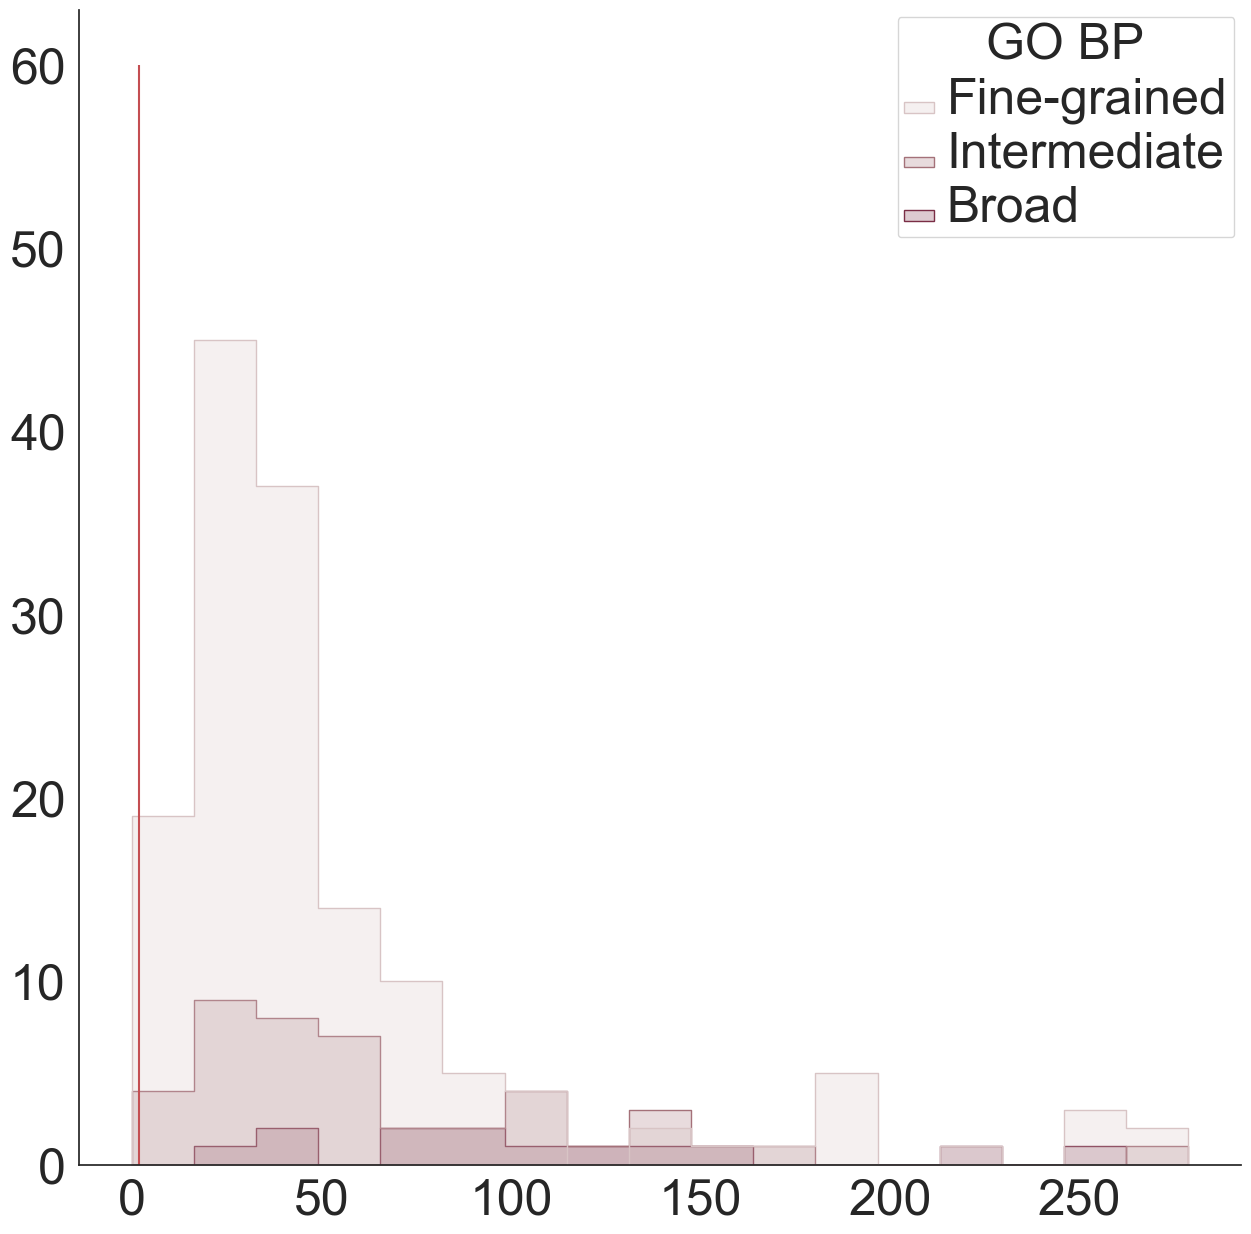

In [14]:
import seaborn as sns
goterms_lcc_df=pd.DataFrame()

finegrained_BP_lcc_zscore=[]
iteration=[]
for com, zscore in sig_enr_GOBP_first_louvain_ora_lcc_zscore_dict.items():
    if str(zscore)!="nan" and str(zscore)!="inf":
        finegrained_BP_lcc_zscore.append(float(zscore))
        iteration.append("Fine-grained")
        
        
middle_BP_lcc_zscore=[]

for com, zscore in sig_enr_GOBP_second_louvain_ora_lcc_zscore_dict.items():
    if str(zscore)!="nan" and str(zscore)!="inf":
        middle_BP_lcc_zscore.append(float(zscore))
        iteration.append("Intermediate")
        
        
broad_BP_lcc_zscore=[]

for com, zscore in sig_enr_GOBP_third_louvain_ora_lcc_zscore_dict.items():
    if str(zscore)!="nan" and str(zscore)!="inf":
        broad_BP_lcc_zscore.append(float(zscore))
        iteration.append("Broad")
        

goterms_lcc_df['zscore']=finegrained_BP_lcc_zscore+middle_BP_lcc_zscore+broad_BP_lcc_zscore
goterms_lcc_df['GO BP']=iteration
fig, ax = plt.subplots(figsize=(15,15))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

#plt.yscale('log')
plt.vlines(x=2,ymin=0,ymax=60,color='r',label='random thershold')
#plt.title('Distribution of lcc z-score for enriched terms GO CC of EEN communities across iterations', fontsize=28)
sns.histplot(
    goterms_lcc_df, x="zscore", hue="GO BP", element="step",palette=['#D8C4C5','#A47179','#7A2D45'],
)
ax.set_xticklabels([int(i) for i in list(ax.get_xticks())], size = 36)
ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)
plt.setp(ax.get_legend().get_texts(), fontsize='36') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='36') # for legend title
plt.xlabel('',fontsize=36)
plt.ylabel('', fontsize=36)
#plt.savefig('output/Figures/SF4C_1_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")



In [17]:

records = []

palette_map = {
    "Fine-grained": "#D8C4C5",
    "Intermediate": "#A47179",
    "Broad": "#7A2D45"
}

# Fine-grained
for com, zscore in sig_enr_GOBP_first_louvain_ora_lcc_zscore_dict.items():
    if zscore is not None:
        records.append({
            "zscore": float(zscore),
            "GO_BP_group": "Fine-grained",
            "Color": palette_map["Fine-grained"]
        })

# Intermediate
for com, zscore in sig_enr_GOBP_second_louvain_ora_lcc_zscore_dict.items():
    if zscore is not None:
        records.append({
            "zscore": float(zscore),
            "GO_BP_group": "Intermediate",
            "Color": palette_map["Intermediate"]
        })

# Broad
for com, zscore in sig_enr_GOBP_third_louvain_ora_lcc_zscore_dict.items():
    if zscore is not None:
        records.append({
            "zscore": float(zscore),
            "GO_BP_group": "Broad",
            "Color": palette_map["Broad"]
        })

# Create dataframe
SF_GOBP_lcc_source_df = pd.DataFrame(records)
SF_GOBP_lcc_source_df = SF_GOBP_lcc_source_df.dropna()

# Append to your existing SourceData Excel
excel_path = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(
        excel_path,
        engine="openpyxl",
        mode="a",
        if_sheet_exists="replace"
    ) as writer:
    SF_GOBP_lcc_source_df.to_excel(
        writer,
        sheet_name="SF7C_part1",
        index=False
    )

print("Source data appended: GO_BP_LCC_Zscores")

Source data appended: GO_BP_LCC_Zscores


/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_4312/2284543054.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(i) for i in list(ax.get_xticks())], size = 36)
/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_4312/2284543054.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)


Text(0, 0.5, '')

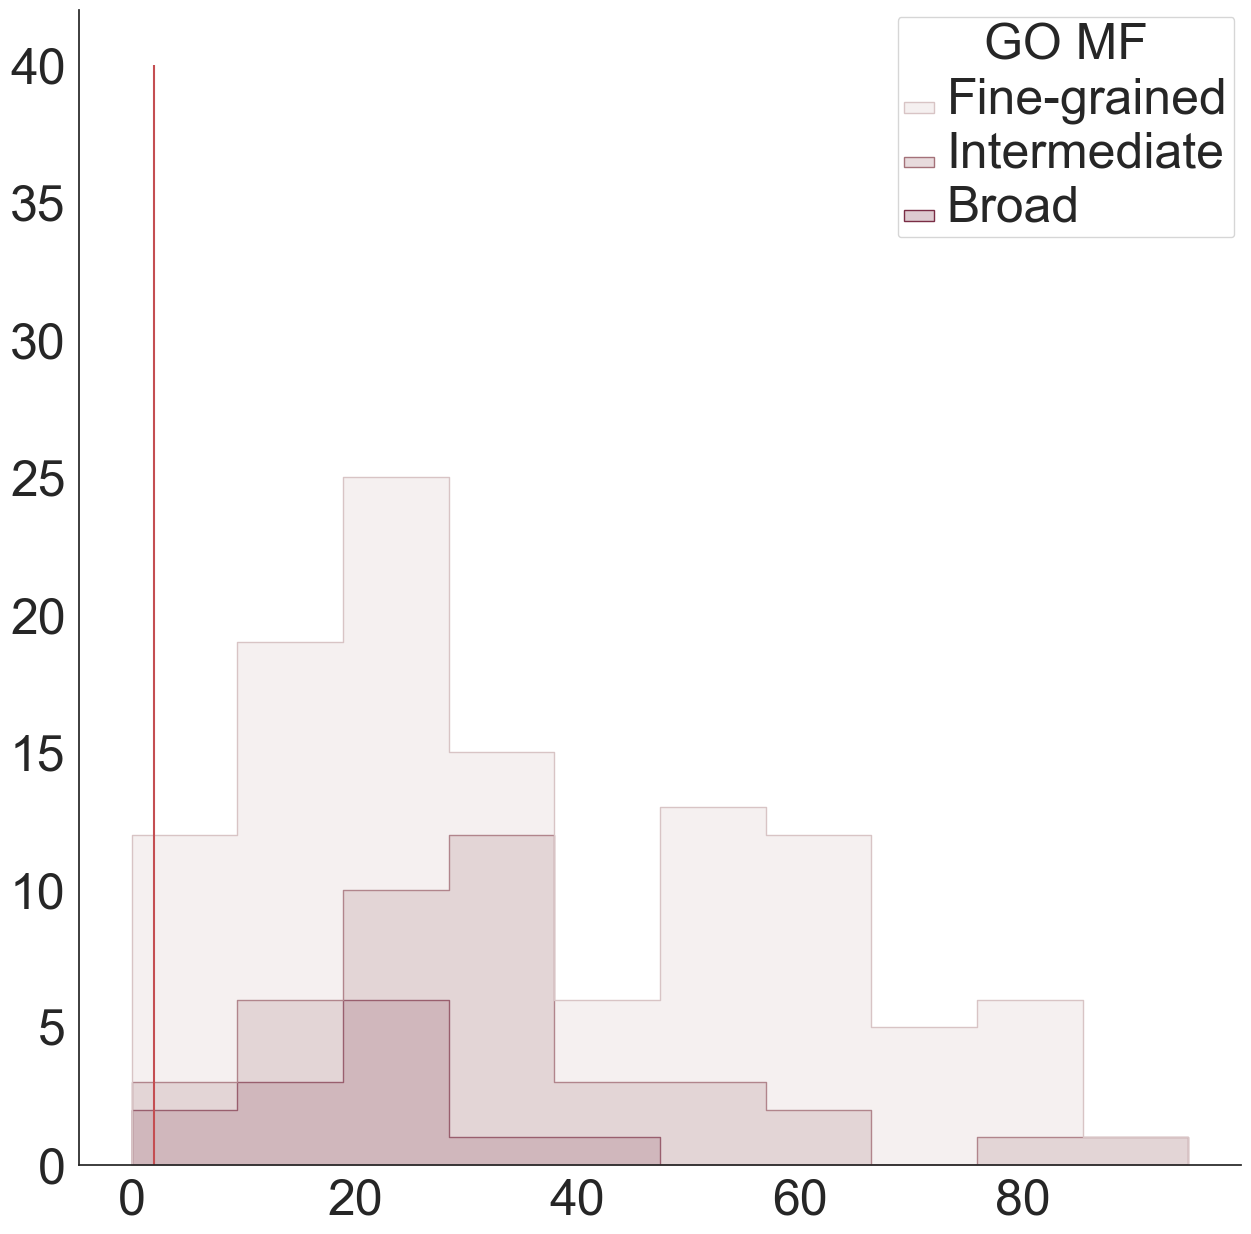

In [15]:
import seaborn as sns
goterms_lcc_df=pd.DataFrame()

finegrained_MF_lcc_zscore=[]
iteration=[]
for com, zscore in sig_enr_GOMF_first_louvain_ora_lcc_zscore_dict.items():
    if str(zscore)!="nan" and str(zscore)!="inf":
        finegrained_MF_lcc_zscore.append(float(zscore))
        iteration.append("Fine-grained")
        
        
middle_MF_lcc_zscore=[]

for com, zscore in sig_enr_GOMF_second_louvain_ora_lcc_zscore_dict.items():
    if str(zscore)!="nan" and str(zscore)!="inf":
        middle_MF_lcc_zscore.append(float(zscore))
        iteration.append("Intermediate")
        
        
broad_MF_lcc_zscore=[]

for com, zscore in sig_enr_GOMF_third_louvain_ora_lcc_zscore_dict.items():
    if str(zscore)!="nan" and str(zscore)!="inf":
        broad_MF_lcc_zscore.append(float(zscore))
        iteration.append("Broad")
        

goterms_lcc_df['zscore']=finegrained_MF_lcc_zscore+middle_MF_lcc_zscore+broad_MF_lcc_zscore
goterms_lcc_df['GO MF']=iteration
fig, ax = plt.subplots(figsize=(15,15))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

#plt.yscale('log')
plt.vlines(x=2,ymin=0,ymax=40,color='r',label='random thershold')
#plt.title('Distribution of lcc z-score for enriched terms GO CC of EEN communities across iterations', fontsize=28)
sns.histplot(
    goterms_lcc_df, x="zscore", hue="GO MF", element="step",palette=['#D8C4C5','#A47179','#7A2D45'],
)
ax.set_xticklabels([int(i) for i in list(ax.get_xticks())], size = 36)
ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)
plt.setp(ax.get_legend().get_texts(), fontsize='36') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='36') # for legend title
plt.xlabel('',fontsize=36)
plt.ylabel('', fontsize=36)
#plt.savefig('output/Figures/SF4C_2_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")


In [86]:

records = []

palette_map = {
    "Fine-grained": "#D8C4C5",
    "Intermediate": "#A47179",
    "Broad": "#7A2D45"
}

# Fine-grained
for com, zscore in sig_enr_GOMF_first_louvain_ora_lcc_zscore_dict.items():
    if zscore is not None:
        records.append({
            "zscore": float(zscore),
            "GO_MF_group": "Fine-grained",
            "Color": palette_map["Fine-grained"]
        })

# Intermediate
for com, zscore in sig_enr_GOMF_second_louvain_ora_lcc_zscore_dict.items():
    if zscore is not None:
        records.append({
            "zscore": float(zscore),
            "GO_MF_group": "Intermediate",
            "Color": palette_map["Intermediate"]
        })

# Broad
for com, zscore in sig_enr_GOMF_third_louvain_ora_lcc_zscore_dict.items():
    if zscore is not None:
        records.append({
            "zscore": float(zscore),
            "GO_MF_group": "Broad",
            "Color": palette_map["Broad"]
        })

# Create dataframe
SF_GOMF_lcc_source_df = pd.DataFrame(records)
SF_GOMF_lcc_source_df = SF_GOMF_lcc_source_df.dropna()

# Append to your existing SourceData Excel
excel_path = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(
        excel_path,
        engine="openpyxl",
        mode="a",
        if_sheet_exists="replace"
    ) as writer:
    SF_GOMF_lcc_source_df.to_excel(
        writer,
        sheet_name="SF7C_part2",
        index=False
    )

print("Source data appended: GO_MF_LCC_Zscores")

Source data appended: GO_MF_LCC_Zscores


/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_4312/3801097560.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(i) for i in list(ax.get_xticks())], size = 36)
/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_4312/3801097560.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)


Text(0, 0.5, '')

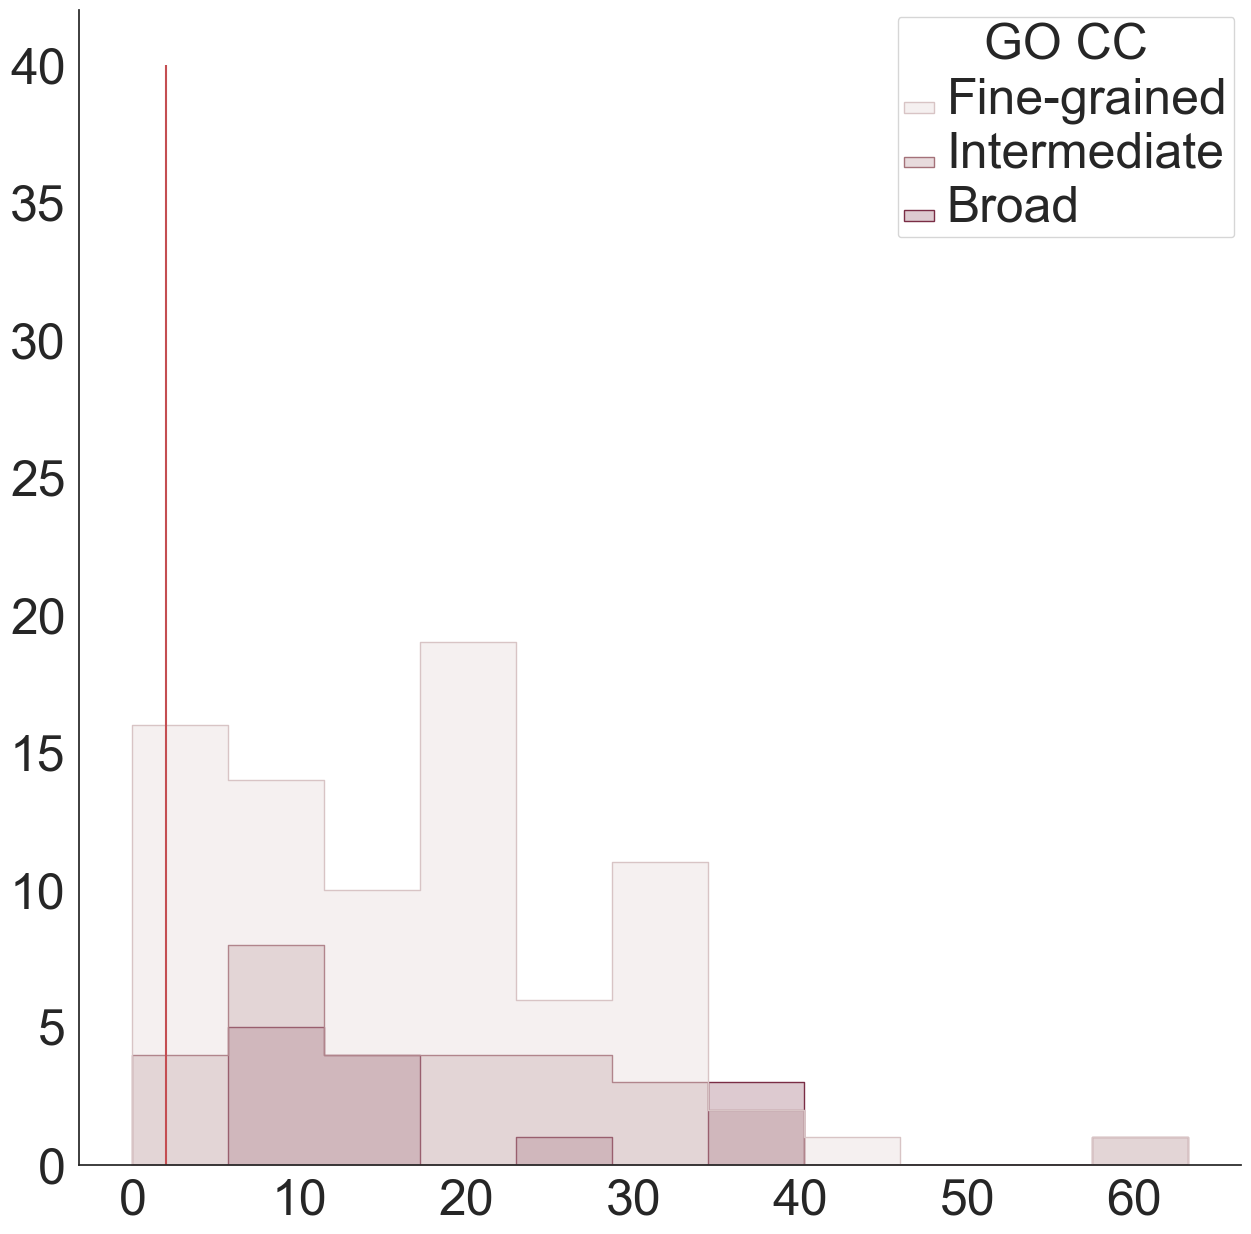

In [16]:
import seaborn as sns
goterms_lcc_df=pd.DataFrame()

finegrained_CC_lcc_zscore=[]
iteration=[]
for com, zscore in sig_enr_GOCC_first_louvain_ora_lcc_zscore_dict.items():
    if str(zscore)!="nan" and str(zscore)!="inf":
        finegrained_CC_lcc_zscore.append(float(zscore))
        iteration.append("Fine-grained")
        
        
middle_CC_lcc_zscore=[]

for com, zscore in sig_enr_GOCC_second_louvain_ora_lcc_zscore_dict.items():
    if str(zscore)!="nan" and str(zscore)!="inf":
        middle_CC_lcc_zscore.append(float(zscore))
        iteration.append("Intermediate")
        
        
broad_CC_lcc_zscore=[]

for com, zscore in sig_enr_GOCC_third_louvain_ora_lcc_zscore_dict.items():
    if str(zscore)!="nan" and str(zscore)!="inf":
        broad_CC_lcc_zscore.append(float(zscore))
        iteration.append("Broad")
        

goterms_lcc_df['zscore']=finegrained_CC_lcc_zscore+middle_CC_lcc_zscore+broad_CC_lcc_zscore
goterms_lcc_df['GO CC']=iteration
fig, ax = plt.subplots(figsize=(15,15))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

#plt.yscale('log')
plt.vlines(x=2,ymin=0,ymax=40,color='r',label='random thershold')
#plt.title('Distribution of lcc z-score for enriched terms GO CC of EEN communities across iterations', fontsize=28)
sns.histplot(
    goterms_lcc_df, x="zscore", hue="GO CC", element="step",palette=['#D8C4C5','#A47179','#7A2D45'],
)
ax.set_xticklabels([int(i) for i in list(ax.get_xticks())], size = 36)
ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)
plt.setp(ax.get_legend().get_texts(), fontsize='36') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='36') # for legend title
plt.xlabel('',fontsize=36)
plt.ylabel('', fontsize=36)
#plt.savefig('output/Figures/SF4C_3_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")


In [88]:

records = []

palette_map = {
    "Fine-grained": "#D8C4C5",
    "Intermediate": "#A47179",
    "Broad": "#7A2D45"
}

# Fine-grained
for com, zscore in sig_enr_GOCC_first_louvain_ora_lcc_zscore_dict.items():
    if zscore is not None:
        records.append({
            "zscore": float(zscore),
            "GO_CC_group": "Fine-grained",
            "Color": palette_map["Fine-grained"]
        })

# Intermediate
for com, zscore in sig_enr_GOCC_second_louvain_ora_lcc_zscore_dict.items():
    if zscore is not None:
        records.append({
            "zscore": float(zscore),
            "GO_CC_group": "Intermediate",
            "Color": palette_map["Intermediate"]
        })

# Broad
for com, zscore in sig_enr_GOCC_third_louvain_ora_lcc_zscore_dict.items():
    if zscore is not None:
        records.append({
            "zscore": float(zscore),
            "GO_CC_group": "Broad",
            "Color": palette_map["Broad"]
        })

# Create dataframe
SF_GOCC_lcc_source_df = pd.DataFrame(records)
SF_GOCC_lcc_source_df = SF_GOCC_lcc_source_df.dropna()

# Append to your existing SourceData Excel
excel_path = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(
        excel_path,
        engine="openpyxl",
        mode="a",
        if_sheet_exists="replace"
    ) as writer:
    SF_GOCC_lcc_source_df.to_excel(
        writer,
        sheet_name="SF7C_part3",
        index=False
    )

print("Source data appended: GO_CC_LCC_Zscores")

Source data appended: GO_CC_LCC_Zscores


In [17]:
finegrained_enriched_terms=finegrained_BP_lcc_zscore+finegrained_MF_lcc_zscore+finegrained_CC_lcc_zscore
middle_enriched_terms=middle_BP_lcc_zscore+middle_MF_lcc_zscore+middle_CC_lcc_zscore
broad_enriched_terms=broad_BP_lcc_zscore+broad_MF_lcc_zscore+broad_CC_lcc_zscore


In [ ]:
from scipy import stats

t_value,p_value=stats.ttest_ind(finegrained_enriched_terms,middle_enriched_terms)
print("The p-value between fine-grained and middle communities GO z-score distributions is %s" %p_value)
t_value,p_value=stats.ttest_ind(broad_enriched_terms,middle_enriched_terms)
print("The p-value between broad and middle communities of GO z-score distributions is %s" %p_value)
t_value,p_value=stats.ttest_ind(broad_enriched_terms,finegrained_enriched_terms)
print("The p-value between broad and fine-grained communities of GO z-score distributions is %s" %p_value)

In [ ]:
#Mann-Whitney U test one-sided (because our hypothesis is that the median of fine-grained enriched terms is higher)

u_statistic, p_value = stats.mannwhitneyu(middle_enriched_terms,finegrained_enriched_terms, alternative='less')
print("The p-value between fine-grained and middle communities GO z-score distributions is %s" %p_value)

u_statistic, p_value = stats.mannwhitneyu(broad_enriched_terms, middle_enriched_terms, alternative='less')
print("The p-value between broad and middle communities of GO z-score distributions is %s" %p_value)

u_statistic, p_value = stats.mannwhitneyu(broad_enriched_terms, finegrained_enriched_terms, alternative='less')
print("The p-value between broad and fine-grained communities of GO z-score distributions is %s" %p_value)

In [ ]:
#Mann-Whitney U test two-sided 

u_statistic, p_value = stats.mannwhitneyu(middle_enriched_terms,finegrained_enriched_terms, alternative='two-sided')
print("The p-value between fine-grained and middle communities GO z-score distributions is %s" %p_value)

u_statistic, p_value = stats.mannwhitneyu(broad_enriched_terms, middle_enriched_terms, alternative='two-sided')
print("The p-value between broad and middle communities of GO z-score distributions is %s" %p_value)

u_statistic, p_value = stats.mannwhitneyu(broad_enriched_terms, finegrained_enriched_terms, alternative='two-sided')
print("The p-value between broad and fine-grained communities of GO z-score distributions is %s" %p_value)

/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_4312/1441888681.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g=sns.barplot(x=EEN_louvain_com_df["Louvain Iteration"], y=EEN_louvain_com_df["z-score lcc"],estimator=np.median, palette=['#D8C4C5','#A47179','#7A2D45'],linewidth=5)
/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_4312/1441888681.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)
/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_4312/1441888681.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, size = 36)


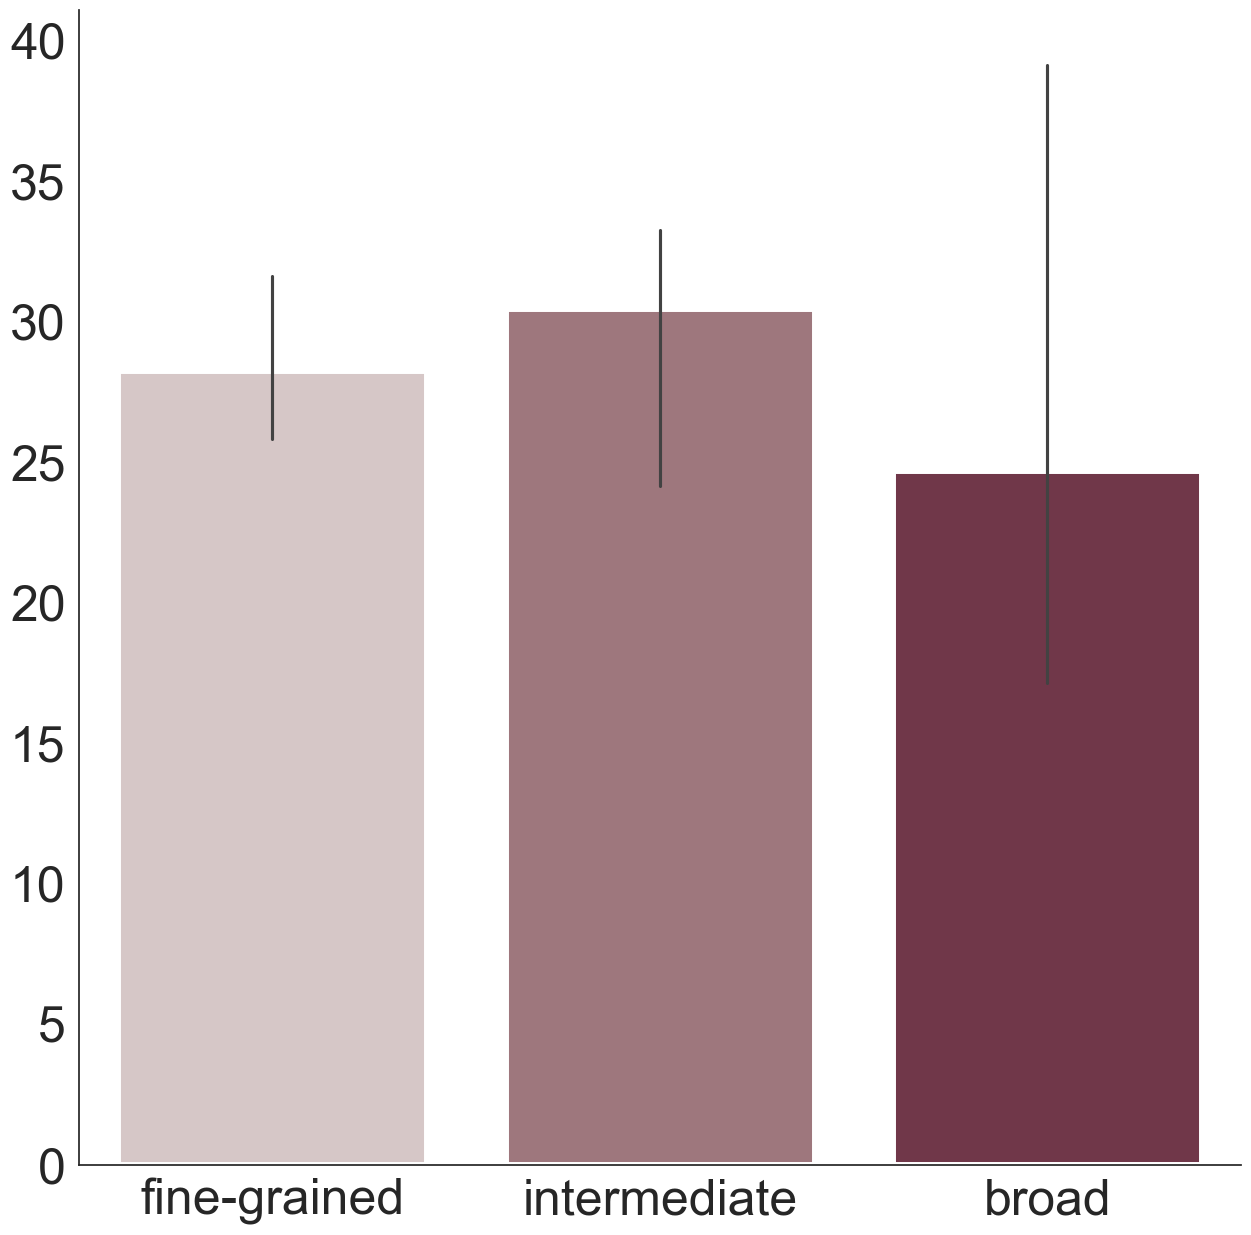

In [18]:
#Here, we check the biological cohesiveness of the enrichment terms for each dividing community


column_names = ["z-score lcc", "louvain Iteration"]
labels=['fine-grained','intermediate','broad']
zscore_list_tot=[]
group_list=[]
for i in finegrained_enriched_terms:
    zscore_list_tot.append(i)
    group_list.append("fine-grained")
    
for i in middle_enriched_terms:
    zscore_list_tot.append(i)
    group_list.append("intermediate")

for i in broad_enriched_terms:
    zscore_list_tot.append(i)
    group_list.append("broad")
    
EEN_louvain_com_df = pd.DataFrame(columns = column_names)
EEN_louvain_com_df["z-score lcc"]=zscore_list_tot
EEN_louvain_com_df["Louvain Iteration"]=group_list

import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 15))
sns.set(style="white")

g=sns.barplot(x=EEN_louvain_com_df["Louvain Iteration"], y=EEN_louvain_com_df["z-score lcc"],estimator=np.median, palette=['#D8C4C5','#A47179','#7A2D45'],linewidth=5)

#ax = sns.barplot(x="louvain Iteration", y="z-score lcc", data=EEN_louvain_com_df,
#                 palette="Blues_d")
#g.set_yscale("log")
#ax.set_xlabel("Louvain iteration",fontsize=32)
#ax.set_ylabel("lcc z-score enriched terms",fontsize=32)
ax.set_xlabel("",fontsize=32)
ax.set_ylabel("",fontsize=32)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)
ax.set_xticklabels(labels, size = 36)
#plt.savefig('output/Figures/Fig2E_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()

/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_4312/1132109032.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_4312/1132109032.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


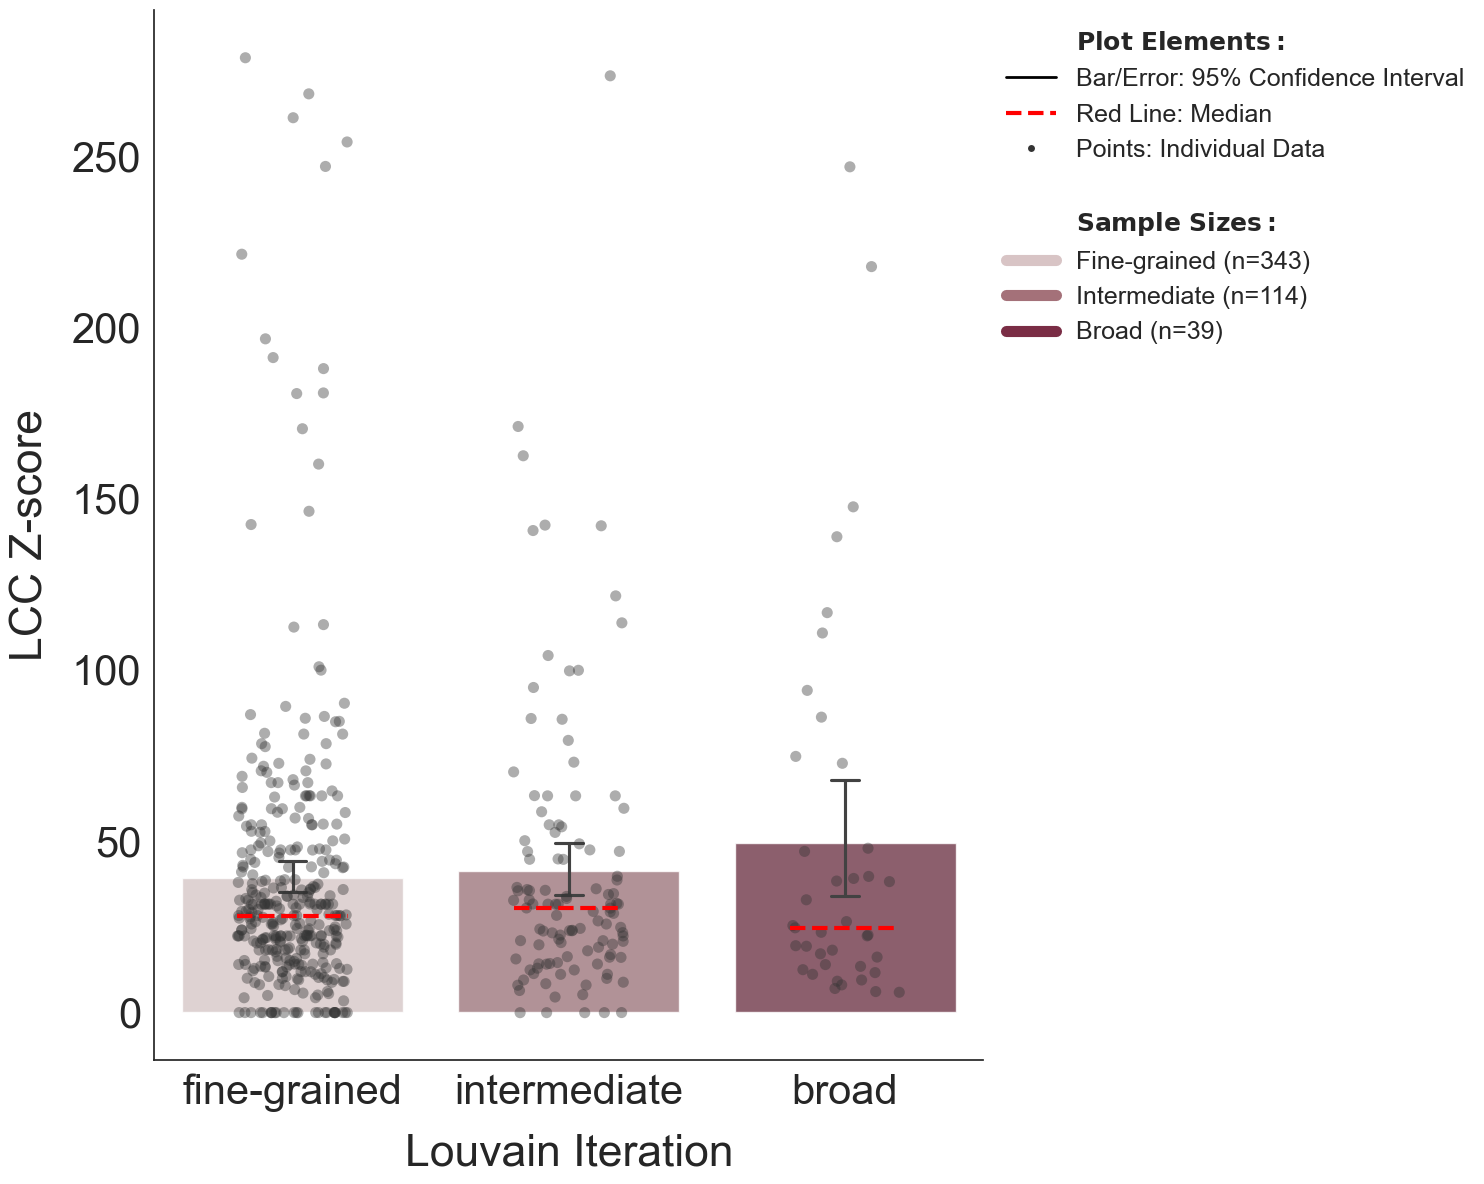

In [21]:


labels=['fine-grained','intermediate','broad']
zscore_list_tot=[]
group_list=[]
for i in finegrained_enriched_terms:
    zscore_list_tot.append(i)
    group_list.append("fine-grained")
    
for i in middle_enriched_terms:
    zscore_list_tot.append(i)
    group_list.append("intermediate")

for i in broad_enriched_terms:
    zscore_list_tot.append(i)
    group_list.append("broad")


# 1. Build DataFrame
EEN_louvain_com_df = pd.DataFrame({
    "z-score lcc": zscore_list_tot,
    "Louvain Iteration": group_list
})

# 2. Pre-calculate N-counts and Medians
n_counts = EEN_louvain_com_df["Louvain Iteration"].value_counts().to_dict()
order = ['fine-grained', 'intermediate', 'broad']
medians = EEN_louvain_com_df.groupby("Louvain Iteration")["z-score lcc"].median().to_dict()

# 3. Setup Plot
fig, ax = plt.subplots(figsize=(15, 12))
sns.set_style("white")
palette_colors = ['#D8C4C5', '#A47179', '#7A2D45']

# ---- BARPLOT (Mean) ----
sns.barplot(
    data=EEN_louvain_com_df, 
    x="Louvain Iteration", y="z-score lcc", 
    order=order, estimator=np.mean, errorbar=('ci', 95), 
    palette=palette_colors, capsize=0.1, alpha=0.8, ax=ax
)

# ---- HIGHLIGHT MEDIAN ----
# We draw a short horizontal line for the median in each category
for i, label in enumerate(order):
    median_val = medians[label]
    # Adjust the x-coordinates to center the line on the bar
    ax.hlines(y=median_val, xmin=i-0.2, xmax=i+0.2, 
              color='red', linestyle='--', linewidth=3, zorder=5)

# ---- OVERLAY RAW DATA ----
sns.stripplot(
    data=EEN_louvain_com_df, 
    x="Louvain Iteration", y="z-score lcc", 
    order=order, palette=['#333333']*3, 
    size=8, jitter=0.2, alpha=0.4, ax=ax
)

# 4. Comprehensive Legend (Journal Compliant)
legend_elements = [
    Line2D([0], [0], color='none', label=r'$\mathbf{Plot\ Elements:}$'),
    Line2D([0], [0], color='black', lw=2, label='Bar/Error: 95% Confidence Interval'),
    Line2D([0], [0], color='red', ls='--', lw=3, label='Red Line: Median'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#333333', label='Points: Individual Data'),
    Line2D([0], [0], color='none', label=''), 
    Line2D([0], [0], color='none', label=r'$\mathbf{Sample\ Sizes:}$')
]

for label, color in zip(order, palette_colors):
    n = n_counts.get(label, 0)
    legend_elements.append(Line2D([0], [0], color=color, lw=8, label=f"{label.capitalize()} (n={n})"))

ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1), fontsize=18, frameon=False)

# 5. Styling
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.xlabel("Louvain Iteration", fontsize=32, labelpad=15)
plt.ylabel("LCC Z-score", fontsize=32, labelpad=15)

plt.tight_layout()
plt.savefig('output/Figures/Fig2E_v07.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.savefig('output/Figures/Fig2E_v07.svg',format='svg',dpi=300, bbox_inches = "tight")
plt.show()


In [1]:


labels=['fine-grained','intermediate','broad']
zscore_list_tot=[]
group_list=[]
for i in finegrained_enriched_terms:
    zscore_list_tot.append(i)
    group_list.append("fine-grained")
    
for i in middle_enriched_terms:
    zscore_list_tot.append(i)
    group_list.append("intermediate")

for i in broad_enriched_terms:
    zscore_list_tot.append(i)
    group_list.append("broad")


# 1. Build DataFrame
EEN_louvain_com_df = pd.DataFrame({
    "z-score lcc": zscore_list_tot,
    "Louvain Iteration": group_list
})

# 2. Pre-calculate N-counts and Medians
n_counts = EEN_louvain_com_df["Louvain Iteration"].value_counts().to_dict()
order = ['fine-grained', 'intermediate', 'broad']
medians = EEN_louvain_com_df.groupby("Louvain Iteration")["z-score lcc"].median().to_dict()

# 3. Setup Plot
fig, ax = plt.subplots(figsize=(15, 12))
sns.set_style("white")
palette_colors = ['#D8C4C5', '#A47179', '#7A2D45']

# ---- BARPLOT (Mean) ----
sns.barplot(
    data=EEN_louvain_com_df, 
    x="Louvain Iteration", y="z-score lcc", 
    order=order, estimator=np.mean, errorbar='sd', 
    palette=palette_colors, capsize=0.1, alpha=0.8, ax=ax
)

# ---- HIGHLIGHT MEDIAN ----
# We draw a short horizontal line for the median in each category
for i, label in enumerate(order):
    median_val = medians[label]
    # Adjust the x-coordinates to center the line on the bar
    ax.hlines(y=median_val, xmin=i-0.2, xmax=i+0.2, 
              color='red', linestyle='--', linewidth=3, zorder=5)

# ---- OVERLAY RAW DATA ----
sns.stripplot(
    data=EEN_louvain_com_df, 
    x="Louvain Iteration", y="z-score lcc", 
    order=order, palette=['#333333']*3, 
    size=8, jitter=0.2, alpha=0.4, ax=ax
)

# 4. Comprehensive Legend (Journal Compliant)
legend_elements = [
    Line2D([0], [0], color='none', label=r'$\mathbf{Plot\ Elements:}$'),
    Line2D([0], [0], color='black', lw=2, label='Bar/Error: Mean ± SD'),
    Line2D([0], [0], color='red', ls='--', lw=3, label='Red Line: Median'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#333333', label='Points: Individual Data'),
    Line2D([0], [0], color='none', label=''), 
    Line2D([0], [0], color='none', label=r'$\mathbf{Sample\ Sizes:}$')
]

for label, color in zip(order, palette_colors):
    n = n_counts.get(label, 0)
    legend_elements.append(Line2D([0], [0], color=color, lw=8, label=f"{label.capitalize()} (n={n})"))

ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1), fontsize=18, frameon=False)

# 5. Styling
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.xlabel("Louvain Iteration", fontsize=32, labelpad=15)
plt.ylabel("LCC Z-score", fontsize=32, labelpad=15)

plt.tight_layout()
#plt.savefig('output/Figures/Fig2E_v06.pdf',format='pdf',dpi=300, bbox_inches = "tight")
#plt.savefig('output/Figures/Fig2E_v06.svg',format='svg',dpi=300, bbox_inches = "tight")
plt.show()

NameError: name 'finegrained_enriched_terms' is not defined

In [23]:
EEN_louvain_com_df.drop(columns=["louvain Iteration"], inplace=True)

# Append to your existing SourceData Excel
excel_path = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(
        excel_path,
        engine="openpyxl",
        mode="a",
        if_sheet_exists="replace"
    ) as writer:
    EEN_louvain_com_df.to_excel(
        writer,
        sheet_name="Fig2E",
        index=False
    )

In [ ]:
#T-test
from scipy import stats

t_value,p_value=stats.ttest_ind(finegrained_MF_lcc_zscore,middle_MF_lcc_zscore)
print("The p-value between fine-grained and middle communities of MF z-score distributions is %s" %p_value)
t_value,p_value=stats.ttest_ind(broad_MF_lcc_zscore,middle_MF_lcc_zscore)
print("The p-value between broad and middle communities of MF z-score distributions is %s" %p_value)
t_value,p_value=stats.ttest_ind(broad_MF_lcc_zscore,finegrained_MF_lcc_zscore)
print("The p-value between broad and fine-grained communities of MF z-score distributions is %s" %p_value)


t_value,p_value=stats.ttest_ind(finegrained_BP_lcc_zscore,middle_BP_lcc_zscore)
print("The p-value between fine-grained and middle communities of BP z-score distributions is %s" %p_value)
t_value,p_value=stats.ttest_ind(broad_BP_lcc_zscore,middle_BP_lcc_zscore)
print("The p-value between broad and middle communities of BP z-score distributions is %s" %p_value)
t_value,p_value=stats.ttest_ind(broad_BP_lcc_zscore,finegrained_BP_lcc_zscore)
print("The p-value between broad and fine-grained communities of BP z-score distributions is %s" %p_value)

t_value,p_value=stats.ttest_ind(finegrained_CC_lcc_zscore,middle_CC_lcc_zscore)
print("The p-value between fine-grained and middle communities of CC z-score distributions is %s" %p_value)
t_value,p_value=stats.ttest_ind(broad_CC_lcc_zscore,middle_CC_lcc_zscore)
print("The p-value between broad and middle communities of CC z-score distributions is %s" %p_value)
t_value,p_value=stats.ttest_ind(broad_CC_lcc_zscore,finegrained_CC_lcc_zscore)
print("The p-value between broad and fine-grained communities of CC z-score distributions is %s" %p_value)


In [34]:
#Let's import the results
with open('output/Communities/Louvain/weighted_fine_grained_communities_gobp_resnik.pickle', 'rb') as handle:
    fine_grained_communities_gobp_resnik = pk.load(handle)    
with open('output/Communities/Louvain/weighted_fine_grained_communities_gomf_resnik.pickle', 'rb') as handle:
    fine_grained_communities_gomf_resnik = pk.load(handle)    
with open('output/Communities/Louvain/weighted_fine_grained_communities_gocc_resnik.pickle', 'rb') as handle:
    fine_grained_communities_gocc_resnik = pk.load(handle)
with open('output/Communities/Louvain/weighted_middle_communities_gobp_resnik.pickle', 'rb') as handle:
    middle_communities_gobp_resnik = pk.load(handle)    
with open('output/Communities/Louvain/weighted_middle_communities_gomf_resnik.pickle', 'rb') as handle:
    middle_communities_gomf_resnik = pk.load(handle)    
with open('output/Communities/Louvain/weighted_middle_communities_gocc_resnik.pickle', 'rb') as handle:
    middle_communities_gocc_resnik = pk.load(handle)
with open('output/Communities/Louvain/weighted_broad_communities_gobp_resnik.pickle', 'rb') as handle:
    broad_communities_gobp_resnik = pk.load(handle)    
with open('output/Communities/Louvain/weighted_broad_communities_gomf_resnik.pickle', 'rb') as handle:
    broad_communities_gomf_resnik = pk.load(handle)    
with open('output/Communities/Louvain/weighted_broad_communities_gocc_resnik.pickle', 'rb') as handle:
    broad_communities_gocc_resnik = pk.load(handle)

#Let's import the random expectations


with open('output/Communities/Louvain/weighted_rd_fine_grained_communities_gomf_resnik.pickle', 'rb') as handle:
    rd_fine_grained_communities_gomf_resnik = pk.load(handle)    
with open('output/Communities/Louvain/weighted_rd_middle_communities_gomf_resnik.pickle', 'rb') as handle:
    rd_middle_communities_gomf_resnik = pk.load(handle)    
with open('output/Communities/Louvain/weighted_rd_broad_communities_gomf_resnik.pickle', 'rb') as handle:
    rd_broad_communities_gomf_resnik = pk.load(handle)
with open('output/Communities/Louvain/weighted_rd_fine_grained_communities_gocc_resnik.pickle', 'rb') as handle:
    rd_fine_grained_communities_gocc_resnik = pk.load(handle)    
with open('output/Communities/Louvain/weighted_rd_middle_communities_gocc_resnik.pickle', 'rb') as handle:
    rd_middle_communities_gocc_resnik = pk.load(handle)    
with open('output/Communities/Louvain/weighted_rd_broad_communities_gocc_resnik.pickle', 'rb') as handle:
    rd_broad_communities_gocc_resnik = pk.load(handle)
with open('output/Communities/Louvain/weighted_rd_fine_grained_communities_gobp_resnik.pickle', 'rb') as handle:
    rd_fine_grained_communities_gobp_resnik = pk.load(handle)    
with open('output/Communities/Louvain/weighted_rd_middle_communities_gobp_resnik.pickle', 'rb') as handle:
    rd_middle_communities_gobp_resnik = pk.load(handle)    
with open('output/Communities/Louvain/weighted_rd_broad_communities_gobp_resnik.pickle', 'rb') as handle:
    rd_broad_communities_gobp_resnik = pk.load(handle)
    

/opt/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_68905/1494071844.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(i) for i in list(ax.get_xticks())], size = 36)
/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_68905/1494071844.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)


Text(0, 0.5, '')

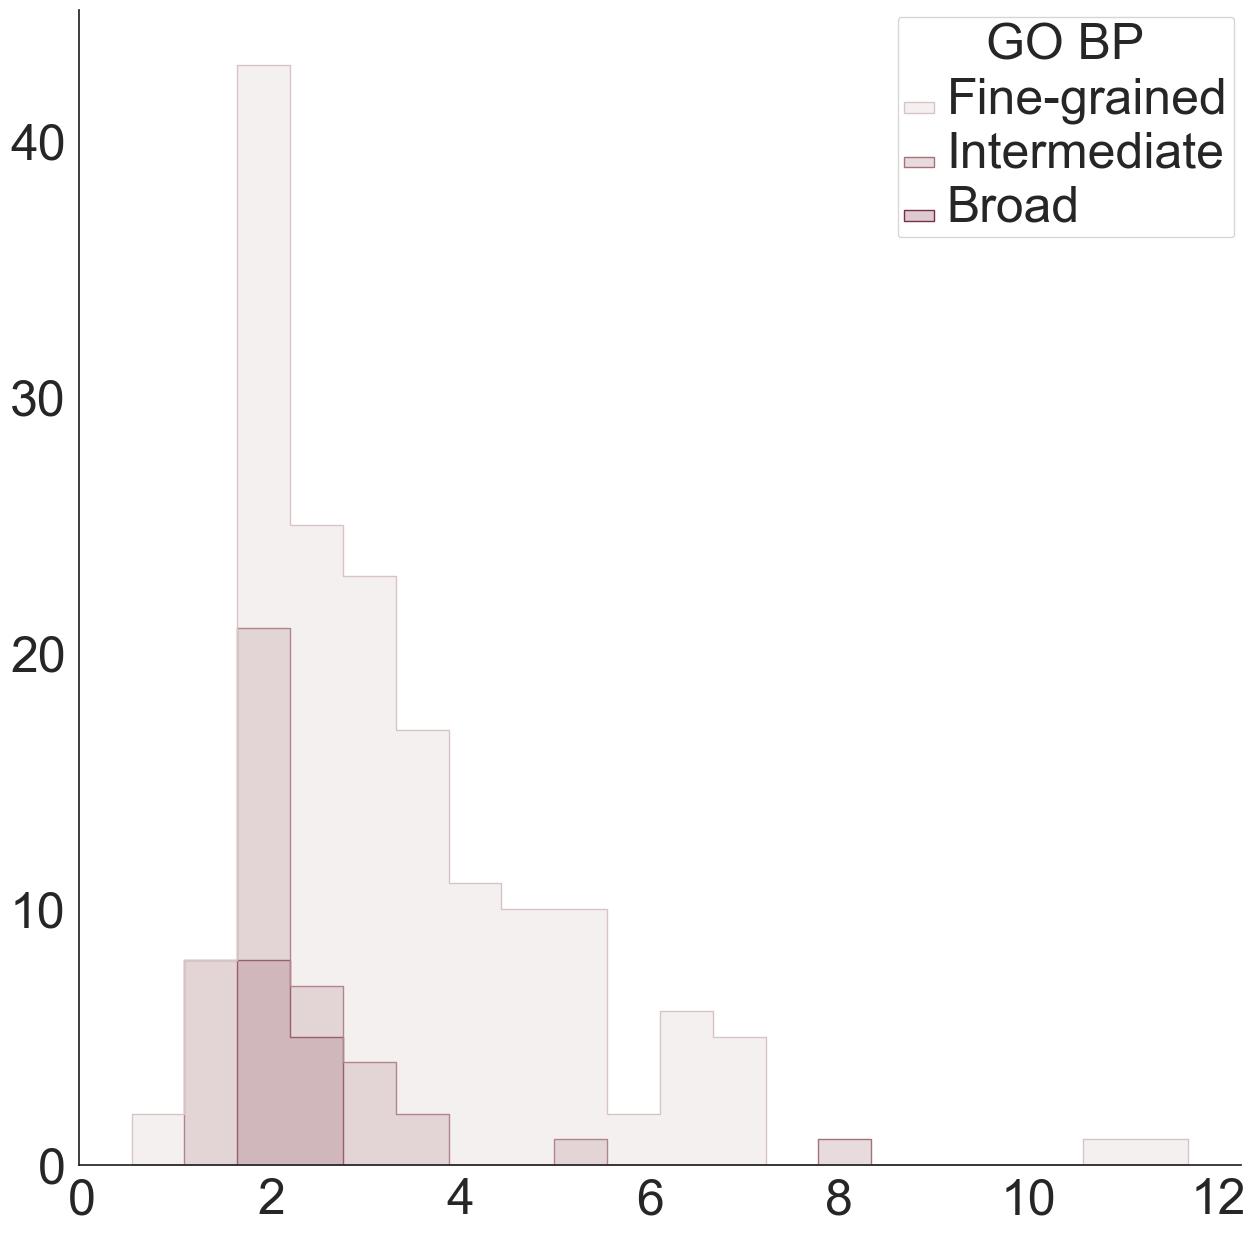

In [89]:
goterms_resnik_df=pd.DataFrame()

finegrained_BP_resnik=[]
iteration=[]
for com, resnik in fine_grained_communities_gobp_resnik.items():
    cl_resnik_list=[]
    for r in resnik:
        if str(r)!="nan" and str(r)!="inf":
            cl_resnik_list.append(r)
    finegrained_BP_resnik.append(float(np.mean(cl_resnik_list)))
    iteration.append("Fine-grained")
        
        
middle_BP_resnik=[]
for com, resnik in middle_communities_gobp_resnik.items():
    cl_resnik_list=[]
    for r in resnik:
        if str(r)!="nan" and str(r)!="inf":
            cl_resnik_list.append(r)
    middle_BP_resnik.append(float(np.mean(cl_resnik_list)))
    iteration.append("Intermediate")
        
        
broad_BP_resnik=[]
for com, resnik in broad_communities_gobp_resnik.items():
    cl_resnik_list=[]
    for r in resnik:
        if str(r)!="nan" and str(r)!="inf":
            cl_resnik_list.append(r)
    broad_BP_resnik.append(float(np.mean(cl_resnik_list)))
    iteration.append("Broad")
        
goterms_resnik_df['resnik']=finegrained_BP_resnik+middle_BP_resnik+broad_BP_resnik
goterms_resnik_df['GO BP']=iteration
fig, ax = plt.subplots(figsize=(15,15))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

#plt.yscale('log')


sns.histplot(
    goterms_resnik_df, x="resnik", hue="GO BP", element="step",palette=['#D8C4C5','#A47179','#7A2D45']
)
ax.set_xticklabels([int(i) for i in list(ax.get_xticks())], size = 36)
ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)
plt.setp(ax.get_legend().get_texts(), fontsize='36') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='36') # for legend title
plt.xlabel('',fontsize=36)
plt.ylabel('', fontsize=36)
#plt.savefig('output/Figures/SF5A_1_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")


In [90]:
palette_map = {
    "Fine-grained": "#D8C4C5",
    "Intermediate": "#A47179",
    "Broad": "#7A2D45"
}

goterms_resnik_df = goterms_resnik_df.dropna()

goterms_resnik_df["Color"] = goterms_resnik_df["GO BP"].map(palette_map)

# Append to your existing SourceData Excel
excel_path = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(
        excel_path,
        engine="openpyxl",
        mode="a",
        if_sheet_exists="replace"
    ) as writer:
    goterms_resnik_df.to_excel(
        writer,
        sheet_name="SF8A_part1",
        index=False
    )

print("Source data appended: SF_GOBP_resnik_df")

Source data appended: SF_GOBP_resnik_df


/opt/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_68905/3066191371.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(i) for i in list(ax.get_xticks())], size = 36)
/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_68905/3066191371.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)


Text(0, 0.5, '')

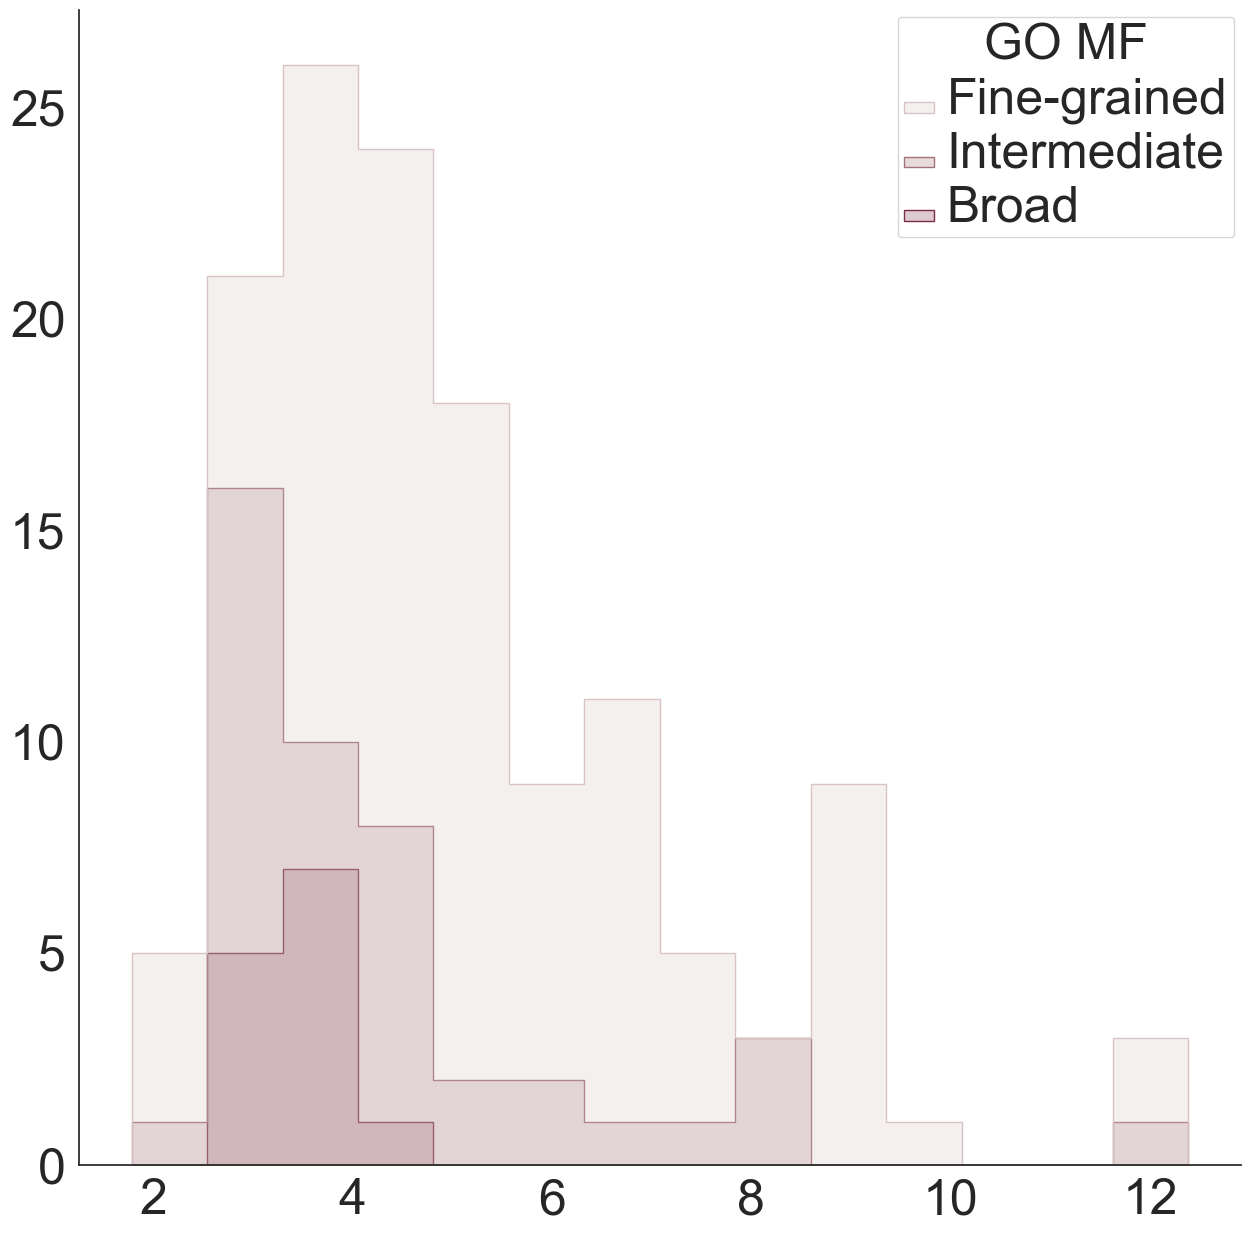

In [91]:
goterms_resnik_df=pd.DataFrame()

finegrained_MF_resnik=[]
iteration=[]
for com, resnik in fine_grained_communities_gomf_resnik.items():
    cl_resnik_list=[]
    for r in resnik:
        if str(r)!="nan" and str(r)!="inf":
            cl_resnik_list.append(r)
    finegrained_MF_resnik.append(float(np.mean(cl_resnik_list)))
    iteration.append("Fine-grained")
        
        
middle_MF_resnik=[]
for com, resnik in middle_communities_gomf_resnik.items():
    cl_resnik_list=[]
    for r in resnik:
        if str(r)!="nan" and str(r)!="inf":
            cl_resnik_list.append(r)
    middle_MF_resnik.append(float(np.mean(cl_resnik_list)))
    iteration.append("Intermediate")
        
        
broad_MF_resnik=[]
for com, resnik in broad_communities_gomf_resnik.items():
    cl_resnik_list=[]
    for r in resnik:
        if str(r)!="nan" and str(r)!="inf":
            cl_resnik_list.append(r)
    broad_MF_resnik.append(float(np.mean(cl_resnik_list)))
    iteration.append("Broad")
        
goterms_resnik_df['resnik']=finegrained_MF_resnik+middle_MF_resnik+broad_MF_resnik
goterms_resnik_df['GO MF']=iteration
fig, ax = plt.subplots(figsize=(15,15))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

#plt.yscale('log')

#plt.title('Distribution of lcc z-score for enriched terms GO CC of EEN communities across iterations', fontsize=28)
sns.histplot(
    goterms_resnik_df, x="resnik", hue="GO MF", element="step",palette=['#D8C4C5','#A47179','#7A2D45']
)
ax.set_xticklabels([int(i) for i in list(ax.get_xticks())], size = 36)
ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)
plt.setp(ax.get_legend().get_texts(), fontsize='36') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='36') # for legend title
plt.xlabel('',fontsize=36)
plt.ylabel('', fontsize=36)
#plt.savefig('output/Figures/SF5A_2_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")


In [92]:
palette_map = {
    "Fine-grained": "#D8C4C5",
    "Intermediate": "#A47179",
    "Broad": "#7A2D45"
}

goterms_resnik_df = goterms_resnik_df.dropna()

goterms_resnik_df["Color"] = goterms_resnik_df["GO MF"].map(palette_map)

# Append to your existing SourceData Excel
excel_path = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(
        excel_path,
        engine="openpyxl",
        mode="a",
        if_sheet_exists="replace"
    ) as writer:
    goterms_resnik_df.to_excel(
        writer,
        sheet_name="SF8A_part2",
        index=False
    )

print("Source data appended: SF_GOMF_resnik_df")

Source data appended: SF_GOMF_resnik_df


/opt/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_68905/2443572558.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(i) for i in list(ax.get_xticks())], size = 36)
/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_68905/2443572558.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)


Text(0, 0.5, '')

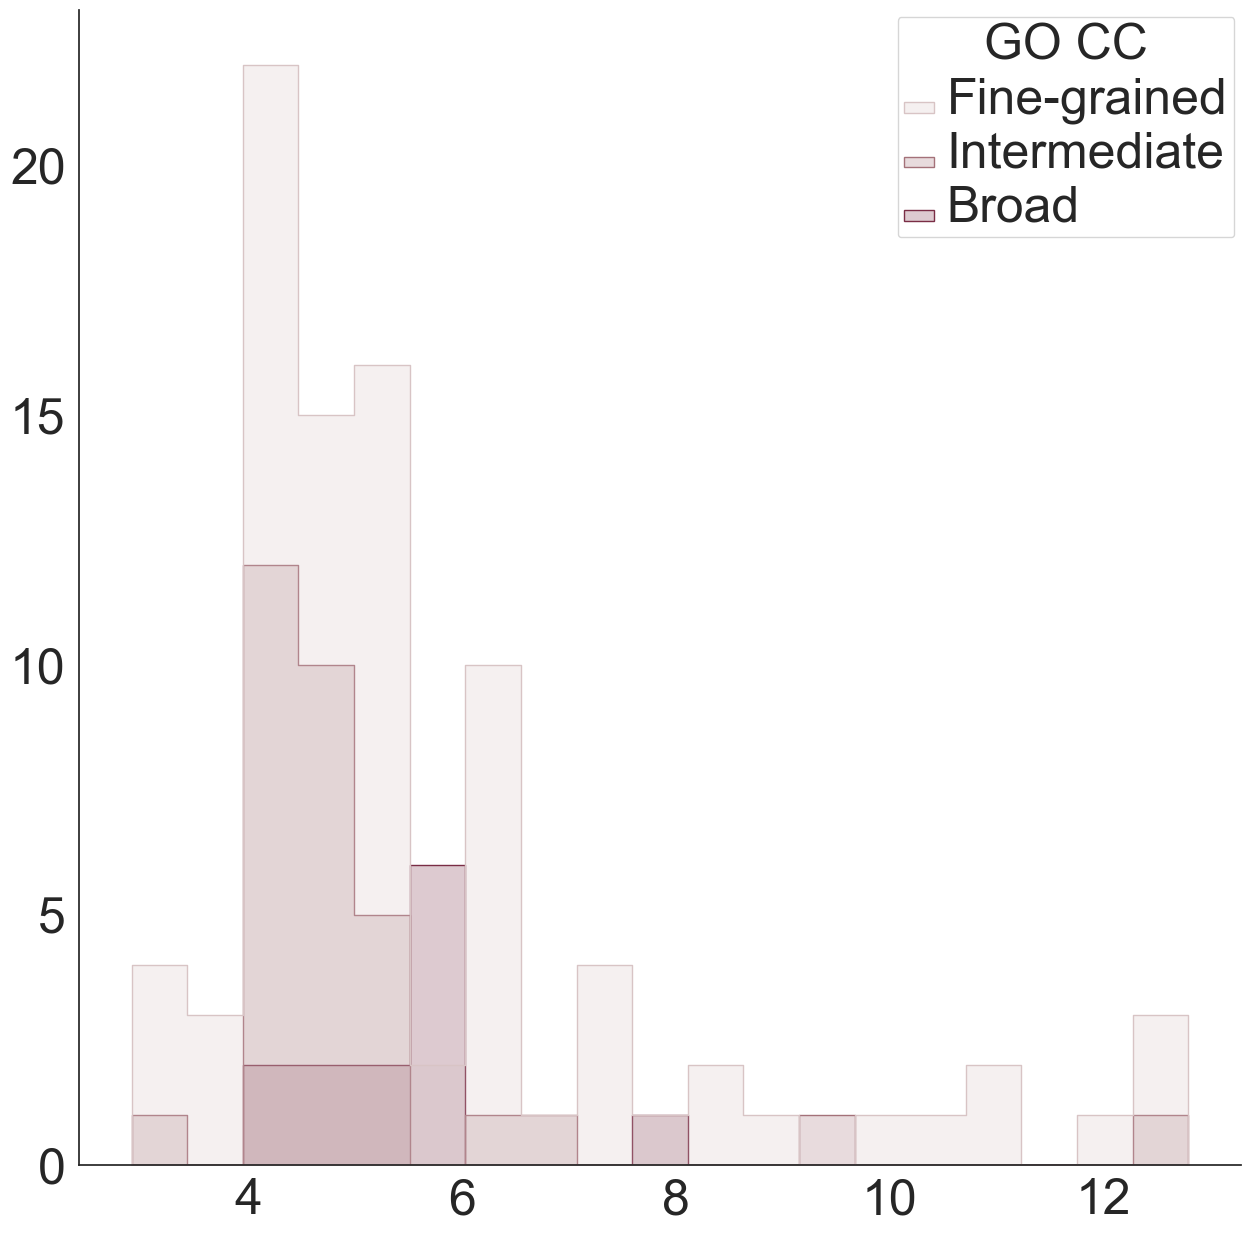

In [93]:
goterms_resnik_df=pd.DataFrame()

finegrained_CC_resnik=[]
iteration=[]
for com, resnik in fine_grained_communities_gocc_resnik.items():
    cl_resnik_list=[]
    for r in resnik:
        if str(r)!="nan" and str(r)!="inf":
            cl_resnik_list.append(r)
    finegrained_CC_resnik.append(float(np.mean(cl_resnik_list)))
    iteration.append("Fine-grained")
        
        
middle_CC_resnik=[]
for com, resnik in middle_communities_gocc_resnik.items():
    cl_resnik_list=[]
    for r in resnik:
        if str(r)!="nan" and str(r)!="inf":
            cl_resnik_list.append(r)
    middle_CC_resnik.append(float(np.mean(cl_resnik_list)))
    iteration.append("Intermediate")
        
        
broad_CC_resnik=[]
for com, resnik in broad_communities_gocc_resnik.items():
    cl_resnik_list=[]
    for r in resnik:
        if str(r)!="nan" and str(r)!="inf":
            cl_resnik_list.append(r)
    broad_CC_resnik.append(float(np.mean(cl_resnik_list)))
    iteration.append("Broad")
        
goterms_resnik_df['resnik']=finegrained_CC_resnik+middle_CC_resnik+broad_CC_resnik
goterms_resnik_df['GO CC']=iteration
fig, ax = plt.subplots(figsize=(15,15))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

#plt.yscale('log')

#plt.title('Distribution of lcc z-score for enriched terms GO CC of EEN communities across iterations', fontsize=28)
sns.histplot(
    goterms_resnik_df, x="resnik", hue="GO CC", element="step",palette=['#D8C4C5','#A47179','#7A2D45']
)
ax.set_xticklabels([int(i) for i in list(ax.get_xticks())], size = 36)
ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)
plt.setp(ax.get_legend().get_texts(), fontsize='36') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='36') # for legend title
plt.xlabel('',fontsize=36)
plt.ylabel('', fontsize=36)
#plt.savefig('output/Figures/SF5A_3_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")


In [94]:
palette_map = {
    "Fine-grained": "#D8C4C5",
    "Intermediate": "#A47179",
    "Broad": "#7A2D45"
}

goterms_resnik_df = goterms_resnik_df.dropna()

goterms_resnik_df["Color"] = goterms_resnik_df["GO CC"].map(palette_map)

# Append to your existing SourceData Excel
excel_path = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(
        excel_path,
        engine="openpyxl",
        mode="a",
        if_sheet_exists="replace"
    ) as writer:
    goterms_resnik_df.to_excel(
        writer,
        sheet_name="SF8A_part3",
        index=False
    )

print("Source data appended: SF_GOCC_resnik_df")

Source data appended: SF_GOCC_resnik_df


In [43]:
finegrained_enriched_terms_resnik = finegrained_BP_resnik+finegrained_MF_resnik+finegrained_CC_resnik
middle_enriched_terms_resnik = middle_BP_resnik+middle_MF_resnik+middle_CC_resnik
broad_enriched_terms_resnik = broad_BP_resnik+broad_MF_resnik+broad_CC_resnik

finegrained_enriched_terms_resnik_clean = [i for i in finegrained_enriched_terms_resnik if str(i)!='nan']
middle_enriched_terms_resnik_clean = [i for i in middle_enriched_terms_resnik if str(i)!='nan']
broad_enriched_terms_resnik_clean = [i for i in broad_enriched_terms_resnik if str(i)!='nan']

/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_68905/1695750611.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)
/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_68905/1695750611.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, size = 36)


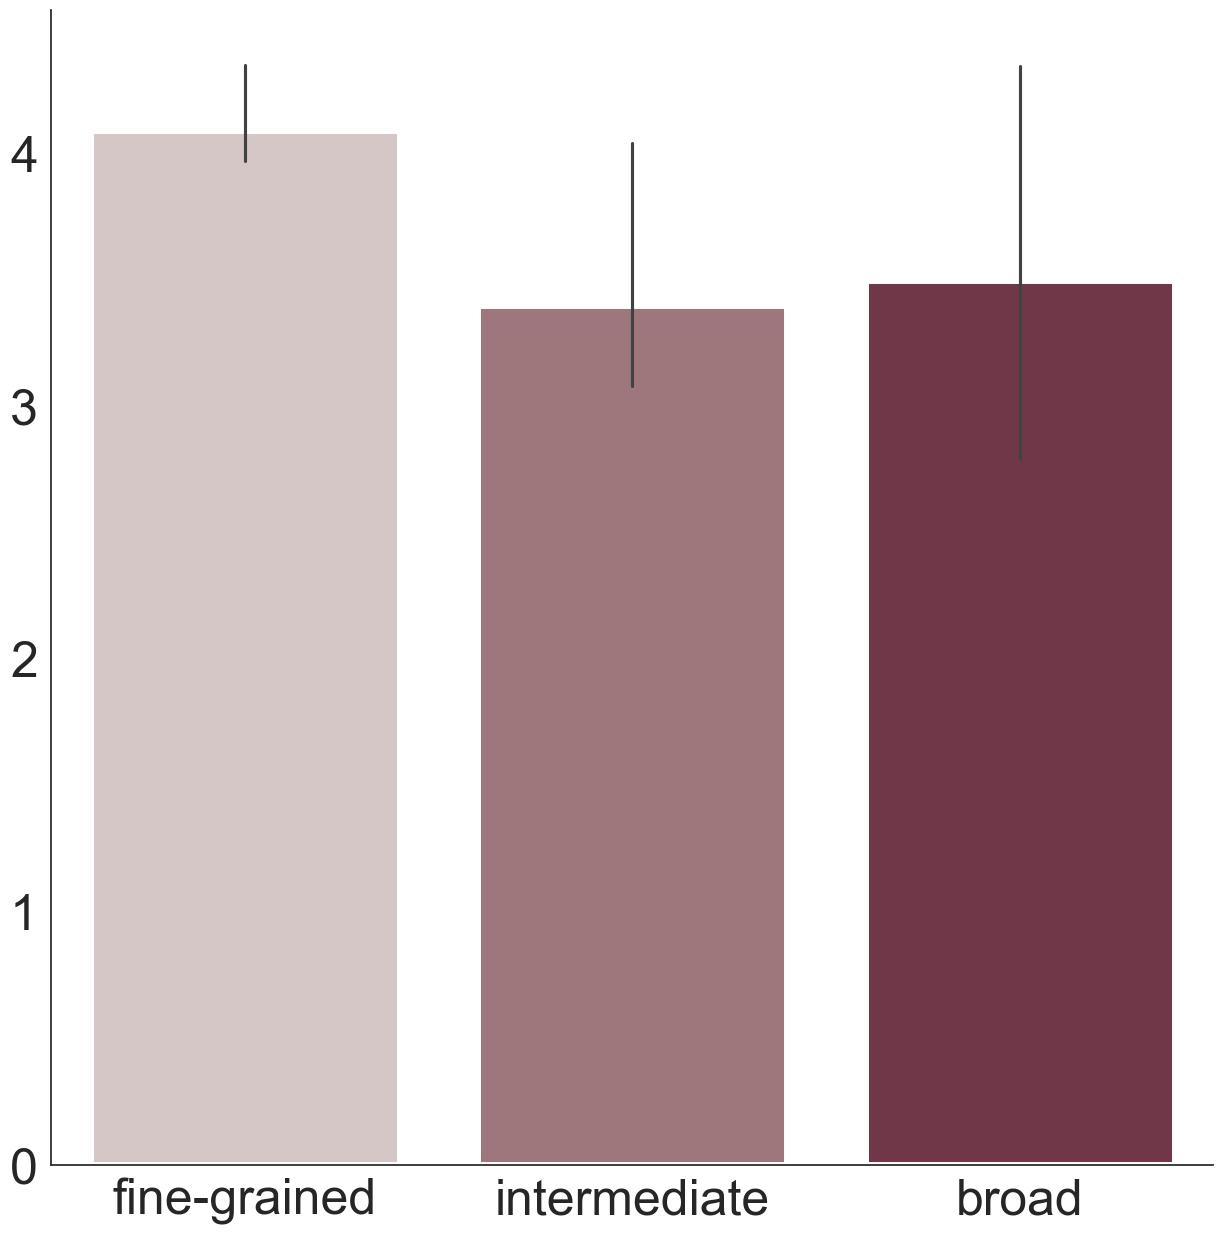

In [101]:
#Here, we check the biological cohesiveness of the enrichment terms for each dividing community

column_names = ["resnik", "louvain Iteration"]
labels=['fine-grained','intermediate','broad']
resnik_list_tot=[]
group_list=[]
for i in finegrained_enriched_terms_resnik_clean:
    resnik_list_tot.append(i)
    group_list.append("fine-grained")
    
for i in middle_enriched_terms_resnik_clean:
    resnik_list_tot.append(i)
    group_list.append("intermediate")

for i in broad_enriched_terms_resnik_clean:
    resnik_list_tot.append(i)
    group_list.append("broad")
    
EEN_louvain_com_df = pd.DataFrame(columns = column_names)
EEN_louvain_com_df["resnik"]=resnik_list_tot
EEN_louvain_com_df["Louvain Iteration"]=group_list


fig, ax = plt.subplots(figsize=(15, 15))
sns.set(style="white")

g=sns.barplot(x=EEN_louvain_com_df["Louvain Iteration"], y=EEN_louvain_com_df["resnik"],estimator=np.median, hue=EEN_louvain_com_df["Louvain Iteration"], palette=['#D8C4C5','#A47179','#7A2D45'],legend=False,linewidth=5)


ax.set_xlabel("",fontsize=32)
ax.set_ylabel("",fontsize=32)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)
ax.set_xticklabels(labels, size = 36)
#plt.savefig('Figures/SF5C_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()

In [102]:


records = []

color_map = {
    "fine-grained": "#D8C4C5",
    "intermediate": "#A47179",
    "broad": "#7A2D45"
}

for v in finegrained_enriched_terms_resnik_clean:
    records.append({
        "resnik": float(v),
        "Louvain_iteration": "fine-grained",
        "color": color_map["fine-grained"]
    })

for v in middle_enriched_terms_resnik_clean:
    records.append({
        "resnik": float(v),
        "Louvain_iteration": "intermediate",
        "color": color_map["intermediate"]
    })

for v in broad_enriched_terms_resnik_clean:
    records.append({
        "resnik": float(v),
        "Louvain_iteration": "broad",
        "color": color_map["broad"]
    })

barplot_source_df = pd.DataFrame(records)

# ---------- append BOTH to existing Excel ----------

excel_path = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(
        excel_path,
        engine="openpyxl",
        mode="a",
        if_sheet_exists="new"
    ) as writer:

    barplot_source_df.to_excel(
        writer,
        sheet_name="SF8C",
        index=False
    )



In [ ]:
t_value,p_value=stats.ttest_ind(finegrained_enriched_terms_resnik_clean,middle_enriched_terms_resnik_clean)
print("The p-value between fine-grained and middle communities GO Resnik distributions is %s" %p_value)
t_value,p_value=stats.ttest_ind(broad_enriched_terms_resnik_clean,middle_enriched_terms_resnik_clean)
print("The p-value between broad and middle communities of GO Resnik distributions is %s" %p_value)
t_value,p_value=stats.ttest_ind(broad_enriched_terms_resnik_clean,finegrained_enriched_terms_resnik_clean)
print("The p-value between broad and fine-grained communities of GO Resnik distributions is %s" %p_value)

/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_68905/4204542762.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(i) for i in list(ax.get_xticks())], size = 36)
/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_68905/4204542762.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)


Text(0, 0.5, '')

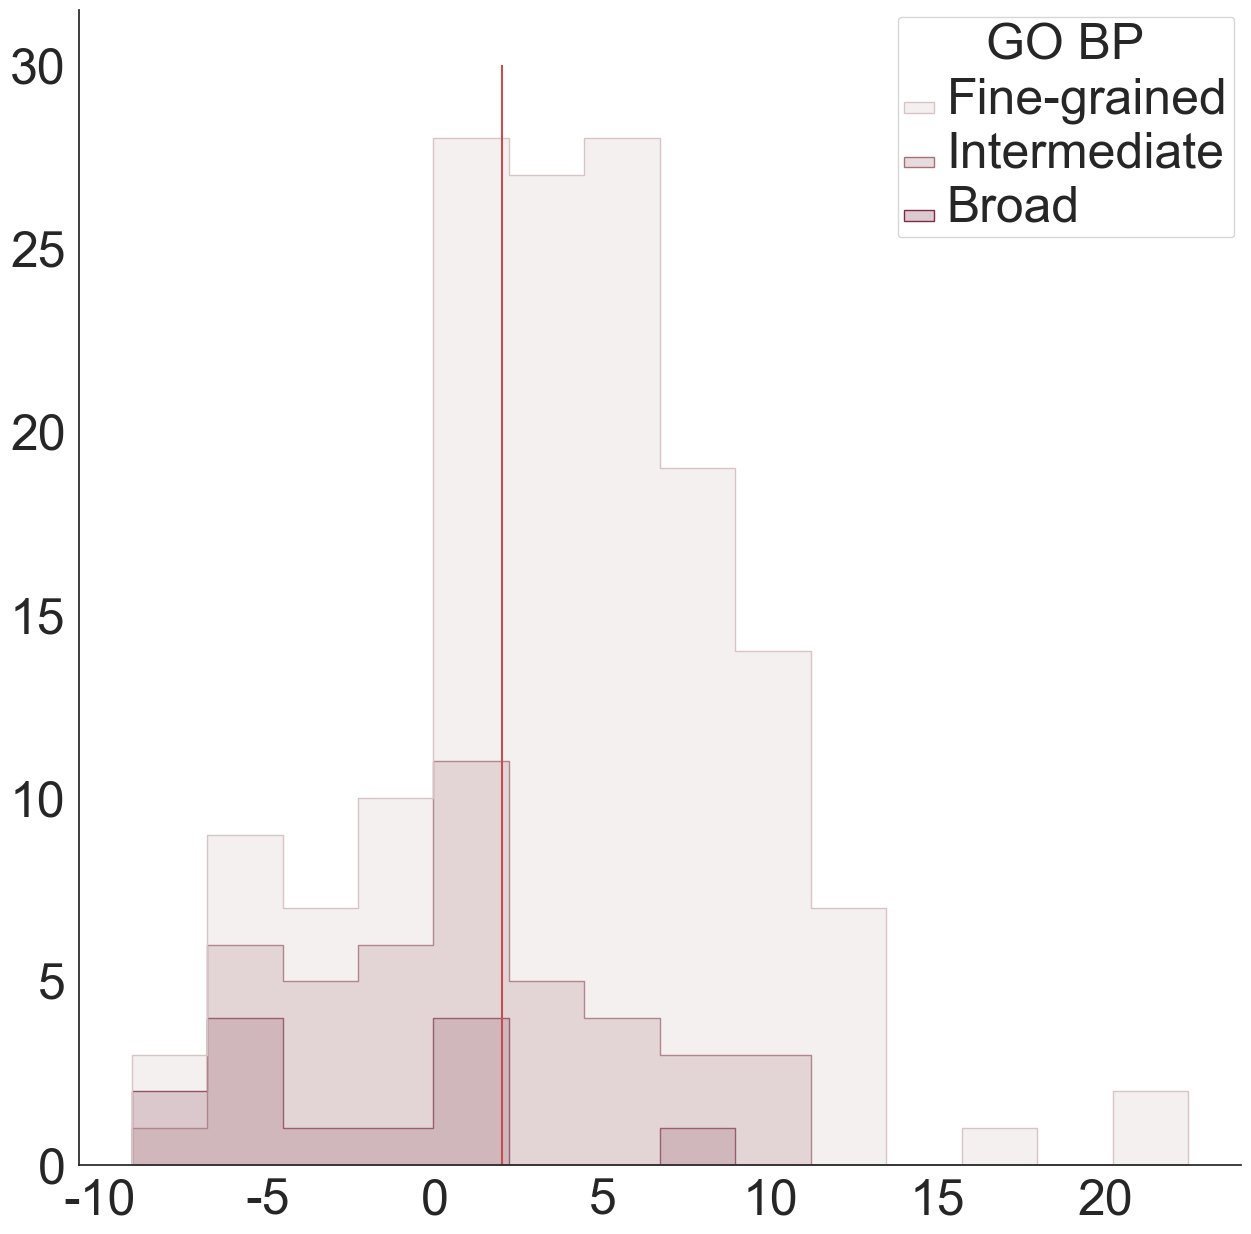

In [95]:

goterms_resnik_zscore_df=pd.DataFrame()

finegrained_BP_resnik_zscore=[]
iteration=[]
for com, zscore_list in rd_fine_grained_communities_gobp_resnik.items():
    if str(zscore_list[1])!="nan" and str(zscore_list[1])!="inf":
        finegrained_BP_resnik_zscore.append(float(zscore_list[1]))
        iteration.append("Fine-grained")

middle_BP_resnik_zscore=[]
for com, zscore_list in rd_middle_communities_gobp_resnik.items():
    if str(zscore_list[1])!="nan" and str(zscore_list[1])!="inf":
        middle_BP_resnik_zscore.append(float(zscore_list[1]))
        iteration.append("Intermediate")

broad_BP_resnik_zscore=[]
for com, zscore_list in rd_broad_communities_gobp_resnik.items():
    if str(zscore_list[1])!="nan" and str(zscore_list[1])!="inf":
        broad_BP_resnik_zscore.append(float(zscore_list[1]))
        iteration.append("Broad")    


goterms_resnik_zscore_df['zscore']=finegrained_BP_resnik_zscore+middle_BP_resnik_zscore+broad_BP_resnik_zscore
goterms_resnik_zscore_df['GO BP']=iteration
fig, ax = plt.subplots(figsize=(15,15))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

#plt.yscale('log')
plt.vlines(x=2,ymin=0,ymax=30,color='r',label='random thershold')
#plt.title('Distribution of lcc z-score for enriched terms GO CC of EEN communities across iterations', fontsize=28)
sns.histplot(
    goterms_resnik_zscore_df, x="zscore", hue="GO BP", element="step",palette=['#D8C4C5','#A47179','#7A2D45']
)
ax.set_xticklabels([int(i) for i in list(ax.get_xticks())], size = 36)
ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)
plt.setp(ax.get_legend().get_texts(), fontsize='36') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='36') # for legend title
plt.xlabel('',fontsize=36)
plt.ylabel('', fontsize=36)
#plt.savefig('output/Figures/SF5B_1_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")


In [96]:

palette_map = {
    "Fine-grained": "#D8C4C5",
    "Intermediate": "#A47179",
    "Broad": "#7A2D45"
}

goterms_resnik_zscore_df["Color"] = goterms_resnik_zscore_df["GO BP"].map(palette_map)

# Append to your existing SourceData Excel
excel_path = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(
        excel_path,
        engine="openpyxl",
        mode="a",
        if_sheet_exists="new"
    ) as writer:
    goterms_resnik_zscore_df.to_excel(
        writer,
        sheet_name="SF8B_part1",
        index=False
    )


/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_68905/3998784595.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(i) for i in list(ax.get_xticks())], size = 36)
/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_68905/3998784595.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)


Text(0, 0.5, '')

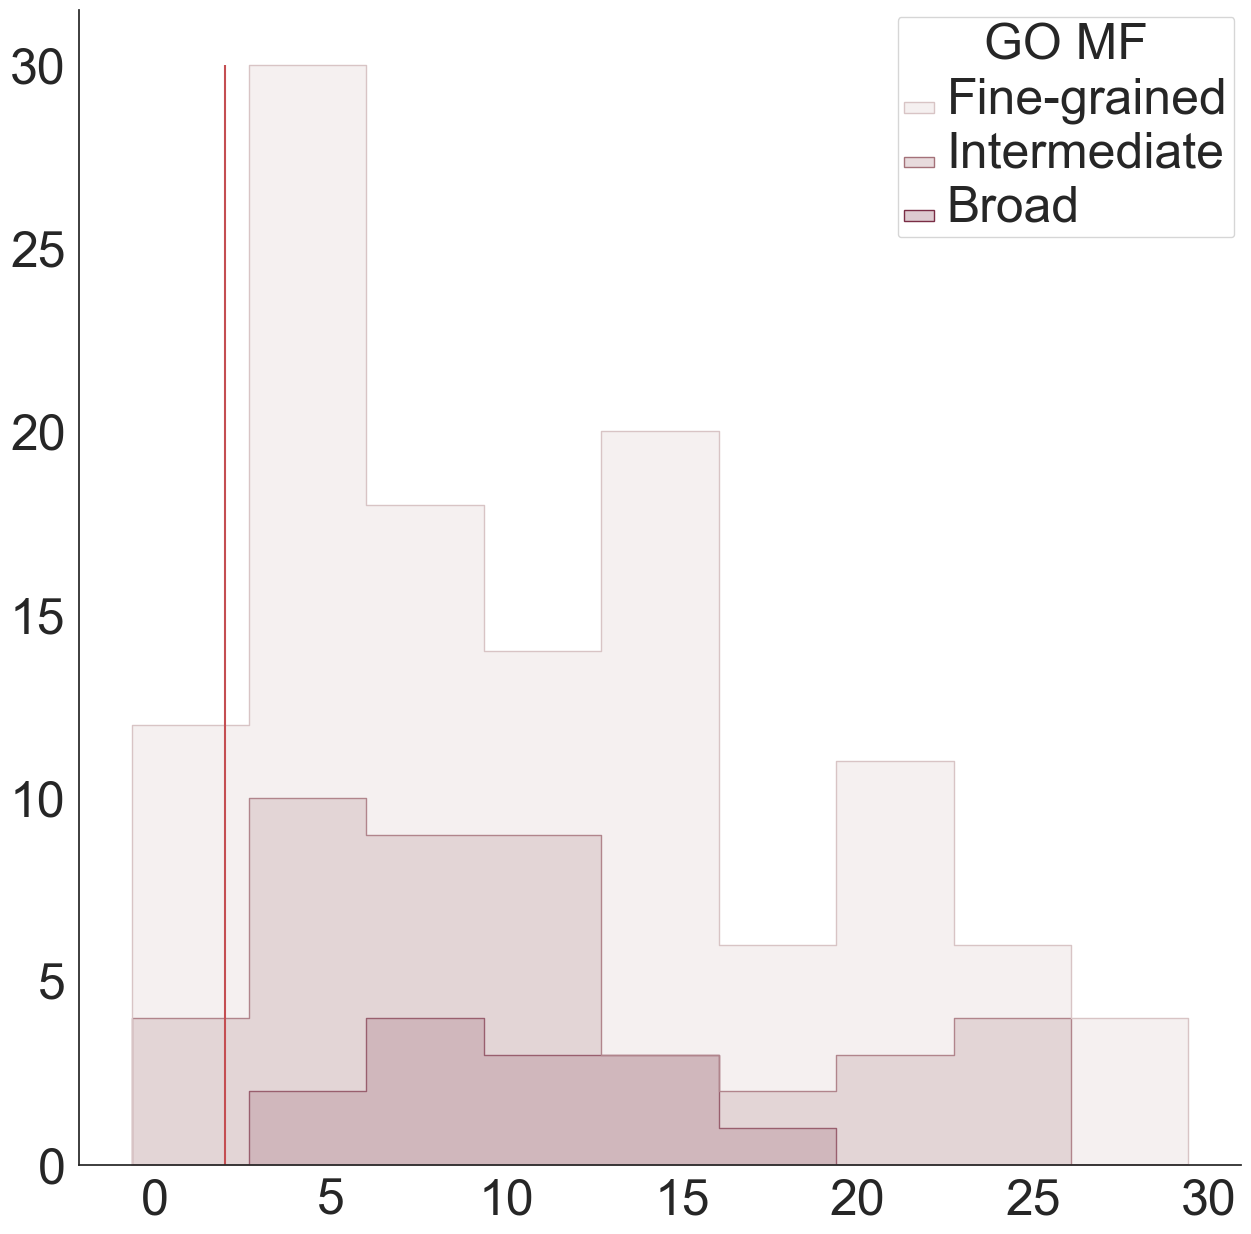

In [97]:

goterms_resnik_zscore_df=pd.DataFrame()

finegrained_MF_resnik_zscore=[]
iteration=[]
for com, zscore_list in rd_fine_grained_communities_gomf_resnik.items():
    if str(zscore_list[1])!="nan" and str(zscore_list[1])!="inf":
        finegrained_MF_resnik_zscore.append(float(zscore_list[1]))
        iteration.append("Fine-grained")

middle_MF_resnik_zscore=[]
for com, zscore_list in rd_middle_communities_gomf_resnik.items():
    if str(zscore_list[1])!="nan" and str(zscore_list[1])!="inf":
        middle_MF_resnik_zscore.append(float(zscore_list[1]))
        iteration.append("Intermediate")

broad_MF_resnik_zscore=[]
for com, zscore_list in rd_broad_communities_gomf_resnik.items():
    if str(zscore_list[1])!="nan" and str(zscore_list[1])!="inf":
        broad_MF_resnik_zscore.append(float(zscore_list[1]))
        iteration.append("Broad")    


goterms_resnik_zscore_df['zscore']=finegrained_MF_resnik_zscore+middle_MF_resnik_zscore+broad_MF_resnik_zscore
goterms_resnik_zscore_df['GO MF']=iteration
fig, ax = plt.subplots(figsize=(15,15))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

#plt.yscale('log')
plt.vlines(x=2,ymin=0,ymax=30,color='r',label='random thershold')
#plt.title('Distribution of lcc z-score for enriched terms GO CC of EEN communities across iterations', fontsize=28)
sns.histplot(
    goterms_resnik_zscore_df, x="zscore", hue="GO MF", element="step",palette=['#D8C4C5','#A47179','#7A2D45']
)
ax.set_xticklabels([int(i) for i in list(ax.get_xticks())], size = 36)
ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)
plt.setp(ax.get_legend().get_texts(), fontsize='36') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='36') # for legend title
plt.xlabel('',fontsize=36)
plt.ylabel('', fontsize=36)
#plt.savefig('output/Figures/SF5B_2_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")


In [98]:

palette_map = {
    "Fine-grained": "#D8C4C5",
    "Intermediate": "#A47179",
    "Broad": "#7A2D45"
}

goterms_resnik_zscore_df["Color"] = goterms_resnik_zscore_df["GO MF"].map(palette_map)

# Append to your existing SourceData Excel
excel_path = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(
        excel_path,
        engine="openpyxl",
        mode="a",
        if_sheet_exists="new"
    ) as writer:
    goterms_resnik_zscore_df.to_excel(
        writer,
        sheet_name="SF8B_part2",
        index=False
    )


/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_68905/3156394962.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(i) for i in list(ax.get_xticks())], size = 36)
/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_68905/3156394962.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)


Text(0, 0.5, '')

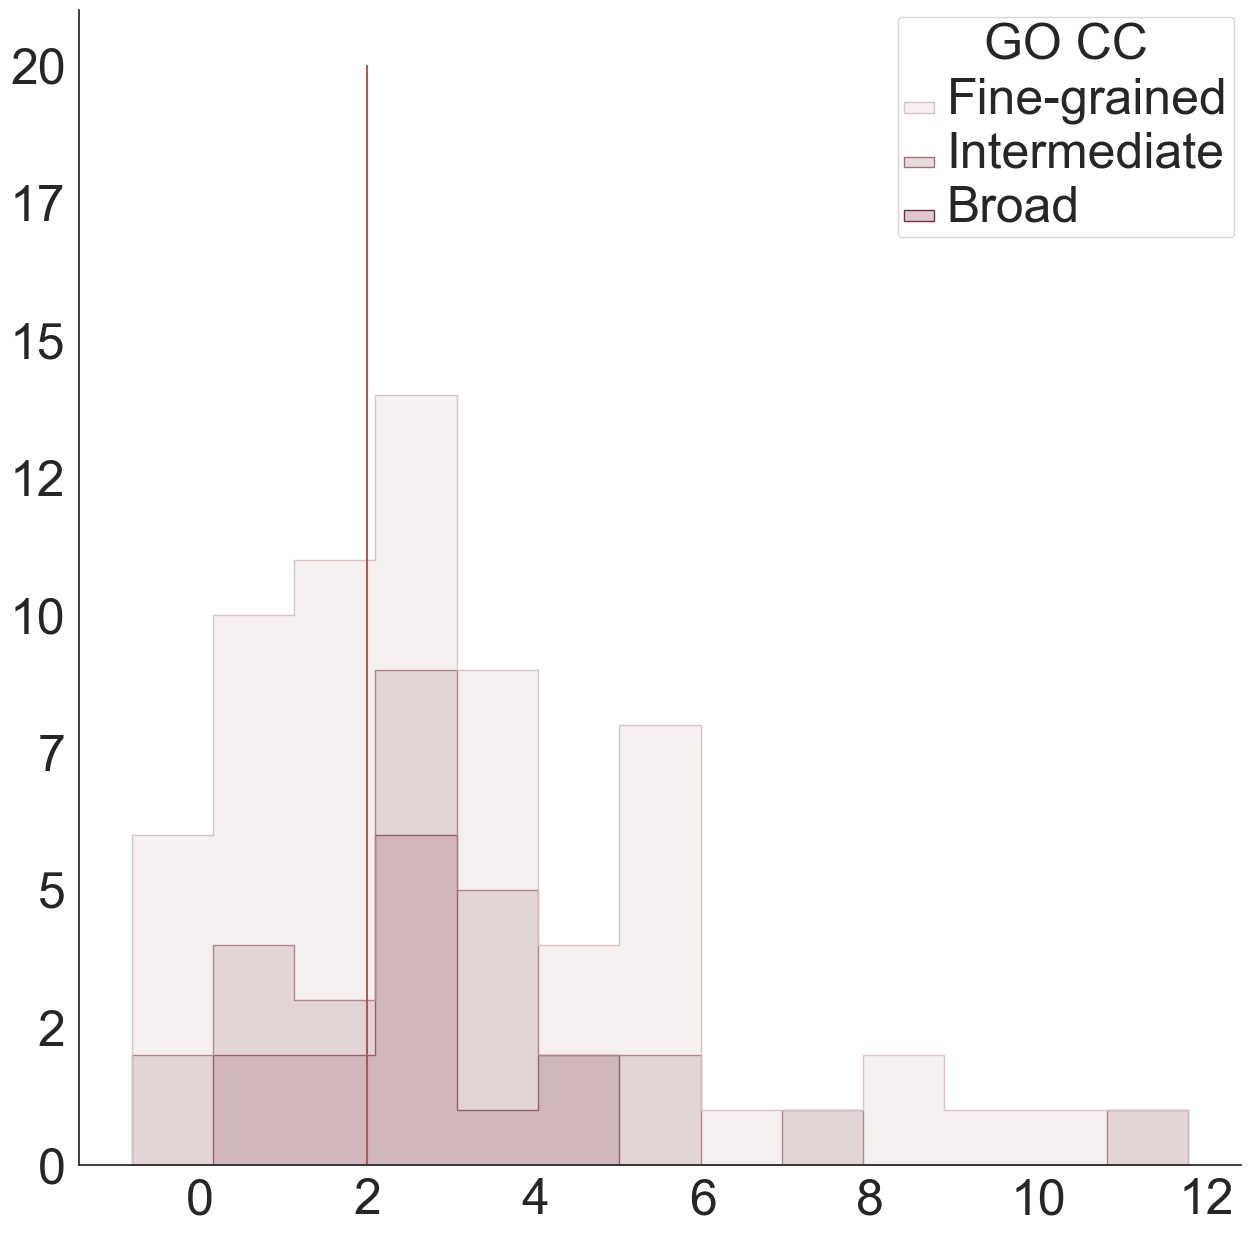

In [99]:

goterms_resnik_zscore_df=pd.DataFrame()

finegrained_CC_resnik_zscore=[]
iteration=[]
for com, zscore_list in rd_fine_grained_communities_gocc_resnik.items():
    if str(zscore_list[1])!="nan" and str(zscore_list[1])!="inf":
        finegrained_CC_resnik_zscore.append(float(zscore_list[1]))
        iteration.append("Fine-grained")

middle_CC_resnik_zscore=[]
for com, zscore_list in rd_middle_communities_gocc_resnik.items():
    if str(zscore_list[1])!="nan" and str(zscore_list[1])!="inf":
        middle_CC_resnik_zscore.append(float(zscore_list[1]))
        iteration.append("Intermediate")

broad_CC_resnik_zscore=[]
for com, zscore_list in rd_broad_communities_gocc_resnik.items():
    if str(zscore_list[1])!="nan" and str(zscore_list[1])!="inf":
        broad_CC_resnik_zscore.append(float(zscore_list[1]))
        iteration.append("Broad")    


goterms_resnik_zscore_df['zscore']=finegrained_CC_resnik_zscore+middle_CC_resnik_zscore+broad_CC_resnik_zscore
goterms_resnik_zscore_df['GO CC']=iteration
fig, ax = plt.subplots(figsize=(15,15))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

#plt.yscale('log')
plt.vlines(x=2,ymin=0,ymax=20,color='r',label='random thershold')
#plt.title('Distribution of lcc z-score for enriched terms GO CC of EEN communities across iterations', fontsize=28)
sns.histplot(
    goterms_resnik_zscore_df, x="zscore", hue="GO CC", element="step",palette=['#D8C4C5','#A47179','#7A2D45']
)
ax.set_xticklabels([int(i) for i in list(ax.get_xticks())], size = 36)
ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)
plt.setp(ax.get_legend().get_texts(), fontsize='36') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='36') # for legend title
plt.xlabel('',fontsize=36)
plt.ylabel('', fontsize=36)
#plt.savefig('output/Figures/SF5B_3_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")


In [100]:

palette_map = {
    "Fine-grained": "#D8C4C5",
    "Intermediate": "#A47179",
    "Broad": "#7A2D45"
}

goterms_resnik_zscore_df["Color"] = goterms_resnik_zscore_df["GO CC"].map(palette_map)

# Append to your existing SourceData Excel
excel_path = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(
        excel_path,
        engine="openpyxl",
        mode="a",
        if_sheet_exists="new"
    ) as writer:
    goterms_resnik_zscore_df.to_excel(
        writer,
        sheet_name="SF8B_part3",
        index=False
    )


In [330]:
#Let's check whether these communities are more precise on determining the mechanism of action of the perturbations

#Biological classes from CTD
biological_class =['folding','metabolic','stability','splicing','mutagenesis','localization','abundance','response_to_substance','transport','binding','activity','reaction','cotreatment','expression']

bio_el_gene_dict = {}   #Let's create a dictionary with the associated genes to each biological class
for bio_el in biological_class:
    associations = []
    gene_list = []
    for i,v in chem_homo.iterrows():
        if bio_el in v['InteractionActions']:
            associations.append(str(v['ChemicalID'])+','+str(v['GeneSymbol']))
            gene_list.append(str(v['GeneSymbol']))
    bio_el_gene_dict[bio_el] = set(gene_list)

In [332]:
import scipy  
from scipy import stats

def overlap_jaccard(list1,list2):
    intersction_term= len(set(list1) & set(list2))
    denominator = len(set(list1).union(set(list2)))
    overlap_jaccard_coeff = intersction_term/denominator
    return overlap_jaccard_coeff
    
#Here, we define the fisher test that we will use
def overlap_set(setA, setB,background):    
    """
    Accepts to lists
    M is the population size (previously N)
    n is the number of successes in the population
    N is the sample size (previously n)
    x is still the number of drawn “successes”
    """
    M= background #total number of exposures in chem_gene_cleaned
    n= len(setA)
    N= len(setB)
    x= len(setA.intersection(setB))
    return str(stats.hypergeom.sf(x-1, M, n, N))

#Here we define the adjustment
from statsmodels.sandbox.stats.multicomp import multipletests
def fdr_adjustment(list_of_pvals,alpha):    
    return multipletests(list_of_pvals,alpha=alpha,method='fdr_bh')[1] #the benjamin hochberg method is used

In [333]:
fine_grained_bio_pval_dict={}
fine_grained_bio_fdr_dict={}

for com,chemlist in fine_grained_communities_dict.items():
    genelist = []
    for chem in chemlist:
        for gene in chem_gene_cleaned[chem]:
            if gene not in genelist:
                genelist.append(gene)
    for bioel,geneset in bio_el_gene_dict.items():
        fine_grained_bio_pval_dict[com,bioel]=float(overlap_set(set(genelist),set(geneset),25580))

adj_pval=fdr_adjustment(list(fine_grained_bio_pval_dict.values()),0.05)
pair_list=list(fine_grained_bio_pval_dict.keys())
for i in range(len(adj_pval)):
    fine_grained_bio_fdr_dict[pair_list[i]]=adj_pval[i]


middle_bio_pval_dict={}
middle_bio_fdr_dict={}

for com,chemlist in middle_communities_dict.items():
    genelist = []
    for chem in chemlist:
        for gene in chem_gene_cleaned[chem]:
            if gene not in genelist:
                genelist.append(gene)
    for bioel,geneset in bio_el_gene_dict.items():
        middle_bio_pval_dict[com,bioel]=float(overlap_set(set(genelist),set(geneset),25580))

adj_pval=fdr_adjustment(list(middle_bio_pval_dict.values()),0.05)
pair_list=list(middle_bio_pval_dict.keys())
for i in range(len(adj_pval)):
    middle_bio_fdr_dict[pair_list[i]]=adj_pval[i]

broad_bio_pval_dict={}
broad_bio_fdr_dict={}

for com,chemlist in broad_communities_dict.items():
    genelist = []
    for chem in chemlist:
        for gene in chem_gene_cleaned[chem]:
            if gene not in genelist:
                genelist.append(gene)
    for bioel,geneset in bio_el_gene_dict.items():
        broad_bio_pval_dict[com,bioel]=float(overlap_set(set(genelist),set(geneset),25580))

adj_pval=fdr_adjustment(list(broad_bio_pval_dict.values()),0.05)
pair_list=list(broad_bio_pval_dict.keys())
for i in range(len(adj_pval)):
    broad_bio_fdr_dict[pair_list[i]]=adj_pval[i]

In [336]:

sig_broad_bio_dict = {}
for com in set(broad_communities_dict.keys()):
    bio_list = []
    for combio,fdr in broad_bio_fdr_dict.items():
        if fdr<0.05:
            bio_list.append(combio[1])
    sig_broad_bio_dict[com] = bio_list

sig_middle_bio_dict = {}
for com in set(middle_communities_dict.keys()):
    bio_list = []
    for combio,fdr in middle_bio_fdr_dict.items():
        if fdr<0.05:
            bio_list.append(combio[1])
    sig_middle_bio_dict[com] = bio_list

sig_fine_grained_bio_dict = {}
for com in set(fine_grained_communities_dict.keys()):
    bio_list = []
    for combio,fdr in fine_grained_bio_fdr_dict.items():
        if fdr<0.05:
            bio_list.append(combio[1])
    sig_fine_grained_bio_dict[com] = bio_list
    

In [338]:
uniquebio_broad_list = []
for com,biolist in sig_broad_bio_dict.items():
    if len(biolist)==1:
        uniquebio_broad_list.append(com)

uniquebio_middle_list = []
for com,biolist in sig_middle_bio_dict.items():
    if len(biolist)==1:
        uniquebio_middle_list.append(com)

uniquebio_fine_grained_list = []
for com,biolist in sig_fine_grained_bio_dict.items():
    if len(biolist)==1:
        uniquebio_fine_grained_list.append(com)
        

In [344]:
#Let's try with the genes that are shared within each community

special_fine_grained_bio_pval_dict={}
special_fine_grained_bio_fdr_dict={}

for com,explist in fine_grained_communities_dict.items():
    gene_list=[]
    if len(explist)>1:
        G_sub = nx.subgraph(filtered_weighted_exp_graph_significant,explist)   #let's create the subgraph corresponding to the cluster
        for edge in G_sub.edges():
            overlap_geneset=chem_gene_cleaned[edge[0]] & chem_gene_cleaned[edge[1]]
            for gene in overlap_geneset:
                gene_list.append(gene)
    for bioel,geneset in bio_el_gene_dict.items():
        special_fine_grained_bio_pval_dict[com,bioel]=float(overlap_set(set(gene_list),set(geneset),25580))

adj_pval=fdr_adjustment(list(special_fine_grained_bio_pval_dict.values()),0.05)
pair_list=list(special_fine_grained_bio_pval_dict.keys())
for i in range(len(adj_pval)):
    special_fine_grained_bio_fdr_dict[pair_list[i]]=adj_pval[i]

special_middle_bio_pval_dict={}
special_middle_bio_fdr_dict={}

for com,explist in middle_communities_dict.items():
    gene_list=[]
    if len(explist)>1:
        G_sub = nx.subgraph(filtered_weighted_exp_graph_significant,explist)   #let's create the subgraph corresponding to the cluster
        for edge in G_sub.edges():
            overlap_geneset=chem_gene_cleaned[edge[0]] & chem_gene_cleaned[edge[1]]
            for gene in overlap_geneset:
                gene_list.append(gene)
    for bioel,geneset in bio_el_gene_dict.items():
        special_middle_bio_pval_dict[com,bioel]=float(overlap_set(set(gene_list),set(geneset),25580))

adj_pval=fdr_adjustment(list(special_middle_bio_pval_dict.values()),0.05)
pair_list=list(special_middle_bio_pval_dict.keys())
for i in range(len(adj_pval)):
    special_middle_bio_fdr_dict[pair_list[i]]=adj_pval[i]


special_broad_bio_pval_dict={}
special_broad_bio_fdr_dict={}

for com,explist in broad_communities_dict.items():
    gene_list=[]
    if len(explist)>1:
        G_sub = nx.subgraph(filtered_weighted_exp_graph_significant,explist)   #let's create the subgraph corresponding to the cluster
        for edge in G_sub.edges():
            overlap_geneset=chem_gene_cleaned[edge[0]] & chem_gene_cleaned[edge[1]]
            for gene in overlap_geneset:
                gene_list.append(gene)
    for bioel,geneset in bio_el_gene_dict.items():
        special_broad_bio_pval_dict[com,bioel]=float(overlap_set(set(gene_list),set(geneset),25580))

adj_pval=fdr_adjustment(list(special_broad_bio_pval_dict.values()),0.05)
pair_list=list(special_broad_bio_pval_dict.keys())
for i in range(len(adj_pval)):
    special_broad_bio_fdr_dict[pair_list[i]]=adj_pval[i]


In [346]:
special_sig_broad_bio_dict = {}
for com in set(broad_communities_dict.keys()):
    bio_list = []
    for combio,fdr in special_broad_bio_fdr_dict.items():
        if fdr<0.05:
            bio_list.append(combio[1])
    special_sig_broad_bio_dict[com] = bio_list

special_sig_middle_bio_dict = {}
for com in set(middle_communities_dict.keys()):
    bio_list = []
    for combio,fdr in special_middle_bio_fdr_dict.items():
        if fdr<0.05:
            bio_list.append(combio[1])
    special_sig_middle_bio_dict[com] = bio_list

special_sig_fine_grained_bio_dict = {}
for com in set(fine_grained_communities_dict.keys()):
    bio_list = []
    for combio,fdr in special_fine_grained_bio_fdr_dict.items():
        if fdr<0.05:
            bio_list.append(combio[1])
    special_sig_fine_grained_bio_dict[com] = bio_list

In [347]:
special_uniquebio_broad_list = []
for com,biolist in special_sig_broad_bio_dict.items():
    if len(biolist)==1:
        special_uniquebio_broad_list.append(com)

special_uniquebio_middle_list = []
for com,biolist in special_sig_middle_bio_dict.items():
    if len(biolist)==1:
        special_uniquebio_middle_list.append(com)

special_uniquebio_fine_grained_list = []
for com,biolist in special_sig_fine_grained_bio_dict.items():
    if len(biolist)==1:
        special_uniquebio_fine_grained_list.append(com)
        

In [354]:
special_uniquebio_broad_list = []
for com,biolist in special_sig_broad_bio_dict.items():
    if len(biolist)<3:
        special_uniquebio_broad_list.append(com)

special_uniquebio_middle_list = []
for com,biolist in special_sig_middle_bio_dict.items():
    if len(biolist)<3:
        special_uniquebio_middle_list.append(com)

special_uniquebio_fine_grained_list = []
for com,biolist in special_sig_fine_grained_bio_dict.items():
    if len(biolist)<3:
        special_uniquebio_fine_grained_list.append(com)
        

In [ ]:
#Let's calculate the word embedding with node2vec
#This calculation will be done on the cluster due to high memory demand
#It is possible to find under Node2vec.py

import pickle as pk
import networkx as nx
from pecanpy.graph import AdjlstGraph
from pecanpy import pecanpy as node2vec

filtered_weighted_exp_graph_significant = nx.read_weighted_edgelist("backbone_exp_graph_significant_weighted.edgelist")

filtered_unweighted_exp_graph_significant=nx.Graph()
for e in filtered_weighted_exp_graph_significant.edges():
    filtered_unweighted_exp_graph_significant.add_edge(*e)

g = AdjlstGraph()
for e in list(filtered_weighted_exp_graph_significant.edges()):
    weight = filtered_weighted_exp_graph_significant[e[0]][e[1]]["weight"]
    g.add_edge(e[0],e[1],weight)
g.save("filtered_weighted_exp_graph_significant_new.edg")
g = node2vec.PreComp(p=1, q=1, workers=20, verbose=True,extend=True)
g.read_edg("filtered_weighted_exp_graph_significant_new.edg", weighted=True, directed=False)
g.preprocess_transition_probs()

filtered_weighted_emd = g.embed(dim=128,num_walks=200,walk_length=50)
#Let's write the results
with open('filtered_weighted_emd.pickle', 'wb') as handle:
    pk.dump(filtered_weighted_emd, handle, protocol=pk.HIGHEST_PROTOCOL)

g = AdjlstGraph()
for e in list(filtered_unweighted_exp_graph_significant.edges()):
    g.add_edge(e[0],e[1])
g.save("filtered_unweighted_exp_graph_significant_new.edg")

g = node2vec.PreComp(p=1, q=1, workers=20, verbose=True,extend=True)
g.read_edg("filtered_unweighted_exp_graph_significant_new.edg", weighted=False, directed=False)
g.preprocess_transition_probs()
filtered_unweighted_emd = g.embed(dim=128,num_walks=200,walk_length=50)
#Let's write the results
with open('filtered_unweighted_emd.pickle', 'wb') as handle:
    pk.dump(filtered_unweighted_emd, handle, protocol=pk.HIGHEST_PROTOCOL)


unfiltered_weighted_exp_graph_significant = nx.read_weighted_edgelist("unfiltered_weighted_exp_graph_significant.edgelist")

unfiltered_unweighted_exp_graph_significant=nx.Graph()
for e in unfiltered_weighted_exp_graph_significant.edges():
    unfiltered_unweighted_exp_graph_significant.add_edge(*e)

g = AdjlstGraph()
for e in list(unfiltered_unweighted_exp_graph_significant.edges()):
    g.add_edge(e[0],e[1])
g.save("unfiltered_unweighted_exp_graph_significant_new.edg")
g = node2vec.PreComp(p=1, q=1, workers=20, verbose=False,extend=True)
g.read_edg("unfiltered_unweighted_exp_graph_significant_new.edg", weighted=False, directed=False)
g.preprocess_transition_probs()
unfiltered_unweighted_emd = g.embed(dim=128,num_walks=200,walk_length=50)
#Let's write the results
with open('unfiltered_unweighted_emd.pickle', 'wb') as handle:
    pk.dump(unfiltered_unweighted_emd, handle, protocol=pk.HIGHEST_PROTOCOL)

g = AdjlstGraph()
for e in list(unfiltered_weighted_exp_graph_significant.edges()):
    weight = unfiltered_weighted_exp_graph_significant[e[0]][e[1]]["weight"]
    g.add_edge(e[0],e[1],weight)
g.save("unfiltered_weighted_exp_graph_significant_new.edg")
g = node2vec.PreComp(p=1, q=1, workers=20, verbose=False,extend=True)
g.read_edg("unfiltered_weighted_exp_graph_significant_new.edg", weighted=True, directed=False)
g.preprocess_transition_probs()
unfiltered_weighted_emd = g.embed(dim=128,num_walks=200,walk_length=50)
#Let's write the results
with open('unfiltered_weighted_emd.pickle', 'wb') as handle:
    pk.dump(unfiltered_weighted_emd, handle, protocol=pk.HIGHEST_PROTOCOL)

In [23]:
#Let's import the results
with open('output/Communities/filtered_weighted_emd.pickle', 'rb') as handle:
    filtered_weighted_exp_embeddings = pk.load(handle)

with open('output/Communities/filtered_unweighted_emd.pickle', 'rb') as handle:
    filtered_unweighted_exp_embeddings = pk.load(handle)

with open('output/Communities/unfiltered_unweighted_emd.pickle', 'rb') as handle:
    unfiltered_unweighted_exp_embeddings = pk.load(handle)

with open('output/Communities/unfiltered_weighted_emd.pickle', 'rb') as handle:
    unfiltered_weighted_exp_embeddings = pk.load(handle)

In [24]:

with open('output/Communities/filtered_weighted_node_order.pickle', 'rb') as handle:
    filtered_weighted_node_order = pk.load(handle)


with open('output/Communities/filtered_unweighted_node_order.pickle', 'rb') as handle:
    filtered_unweighted_node_order = pk.load(handle)


with open('output/Communities/unfiltered_weighted_node_order.pickle', 'rb') as handle:
    unfiltered_weighted_node_order = pk.load(handle)


with open('output/Communities/unfiltered_unweighted_node_order.pickle', 'rb') as handle:
    unfiltered_unweighted_node_order = pk.load(handle)

In [27]:
#FILTERED-WEIGHTED
#Let's calculate the communities
dendo = community_louvain.generate_dendrogram(filtered_weighted_exp_graph_significant,weight='weight', resolution=0.9, random_state=5495)
#Let's define the three hierarchical communities as dictionaries
ee_first_louvain_iteration_exposures={}   
for com in set(list(dendo[0].values())):
    exp_list=[]
    for exp, comcom in dendo[0].items():
        if com==comcom:
            exp_list.append(exp)
    ee_first_louvain_iteration_exposures[com]=exp_list

filtered_weighted_louvain_labels = []
for node in filtered_weighted_node_order:
    for com,explist in ee_first_louvain_iteration_exposures.items():
        if node in explist:
            filtered_weighted_louvain_labels.append(com)
            
calinski_harabasz_score_val = calinski_harabasz_score(filtered_weighted_exp_embeddings, filtered_weighted_louvain_labels)
davies_bouldin_score_val = davies_bouldin_score(filtered_weighted_exp_embeddings, filtered_weighted_louvain_labels)
sil_score_louvain = silhouette_score(filtered_weighted_exp_embeddings, filtered_weighted_louvain_labels)

print("calinski_harabasz:%s" %calinski_harabasz_score_val)
print("davies_bouldin:%s" %davies_bouldin_score_val)
print("Silhouette:%s" %sil_score_louvain)

calinski_harabasz:48.998718224335576
davies_bouldin:0.8545220488648803
Silhouette:0.20448475


In [29]:
#FILTERED-UNWEIGHTED

#Let's calculate the communities
dendo = community_louvain.generate_dendrogram(filtered_weighted_exp_graph_significant, resolution=1, random_state=5495)
#Let's define the three hierarchical communities as dictionaries
ee_first_louvain_iteration_exposures={}   
for com in set(list(dendo[0].values())):
    exp_list=[]
    for exp, comcom in dendo[0].items():
        if com==comcom:
            exp_list.append(exp)
    ee_first_louvain_iteration_exposures[com]=exp_list

filtered_unweighted_louvain_labels = []
for node in filtered_unweighted_node_order:
    for com,explist in ee_first_louvain_iteration_exposures.items():
        if node in explist:
            filtered_unweighted_louvain_labels.append(com)
            

calinski_harabasz_score_val = calinski_harabasz_score(filtered_unweighted_exp_embeddings, filtered_unweighted_louvain_labels)
davies_bouldin_score_val = davies_bouldin_score(filtered_unweighted_exp_embeddings, filtered_unweighted_louvain_labels)
sil_score_louvain = silhouette_score(filtered_unweighted_exp_embeddings, filtered_unweighted_louvain_labels)

print("calinski_harabasz:%s" %calinski_harabasz_score_val)
print("davies_bouldin:%s" %davies_bouldin_score_val)
print("Silhouette:%s" %sil_score_louvain)

calinski_harabasz:47.87320228100893
davies_bouldin:0.974373504176772
Silhouette:0.16584326


In [30]:
#UNFILTERED-WEIGHTED

#Let's calculate the communities
dendo = community_louvain.generate_dendrogram(unfiltered_weighted_exp_graph_significant,weight='weight', resolution=1, random_state=5495)
#Let's define the three hierarchical communities as dictionaries
ee_first_louvain_iteration_exposures={}   
for com in set(list(dendo[0].values())):
    exp_list=[]
    for exp, comcom in dendo[0].items():
        if com==comcom:
            exp_list.append(exp)
    ee_first_louvain_iteration_exposures[com]=exp_list

unfiltered_weighted_louvain_labels = []
for node in unfiltered_weighted_node_order:
    for com,explist in ee_first_louvain_iteration_exposures.items():
        if node in explist:
            unfiltered_weighted_louvain_labels.append(com)


calinski_harabasz_score_val = calinski_harabasz_score(unfiltered_weighted_exp_embeddings, unfiltered_weighted_louvain_labels)
davies_bouldin_score_val = davies_bouldin_score(unfiltered_weighted_exp_embeddings, unfiltered_weighted_louvain_labels)
sil_score_louvain = silhouette_score(unfiltered_weighted_exp_embeddings, unfiltered_weighted_louvain_labels)

print("calinski_harabasz:%s" %calinski_harabasz_score_val)
print("davies_bouldin:%s" %davies_bouldin_score_val)
print("Silhouette:%s" %sil_score_louvain)

calinski_harabasz:45.56864840885285
davies_bouldin:0.8717574261122166
Silhouette:0.17963499


In [31]:
#UNFILTERED-UNWEIGHTED

#Let's calculate the communities
dendo = community_louvain.generate_dendrogram(unfiltered_unweighted_exp_graph_significant, resolution=1.1, random_state=5495)
#Let's define the three hierarchical communities as dictionaries
ee_first_louvain_iteration_exposures={}   
for com in set(list(dendo[0].values())):
    exp_list=[]
    for exp, comcom in dendo[0].items():
        if com==comcom:
            exp_list.append(exp)
    ee_first_louvain_iteration_exposures[com]=exp_list

unfiltered_unweighted_louvain_labels = []
for node in unfiltered_weighted_node_order:
    for com,explist in ee_first_louvain_iteration_exposures.items():
        if node in explist:
            unfiltered_unweighted_louvain_labels.append(com)


calinski_harabasz_score_val = calinski_harabasz_score(unfiltered_unweighted_exp_embeddings, unfiltered_unweighted_louvain_labels)
davies_bouldin_score_val = davies_bouldin_score(unfiltered_unweighted_exp_embeddings, unfiltered_unweighted_louvain_labels)
sil_score_louvain = silhouette_score(unfiltered_unweighted_exp_embeddings, unfiltered_unweighted_louvain_labels)

print("calinski_harabasz:%s" %calinski_harabasz_score_val)
print("davies_bouldin:%s" %davies_bouldin_score_val)
print("Silhouette:%s" %sil_score_louvain)

calinski_harabasz:162.69393149647308
davies_bouldin:2.1129890928432222
Silhouette:0.010248693


Gene Part
===

In [126]:
from community import community_louvain

#Here, we find the resolution parameter that optimizes Newman's modularity
def optimal_resolution_with_diagnostics_simple_network(G, resolution_list,weight,rd_state):
    max_modularity = -1
    modularity_scores = []
    for resolution in resolution_list:
        partition = community_louvain.best_partition(G, resolution=resolution,weight=weight,random_state=rd_state)
        modularity = community_louvain.modularity(partition,G)
        if modularity > max_modularity:   # save the partition and resolution giving the maximum modularity
            max_modularity = modularity
            best_partition = partition
            best_resolution = resolution
        modularity_scores.append((resolution, modularity))
    return best_partition, best_resolution, max_modularity, modularity_scores

#Here, we define a function that allows us to select the resolution parameter that corresponds to the 
#maximum value of modularity

def optimal_resolution(G, resolution_list,weight,random_state):
    """
    Param:
    G: A networkx graph
    resolution_list: List of resolution values to check
    """
    res_mod_dict = {}
    max_modularity = -1 # initialize maximum modularity as negative value
    for resolution in resolution_list:
        partition = community_louvain.best_partition(G, resolution=resolution,weight=weight,random_state=random_state)
        modularity = community_louvain.modularity(partition,G)
        res_mod_dict[resolution] = modularity
        if modularity > max_modularity:   # save the partition and resolution giving the maximum modularity
            max_modularity = modularity
            best_partition = partition
            best_resolution = resolution
            
    return best_partition, best_resolution, max_modularity,res_mod_dict

In [ ]:
#Here, we import the unfiltered and the backbone GGN

unfiltered_weighted_gene_graph_significant = nx.read_weighted_edgelist("output/unfiltered_weighted_gene_graph_significant.edgelist")
filtered_weighted_gene_graph_significant = nx.read_weighted_edgelist("output/backbone_gene_graph_significant_weighted.edgelist")


In [143]:
unfiltered_unweighted_gene_graph_significant=nx.Graph()
for e in unfiltered_weighted_gene_graph_significant.edges():
    unfiltered_unweighted_gene_graph_significant.add_edge(*e)

filtered_unweighted_gene_graph_significant=nx.Graph()
for e in filtered_weighted_gene_graph_significant.edges():
    filtered_unweighted_gene_graph_significant.add_edge(*e)


In [ ]:
resolution_list = np.linspace(0.1, 2, 10) 


unweight_unfiltered_ggn_best_partition, unweight_unfiltered_ggn_best_resolution, unweight_unfiltered_ggn_max_modularity, unweight_unfiltered_ggn_modularity_scores = optimal_resolution_with_diagnostics_simple_network(unfiltered_unweighted_gene_graph_significant, resolution_list,'weight',5495)

unweight_filtered_ggn_best_partition, unweight_filtered_ggn_best_resolution, unweight_filtered_ggn_max_modularity, unweight_filtered_ggn_modularity_scores = optimal_resolution_with_diagnostics_simple_network(filtered_unweighted_gene_graph_significant, resolution_list,'weight',5495)

weight_unfiltered_ggn_best_partition, weight_unfiltered_ggn_best_resolution, weight_unfiltered_ggn_max_modularity, weight_unfiltered_ggn_modularity_scores = optimal_resolution_with_diagnostics_simple_network(unfiltered_weighted_gene_graph_significant, resolution_list,'weight',5495)

weight_filtered_ggn_best_partition, weight_filtered_ggn_best_resolution, weight_filtered_ggn_max_modularity, weight_filtered_ggn_modularity_scores = optimal_resolution_with_diagnostics_simple_network(filtered_weighted_gene_graph_significant, resolution_list,'weight',5495)



In [ ]:

with open('intermediate/unweight_unfiltered_ggn_modularity_scores.txt', 'wb') as fp:
    pk.dump(unweight_unfiltered_ggn_modularity_scores, fp)

with open('intermediate/unweight_filtered_ggn_modularity_scores.txt', 'wb') as fp:
    pk.dump(unweight_filtered_ggn_modularity_scores, fp)

with open('intermediate/weight_unfiltered_ggn_modularity_scores.txt', 'wb') as fp:
    pk.dump(weight_unfiltered_ggn_modularity_scores, fp)

with open('intermediate/weight_filtered_ggn_modularity_scores.txt', 'wb') as fp:
    pk.dump(weight_filtered_ggn_modularity_scores, fp)

In [6]:
with open ('intermediate/unweight_unfiltered_ggn_modularity_scores.txt', 'rb') as fp:
    unweight_unfiltered_ggn_modularity_scores = pk.load(fp)

with open ('intermediate/unweight_filtered_ggn_modularity_scores.txt', 'rb') as fp:
    unweight_filtered_ggn_modularity_scores = pk.load(fp)

with open ('intermediate/weight_unfiltered_ggn_modularity_scores.txt', 'rb') as fp:
    weight_unfiltered_ggn_modularity_scores = pk.load(fp)

with open ('intermediate/weight_filtered_ggn_modularity_scores.txt', 'rb') as fp:
    weight_filtered_ggn_modularity_scores = pk.load(fp)



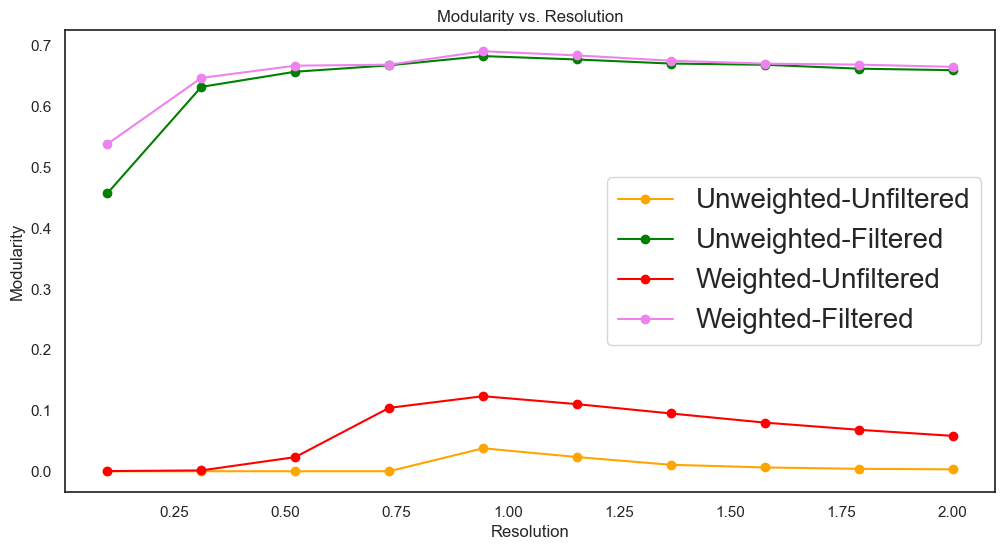

In [77]:
#This plot shows the relationship between resolution and modularity
plt.figure(figsize=(12, 6))
# Plot the modularity versus resolution

unweight_unfiltered_ggn_resolutions, unweight_unfiltered_ggn_modularities = zip(*unweight_unfiltered_ggn_modularity_scores)
unweight_filtered_ggn_resolutions, unweight_filtered_ggn_modularities = zip(*unweight_filtered_ggn_modularity_scores)
weight_unfiltered_ggn_resolutions, weight_unfiltered_ggn_modularities = zip(*weight_unfiltered_ggn_modularity_scores)
weight_filtered_ggn_resolutions, weight_filtered_ggn_modularities = zip(*weight_filtered_ggn_modularity_scores)


plt.plot(unweight_unfiltered_ggn_resolutions, unweight_unfiltered_ggn_modularities, marker='o',color="orange",label='Unweighted-Unfiltered')
plt.plot(unweight_filtered_ggn_resolutions, unweight_filtered_ggn_modularities, marker='o',color="green",label='Unweighted-Filtered')
plt.plot(weight_unfiltered_ggn_resolutions, weight_unfiltered_ggn_modularities, marker='o',color="red",label='Weighted-Unfiltered')
plt.plot(weight_filtered_ggn_resolutions, weight_filtered_ggn_modularities, marker='o',color="violet",label='Weighted-Filtered')

plt.xlabel('Resolution')
plt.ylabel('Modularity')
plt.title('Modularity vs. Resolution')
plt.legend(fontsize=20)
#plt.savefig('output/Figures/SF2C_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()



In [78]:


unweight_unfiltered_resolutions, unweight_unfiltered_modularities = zip(*unweight_unfiltered_ggn_modularity_scores)
unweight_filtered_een_resolutions, unweight_filtered_een_modularities = zip(*unweight_filtered_ggn_modularity_scores)
weight_unfiltered_een_resolutions, weight_unfiltered_eenn_modularities = zip(*weight_unfiltered_ggn_modularity_scores)
weight_filtered_een_resolutions, weight_filtered_een_modularities = zip(*weight_filtered_ggn_modularity_scores)

rows = []

def add_curve(condition, resolutions, modularities, color):
    for r, m in zip(resolutions, modularities):
        rows.append({
            "Condition": condition,
            "Resolution": r,
            "Modularity": m,
            "Color": color,
            "Marker": "o"
        })

add_curve("Unweighted-Unfiltered",
          unweight_unfiltered_resolutions,
          unweight_unfiltered_modularities,
          "orange")

add_curve("Unweighted-Filtered",
          unweight_filtered_een_resolutions,
          unweight_filtered_een_modularities,
          "green")

add_curve("Weighted-Unfiltered",
          weight_unfiltered_een_resolutions,
          weight_unfiltered_eenn_modularities,
          "red")

add_curve("Weighted-Filtered",
          weight_filtered_een_resolutions,
          weight_filtered_een_modularities,
          "violet")

modularity_source_df = pd.DataFrame(rows)

excel_path = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(
        excel_path,
        engine="openpyxl",
        mode="a",
        if_sheet_exists="new"
    ) as writer:

    modularity_source_df.to_excel(
        writer,
        sheet_name="SF6C",
        index=False
    )

print("Source data saved for modularity vs resolution plot.")

Source data saved for modularity vs resolution plot.


In [33]:
#The highest modularity is observed for the Weighted-Filtered EEN with a resolution of 0.9
weight_filtered_ggn_resolutions[weight_filtered_ggn_modularities.index(max(weight_filtered_ggn_modularities))]




0.9444444444444444

In [38]:
dendo_gg = community_louvain.generate_dendrogram(filtered_weighted_gene_graph_significant,resolution=0.95,random_state=5495)

In [39]:
len(dendo_gg)

3

In [40]:
len(dendo_gg[0])

22338

In [41]:
len(dendo_gg[1])

263

In [42]:
len(dendo_gg[2])

82

In [43]:
len(set(dendo_gg[2].values()))

81

In [44]:

gg_first_louvain_iteration={}

for com_target in set(list(dendo_gg[1].values())):
    com_list=[]
    for com_source, ncom_target in dendo_gg[1].items():
        if com_target==ncom_target:
            com_list.append(com_source)
    gg_first_louvain_iteration[com_target]=com_list
    
gg_second_louvain_iteration={}

for com_target in set(list(dendo_gg[2].values())):
    com_list=[]
    for com_source, ncom_target in dendo_gg[2].items():
        if com_target==ncom_target:
            com_list.append(com_source)
    gg_second_louvain_iteration[com_target]=com_list


In [20]:
#Let's try to associate some exposures or some chemical class to these communities
gene_chem = {}
for i,v in chem_homo.iterrows():
    try:
        gene_chem[v["GeneSymbol"]] |= {v["ChemicalID"]}
    except KeyError as e:
        gene_chem[v["GeneSymbol"]] = set([v["ChemicalID"]])
        
gene_chem_cleaned={}
for k,v in gene_chem.items():
    if len(v)!=0:
        gene_chem_cleaned[k]=v
    else:
        pass
#Here, we define the fisher test that we will use
def overlap_set_genes(setA, setB,background):    
    """
    Accepts to lists
    M is the population size (previously N)
    n is the number of successes in the population
    N is the sample size (previously n)
    x is still the number of drawn “successes”
    """
    M= len(background) #total number of exposures in chem_gene_cleaned
    n= len(setA)
    N= len(setB)
    x= len(setA.intersection(setB))
    return str(stats.hypergeom.sf(x-1, M, n, N))


from statsmodels.sandbox.stats.multicomp import multipletests
def fdr_adjustment(list_of_pvals,alpha):    
    return multipletests(list_of_pvals,alpha=alpha,method='fdr_bh')[1] #the benjamin hochberg method is used



In [46]:
gg_com_first_louvain_genes={}
gg_com_second_louvain_genes={}
gg_com_third_louvain_genes={}

for com in set(list(dendo_gg[0].values())):
    gene_list=[]
    for gene,comcom in dendo_gg[0].items():
        if com==comcom:
            gene_list.append(gene)
    gg_com_first_louvain_genes[com]=set(gene_list)
    
for com,com_list in gg_first_louvain_iteration.items():
    gene_list=[]
    for comcom in com_list:
        gene_list.extend(gg_com_first_louvain_genes[comcom])
    gg_com_second_louvain_genes[com]=set(gene_list)
    
for com,com_list in gg_second_louvain_iteration.items():
    gene_list=[]
    for comcom in com_list:
        gene_list.extend(list(gg_com_second_louvain_genes[comcom]))
    gg_com_third_louvain_genes[com]=set(gene_list)
    

In [47]:
len(gg_com_first_louvain_genes)

263

In [48]:
#Let's save these communities

with open('output/Communities/Louvain/gg_first_louvain_iteration.pickle', 'wb') as handle:
    pk.dump(gg_first_louvain_iteration, handle, protocol=pk.HIGHEST_PROTOCOL)
    
with open('output/Communities/Louvain/gg_second_louvain_iteration.pickle', 'wb') as handle:
    pk.dump(gg_second_louvain_iteration, handle, protocol=pk.HIGHEST_PROTOCOL)
    
with open('output/Communities/Louvain/gg_com_first_louvain_genes.pickle', 'wb') as handle:
    pk.dump(gg_com_first_louvain_genes, handle, protocol=pk.HIGHEST_PROTOCOL)

with open('output/Communities/Louvain/gg_com_second_louvain_genes.pickle', 'wb') as handle:
    pk.dump(gg_com_second_louvain_genes, handle, protocol=pk.HIGHEST_PROTOCOL)

with open('output/Communities/Louvain/gg_com_third_louvain_genes.pickle', 'wb') as handle:
    pk.dump(gg_com_third_louvain_genes, handle, protocol=pk.HIGHEST_PROTOCOL)

In [12]:
#Let's import the fine-grained communities that are calculated in 
#Notebook 6_GGN_Louvain_Visualization 

with open('output/Communities/Louvain/gg_Louvain_fine_grained_dict.pickle', 'rb') as handle:
    gg_Louvain_fine_grained_dict = pk.load(handle)
    
with open('output/Communities/Louvain/gg_Louvain_middle_dict.pickle', 'rb') as handle:
    gg_Louvain_middle_dict = pk.load(handle)
    
with open('output/Communities/Louvain/gg_Louvain_broad_dict.pickle', 'rb') as handle:
    gg_Louvain_broad_dict = pk.load(handle)
    



In [74]:
#Let's write a text file with the combined Louvain communities identified by Louvain and Infomap in the projected networks
#These will be the starting point to search new co-cluster communities in the bipartite graph directly

with open('intermediate/bipartite_G_edges_float_Louvain_initial_comm_both.txt', 'w') as f:
    for com, nodeset in gg_Louvain_middle_dict.items():
        nodelist = list(nodeset)
        for i in range(len(nodelist)):
            if i!=len(nodelist)-1:
                f.write(str(mapping_bipartite_G_node[nodelist[i]]) +",")
            else:
                f.write(str(mapping_bipartite_G_node[nodelist[i]]))
        f.write("\n")
    for com, nodelist in middle_communities_dict.items():
        for i in range(len(nodelist)):
            if i!=len(nodelist)-1:
                f.write(str(mapping_bipartite_G_node[nodelist[i]]) +",")
            else:
                f.write(str(mapping_bipartite_G_node[nodelist[i]]))
        f.write("\n")

In [77]:
len(middle_communities_dict)

50

In [75]:
with open('output/bipartite_G_edges_float_Louvain_initial_comm_both.txt', 'w') as f:
    for com, nodeset in gg_Louvain_fine_grained_dict.items():
        nodelist = list(nodeset)
        for i in range(len(nodelist)):
            if i!=len(nodelist)-1:
                f.write(str(mapping_bipartite_G_node[nodelist[i]]) +",")
            else:
                f.write(str(mapping_bipartite_G_node[nodelist[i]]))
        f.write("\n")
    for com, nodelist in fine_grained_communities_dict.items():
        for i in range(len(nodelist)):
            if i!=len(nodelist)-1:
                f.write(str(mapping_bipartite_G_node[nodelist[i]]) +",")
            else:
                f.write(str(mapping_bipartite_G_node[nodelist[i]]))
        f.write("\n")

In [18]:


gg_Louvain_fine_grained_df = pd.DataFrame.from_dict(gg_Louvain_fine_grained_dict, orient='index').T
gg_Louvain_middle_df = pd.DataFrame.from_dict(gg_Louvain_middle_dict, orient='index').T
gg_Louvain_broad_df = pd.DataFrame.from_dict(gg_Louvain_broad_dict, orient='index').T

gg_Louvain_fine_grained_df.to_csv("output/gg_Louvain_fine_grained.tsv")
gg_Louvain_middle_df.to_csv("output/gg_Louvain_middle.tsv")
gg_Louvain_broad_df.to_csv("output/gg_Louvain_broad.tsv")


In [21]:
significant_gg_Louvain_fine_grained_dict ={}
for com,gene_set in gg_Louvain_fine_grained_dict.items():
    significant_chem_class=[]
    chem_pval_dict={}
    for exp,geneset in chem_gene_cleaned.items():
        raw_pval=float(overlap_set_genes(gene_set,set(geneset),gene_chem_cleaned))
        chem_pval_dict[exp]=raw_pval

    adj_pval=fdr_adjustment(list(chem_pval_dict.values()),0.05)
    chem_list=list(chem_pval_dict.keys())
    for i in range(len(adj_pval)):
        if adj_pval[i]<0.05:
            significant_chem_class.append([chem_list[i],adj_pval[i]])
        else:
            pass

    significant_gg_Louvain_fine_grained_dict[com]= significant_chem_class
    
significant_gg_Louvain_middle_dict = {}
for com,gene_set in gg_Louvain_middle_dict.items():
    significant_chem_class=[]
    chem_pval_dict={}
    for exp,geneset in chem_gene_cleaned.items():
        raw_pval=float(overlap_set_genes(gene_set,set(geneset),gene_chem_cleaned))
        chem_pval_dict[exp]=raw_pval

    adj_pval=fdr_adjustment(list(chem_pval_dict.values()),0.05)
    chem_list=list(chem_pval_dict.keys())
    for i in range(len(adj_pval)):
        if adj_pval[i]<0.05:
            significant_chem_class.append([chem_list[i],adj_pval[i]])
        else:
            pass

    significant_gg_Louvain_middle_dict[com]= significant_chem_class
    
significant_gg_Louvain_broad_dict = {}
for com,gene_set in gg_Louvain_broad_dict.items():
    significant_chem_class=[]
    chem_pval_dict={}
    for exp,geneset in chem_gene_cleaned.items():
        raw_pval=float(overlap_set_genes(gene_set,set(geneset),gene_chem_cleaned))
        chem_pval_dict[exp]=raw_pval

    adj_pval=fdr_adjustment(list(chem_pval_dict.values()),0.05)
    chem_list=list(chem_pval_dict.keys())
    for i in range(len(adj_pval)):
        if adj_pval[i]<0.05:
            significant_chem_class.append([chem_list[i],adj_pval[i]])
        else:
            pass

    significant_gg_Louvain_broad_dict[com]= significant_chem_class
    
    

In [33]:
len([i for i in significant_gg_Louvain_fine_grained_dict.keys() if i.split("_")[0]=='5'])

63

In [22]:
for k,v in significant_gg_Louvain_fine_grained_dict.items():
    if len(v)==1:
        print(k,v)

49 [['C041507', 0.00698107666934195]]
5_17 [['D004051', 1.1471669314096106e-13]]
5_25 [['C511621', 2.155701927076297e-06]]
15 [['C011506', 1.928981969906562e-18]]
5_31 [['D001104', 1.6392178935065188e-06]]
5_12 [['D020106', 5.4535106795222505e-14]]
5_16 [['D017638', 2.894447837387193e-13]]
1_11 [['D019344', 0.0010140683216583715]]
5_4 [['D001151', 5.558379453890447e-50]]
5_32 [['D010269', 0.005623903483464405]]
5_5 [['C017947', 1.728745312753931e-46]]
5_27 [['D008727', 0.001561546538240104]]
5_24 [['C006253', 0.0017778074531638651]]
11_1_4 [['C015358', 0.0001443421845360802]]
5_20 [['C480342', 9.990578488629097e-14]]
44 [['D004026', 0.002751361716069882]]
5_33 [['D002104', 0.01715951018422936]]
5_13 [['D052638', 2.1646204421455928e-11]]
5_10 [['C006780', 1.3258483050450065e-12]]
7_6 [['C032642', 0.026207172634303517]]
5_21 [['D013759', 1.392603803514633e-06]]
25 [['C029826', 2.6792102613156565e-07]]
5_9 [['C029753', 9.40428760378306e-28]]
5_7 [['C496492', 6.677240954981871e-25]]
5_45 [

In [30]:
significant_gg_Louvain_middle_dict['5']

[['D001564', 1.9629467161567958e-15]]

In [23]:
#Let's run some biological enrichments

gg_Louvain_fine_grained_dict_enrichment={}
gg_Louvain_middle_dict_enrichment={}
gg_Louvain_broad_dict_enrichment={}
enrichment_libraries = ['GO_Cellular_Component_2023','GO_Molecular_Function_2023','GO_Biological_Process_2023','KEGG_2021_Human']



import requests
import json
for com,genelist in gg_Louvain_fine_grained_dict.items():
    enriched_terms_specific_net = []
    try:
        ENRICHR_URL = 'http://maayanlab.cloud/Enrichr/addList'
        genes_str = '\n'.join(genelist)
        description = 'Example gene list'
        payload = {
            'list': (None, genes_str),
            'description': (None, description)
        }
        response = requests.post(ENRICHR_URL, files=payload)
        if not response.ok:
            raise Exception('Error analyzing gene list')
        data = json.loads(response.text)
        ENRICHR_URL = 'http://maayanlab.cloud/Enrichr/enrich'
        query_string = '?userListId=%s&backgroundType=%s'
        user_list_id = data['userListId']
        for library in enrichment_libraries:
            gene_set_library = library
            response = requests.get(
                ENRICHR_URL + query_string % (user_list_id, gene_set_library), timeout= None)
            data = json.loads(response.text)
            for k,v in data.items():
                for i in range(len(v)):
                    if (v[i][6])<0.05:
                        enriched_terms_specific_net.append((v[i][1],v[i][6]))
    except:
        pass
    gg_Louvain_fine_grained_dict_enrichment[com]=enriched_terms_specific_net
    
for com,genelist in gg_Louvain_middle_dict.items():
    enriched_terms_specific_net = []
    try:
        ENRICHR_URL = 'http://maayanlab.cloud/Enrichr/addList'
        genes_str = '\n'.join(genelist)
        description = 'Example gene list'
        payload = {
            'list': (None, genes_str),
            'description': (None, description)
        }
        response = requests.post(ENRICHR_URL, files=payload)
        if not response.ok:
            raise Exception('Error analyzing gene list')
        data = json.loads(response.text)
        ENRICHR_URL = 'http://maayanlab.cloud/Enrichr/enrich'
        query_string = '?userListId=%s&backgroundType=%s'
        user_list_id = data['userListId']
        for library in enrichment_libraries:
            gene_set_library = library
            response = requests.get(
                ENRICHR_URL + query_string % (user_list_id, gene_set_library), timeout= None)
            data = json.loads(response.text)
            for k,v in data.items():
                for i in range(len(v)):
                    if (v[i][6])<0.05:
                        enriched_terms_specific_net.append((v[i][1],v[i][6]))
    except:
        pass
    gg_Louvain_middle_dict_enrichment[com]=enriched_terms_specific_net
    
for com,genelist in gg_Louvain_broad_dict.items():
    enriched_terms_specific_net = []
    try:
        ENRICHR_URL = 'http://maayanlab.cloud/Enrichr/addList'
        genes_str = '\n'.join(genelist)
        description = 'Example gene list'
        payload = {
            'list': (None, genes_str),
            'description': (None, description)
        }
        response = requests.post(ENRICHR_URL, files=payload)
        if not response.ok:
            raise Exception('Error analyzing gene list')
        data = json.loads(response.text)
        ENRICHR_URL = 'http://maayanlab.cloud/Enrichr/enrich'
        query_string = '?userListId=%s&backgroundType=%s'
        user_list_id = data['userListId']
        for library in enrichment_libraries:
            gene_set_library = library
            response = requests.get(
                ENRICHR_URL + query_string % (user_list_id, gene_set_library), timeout= None)
            data = json.loads(response.text)
            for k,v in data.items():
                for i in range(len(v)):
                    if (v[i][6])<0.05:
                        enriched_terms_specific_net.append((v[i][1],v[i][6]))
    except:
        pass
    gg_Louvain_broad_dict_enrichment[com]=enriched_terms_specific_net

In [25]:
column_names = ["Enriched Term", "FDR"]

for broad_com,enr_list in gg_Louvain_broad_dict_enrichment.items():
    gg_enr_df = pd.DataFrame(columns = column_names)
    for el in enr_list:
        new_row={"Enriched Term":str(el[0]),"FDR":str(el[1])}
        gg_enr_df = pd.concat([gg_enr_df, pd.DataFrame([new_row])], ignore_index=True)

    if len(significant_gg_Louvain_broad_dict[broad_com])>0:
        for el in significant_gg_Louvain_broad_dict[broad_com]:
            new_row={"Enriched Term":str(el[0]),"FDR":str(el[1])}
            gg_enr_df = pd.concat([gg_enr_df, pd.DataFrame([new_row])], ignore_index=True)
    gg_enr_df.to_csv("output/Communities/Louvain/GGN Enrichment/gg_Louvain_%s_enrichment.tsv"%broad_com)

for middle_com,enr_list in gg_Louvain_middle_dict_enrichment.items():
    gg_enr_df = pd.DataFrame(columns = column_names)
    for el in enr_list:
        new_row={"Enriched Term":str(el[0]),"FDR":str(el[1])}
        gg_enr_df = pd.concat([gg_enr_df, pd.DataFrame([new_row])], ignore_index=True)

    if len(significant_gg_Louvain_middle_dict[middle_com])>0:
        for el in significant_gg_Louvain_middle_dict[middle_com]:
            new_row={"Enriched Term":str(el[0]),"FDR":str(el[1])}
            gg_enr_df = pd.concat([gg_enr_df, pd.DataFrame([new_row])], ignore_index=True)
    gg_enr_df.to_csv("output/Communities/Louvain/GGN Enrichment/gg_Louvain_%s_enrichment.tsv"%middle_com)


for fg_com,enr_list in gg_Louvain_fine_grained_dict_enrichment.items():
    gg_enr_df = pd.DataFrame(columns = column_names)
    for el in enr_list:
        new_row={"Enriched Term":str(el[0]),"FDR":str(el[1])}
        gg_enr_df = pd.concat([gg_enr_df, pd.DataFrame([new_row])], ignore_index=True)

    if len(significant_gg_Louvain_fine_grained_dict[fg_com])>0:
        for el in significant_gg_Louvain_fine_grained_dict[fg_com]:
            new_row={"Enriched Term":str(el[0]),"FDR":str(el[1])}
            gg_enr_df = pd.concat([gg_enr_df, pd.DataFrame([new_row])], ignore_index=True)
    gg_enr_df.to_csv("output/Communities/Louvain/GGN Enrichment/gg_Louvain_%s_enrichment.tsv"%fg_com)




In [31]:
gg_Louvain_middle_dict_enrichment['5']

[('Olfactory Receptor Activity (GO:0004984)', 1.8411920361714823e-63),
 ('Bitter Taste Receptor Activity (GO:0033038)', 0.004794032314189086),
 ('Taste Receptor Activity (GO:0008527)', 0.004794032314189086),
 ('Sensory Perception Of Smell (GO:0007608)', 2.8914017063522937e-30),
 ('Detection Of Chemical Stimulus Involved In Sensory Perception Of Smell (GO:0050911)',
  3.2451028975923594e-18),
 ('Detection Of Chemical Stimulus Involved In Sensory Perception (GO:0050907)',
  4.666590249239088e-18),
 ('Sensory Perception Of Chemical Stimulus (GO:0007606)',
  7.032157030429813e-13),
 ('Olfactory transduction', 1.396105407625845e-66)]

In [28]:
gg_Louvain_fine_grained_dict_enrichment['5_19']

[('Pyruvate Transmembrane Transporter Activity (GO:0050833)',
  0.00973815262526935),
 ('Carboxy-Lyase Activity (GO:0016831)', 0.020607456383308333),
 ('Monocarboxylic Acid Transmembrane Transporter Activity (GO:0008028)',
  0.020607456383308333),
 ('Vesicle Transport Along Actin Filament (GO:0030050)', 0.03877806285868161),
 ('Actin Filament-Based Transport (GO:0099515)', 0.03877806285868161),
 ('Taurine and hypotaurine metabolism', 0.032218434273837804),
 ('Pantothenate and CoA biosynthesis', 0.032218434273837804),
 ('beta-Alanine metabolism', 0.032218434273837804)]

In [29]:
gg_Louvain_fine_grained_dict_enrichment['5_16']

[('Olfactory Receptor Activity (GO:0004984)', 5.7952153097444196e-12),
 ('Bitter Taste Receptor Activity (GO:0033038)', 1.6198244424253152e-06),
 ('Taste Receptor Activity (GO:0008527)', 1.8624166634652688e-06),
 ('Sensory Perception Of Chemical Stimulus (GO:0007606)',
  2.29326891913563e-07),
 ('Detection Of Chemical Stimulus Involved In Sensory Perception Of Bitter Taste (GO:0001580)',
  1.751825089943937e-05),
 ('Sensory Perception Of Bitter Taste (GO:0050913)', 1.751825089943937e-05),
 ('Detection Of Chemical Stimulus Involved In Sensory Perception Of Taste (GO:0050912)',
  1.751825089943937e-05),
 ('Sensory Perception Of Smell (GO:0007608)', 6.67646840284316e-05),
 ('Sensory Perception (GO:0007600)', 0.0014954538850932753),
 ('Detection Of Chemical Stimulus Involved In Sensory Perception Of Smell (GO:0050911)',
  0.008326001915424378),
 ('Detection Of Chemical Stimulus Involved In Sensory Perception (GO:0050907)',
  0.008326001915424378),
 ('Positive Regulation Of Cytokinesis (GO: